# Functions

In [1]:
from datetime import time
import datetime as dt

def adddatecolumns(data,pf) :
    data['year'] = pf['CSTARTTIME'].apply(lambda x: x.date().year)
    data['month'] = pf['CSTARTTIME'].apply(lambda x: x.date().month)
    data['day'] = pf['CSTARTTIME'].apply(lambda x: x.date().day)
    data['hour'] = pf['CSTARTTIME'].apply(lambda x: x.time().hour)
    data['minute'] = pf['CSTARTTIME'].apply(lambda x: x.time().minute)
    data['second'] = pf['CSTARTTIME'].apply(lambda x: x.time().second)
    data['microsecond'] = pf['CSTARTTIME'].apply(lambda x: x.time().microsecond)

def converttimestampcolumnn(pf,tsc) :
    pf[tsc] = pf[tsc].apply(lambda x: dt.datetime.fromtimestamp(float(x) / 1e3))

In [195]:
## Setup charts
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

#vis functions

def label(graph,skip,rot) :
    for ind, label in enumerate(graph.get_xticklabels()):
        if ind % skip == 0:  # every 10th label is kept
            label.set_visible(True)
            label.set_rotation(rot)
        else:
            label.set_visible(False)
            
def abc(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    return a + "-" + b + "-" + c 

def abcd(mdcountsall) :
    return abc(mdcountsall) + "-" + mdcountsall.index.get_level_values(3).astype(str)

def ymdh(mdcountsall) :
    return abcd(mdcountsall)

def get_ymdh(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    c = mdcountsall.index.get_level_values(2).astype(str)
    d = mdcountsall.index.get_level_values(3).astype(str)
    return a,b,c,d

def get_ymdh_string(a,b,c,d) :
    return a + "-" + b + "-" + c + "-" + d

def get_ym(mdcountsall) :
    a = mdcountsall.index.get_level_values(0).astype(str)
    b = mdcountsall.index.get_level_values(1).astype(str)
    return a,b

def get_ym_string(a,b) :
    return a + "-" + b

Setup Complete


In [244]:

#mdcountsall=pfall[(pfall['month'] == 2) & (pfall['day'] > 16)].groupby(['year','month','day','hour'])['outcome'].count()
#mdcountsall=pfall[(pfall['month'] == 2)].groupby(['year','month','day','hour'])['outcome'].count()
#mdcountsall=pfall.groupby(['year','month','day'])['outcome'].count()

def createData(pfall,month,outcome) :
    if outcome < 2 :
        mdcountsall = pfall[(pfall['month'] == month) & (pfall['outcome'] == outcome)].groupby(['year','month','day','hour'])['outcome'].count()
    else :
        if (month > 0) & (month < 13) :
            mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['outcome'].count()
        else :
            mdcountsall = pfall.groupby(['year','month','day','hour'])['outcome'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index()['outcome'].astype(int) 

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    return data2

def createData_ym(pfall,month,outcome) :
    if outcome < 2 :
        mdcountsall = pfall[(pfall['outcome'] == outcome)].groupby(['year','month'])['outcome'].count()
    else :
        if (month > 0) & (month < 13) :
            mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month'])['outcome'].count()
        else :
            mdcountsall = pfall.groupby(['year','month'])['outcome'].count()    
    a,b = get_ym(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ym_string(a,b)
    data2['outcome'] =  mdcountsall.reset_index()['outcome'].astype(int) 

    #for pivot table
    #data2['hours'] =  d.astype(int) 
    #data2['days']  =  c.astype(int) 
    return data2

## heatmap
def createHeatmap(piv,title="") :
    plt.figure(figsize=(24,8))
    plt.title(title)
    ax = sns.heatmap(piv, square=True)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

def createBarplot(md,fx,fy,fontscale,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    ax = sns.barplot(x=md['date'], y=md['outcome'], data=md)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )
    plt.tight_layout()
    plt.show()
    return ax

# kernel density estimate (KDE) 
def createKDE(data2,fx,fy,fontscale,title="") :
    sns.set(style='whitegrid', palette='muted', font_scale=fontscale)
    plt.figure(figsize=(fx,fy))
    plt.title(title)
    # Histogram 
    #ax = sns.distplot(a=data2['outcome'], kde=False)
    ax = sns.kdeplot(data=data2['outcome'], shade=True)
    plt.tight_layout()
    plt.show()
    return ax

Time Series Anomaly Detection with LSTM Autoencoders

In [183]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [184]:
# functions

OUTCOME = 'close'

TIME_STEPS = 24
#TIME_STEPS = 30
#TIME_STEPS = 720
#TIME_STEPS = 168
#TIME_STEPS = 336

# setup data (current)
def createDataframe(pfall) :
    data3 = createData(pfall,0,2)
    df = pd.DataFrame()
    df[OUTCOME] = data3['outcome']
    df.set_index(data3['date'], inplace=True)
    return df

def getTrainAndTest(df,TRAIN_SIZE) :
    train_size = int(len(df) * TRAIN_SIZE)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print("train.shape: ",train.shape, "test.shape: ", test.shape)
    return train, test

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def initmodel():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64, 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
    return model

def testScoreDF(model, THRESHOLD) : 
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[OUTCOME] = test[TIME_STEPS:][OUTCOME]
    return test_score_df

# Start

In [3]:
import numpy as np
import pandas as pd

import findspark
findspark.init()

import pyspark
import random

from pyspark import SparkContext
from pyspark.sql import SQLContext

#sc = pyspark.SparkContext(appName="Pi")

#sc = SparkContext()
#sqlContext = SQLContext(sc)

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

sparkSession = SparkSession.builder.config("spark.executor.memory", "8g").config("spark.driver.memory", "8g").config("spark.driver.maxResultSize", "0").appName("example-pyspark-read-and-write").getOrCreate()


df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/*/*')

In [5]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col

cat_features = ['CSERVICE','CRECEIVERPROTOCOL','CSENDERPROTOCOL','CSENDERENDPOINTID','CRECEIVERENDPOINTID','CSTATUS']

def encodeall(pfall,cat_features):
    #Prepping categorical variables
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    # Apply the label encoder to each column
    encodedpfall = pfall[cat_features].apply(encoder.fit_transform)
    return encodedpfall
  
def getpfbasic(pfall) :   
    #pfall = df2.limit(5000000).toPandas()    
    #print(pfall.loc[pfall['CSTARTTIME'].idxmax()]['CSTARTTIME'],len(pfall.index))
    pfall = pfall.assign(outcome=(~( ((pfall['CSTATUS'] == 'PENDING') & (pfall['CSERVICE'] == 'InvoicePortal')) | ((pfall['CSTATUS'] == 'PENDING') & (pfall['CSERVICE'] == 'IDS')) | (pfall['CSTATUS'] == 'SUCCESS') | (pfall['CSTATUS'] == 'SUCCESS_DOWNLOADED') | (pfall['CSTATUS'] == 'SUCCESS_POLLQUEUE'))).astype(int))
    converttimestampcolumnn(pfall,'CSTARTTIME')
    pfall['CGLOBALMESSAGEID'] = pfall['CGLOBALMESSAGEID'].apply(hash)
    #pfall['CSENDERENDPOINTID'] = pfall['CSENDERENDPOINTID'].astype(str)   
    #pfall['CRECEIVERENDPOINTID'] = pfall['CRECEIVERENDPOINTID'].astype(str)
    pfall['CMESSAGETAT2'] = pfall['CMESSAGETAT2'].astype(int)
    pfall['CSLATAT'] = pfall['CSLATAT'].astype(int)
    pfall['CINBOUNDSIZE'] = pfall['CINBOUNDSIZE'].astype(int)
    return pfall

def getpf(df2) :    
    pfall = getpfbasic(df2)
    encodedpfall = encodeall(pfall,cat_features)
    dataall = pfall[['CGLOBALMESSAGEID','CMESSAGETAT2','CSLATAT','CINBOUNDSIZE', 'outcome']].join(encodedpfall)
    adddatecolumns(dataall,pfall)    
    return dataall

In [6]:
import numpy as np
import hashlib
from pyspark.sql.functions import when, lit, col

selected = ['CSERVICE','CRECEIVERPROTOCOL','CSENDERPROTOCOL','CSENDERENDPOINTID','CRECEIVERENDPOINTID','CGLOBALMESSAGEID','CSTARTTIME','CMESSAGETAT2','CSLATAT','CINBOUNDSIZE','CSTATUS']

def getpfall(df,selected) :
    #pfall = df.limit(5000000).toPandas()  
    pfall = df.toPandas() 
    for each in selected:
        pfall[each] = pfall[each].astype(str)
    if len(pfall) == 0:
        return pfall,0,0
    return pfall, int(pfall.loc[pfall['CSTARTTIME'].astype(int).idxmax()]['CSTARTTIME']),len(pfall.index)        

def gettest(to,selected) :
    df2 = df.withColumn('CSTARTTIME', col('CSTARTTIME').cast('long')).filter(col("CSTARTTIME") < to ).select(selected).dropDuplicates().orderBy('CSTARTTIME')    
    return getpfall(df2,selected)

def getdata_lt(to,selected) :
    df2 = df.withColumn('CSTARTTIME', col('CSTARTTIME').cast('long')).filter(col("CSTARTTIME") < to ).select(selected).dropDuplicates().orderBy('CSTARTTIME') 
    #dataall = getpf(df2)    
    #return dataall
    return getpfall(df2,selected)
    
def getdata_gt(_from,_diff,selected) :
    to = _from + _diff
    df2 = df.withColumn('CSTARTTIME', col('CSTARTTIME').cast('long')).filter(col("CSTARTTIME") > _from ).filter(col("CSTARTTIME") < to ).select(selected).dropDuplicates().orderBy('CSTARTTIME') 
    #dataall = getpf(df2)
    #return dataall
    return getpfall(df2,selected)

start_lt = 1577041508174
start_gt = [1577041507723,1580032925655,1581929401680,1583136852562]
timestamp_diff = 3000000000

dataall2 = getdata_lt(start_lt,selected)
dataall = dataall2[0]

while True:
    dataall2 = getdata_gt(dataall2[1] ,timestamp_diff,selected)
    if dataall2[2] == 0:
        break  
    dataall = dataall.append(dataall2[0], ignore_index=True)

In [7]:
pfall = getpf(dataall)

# Vis

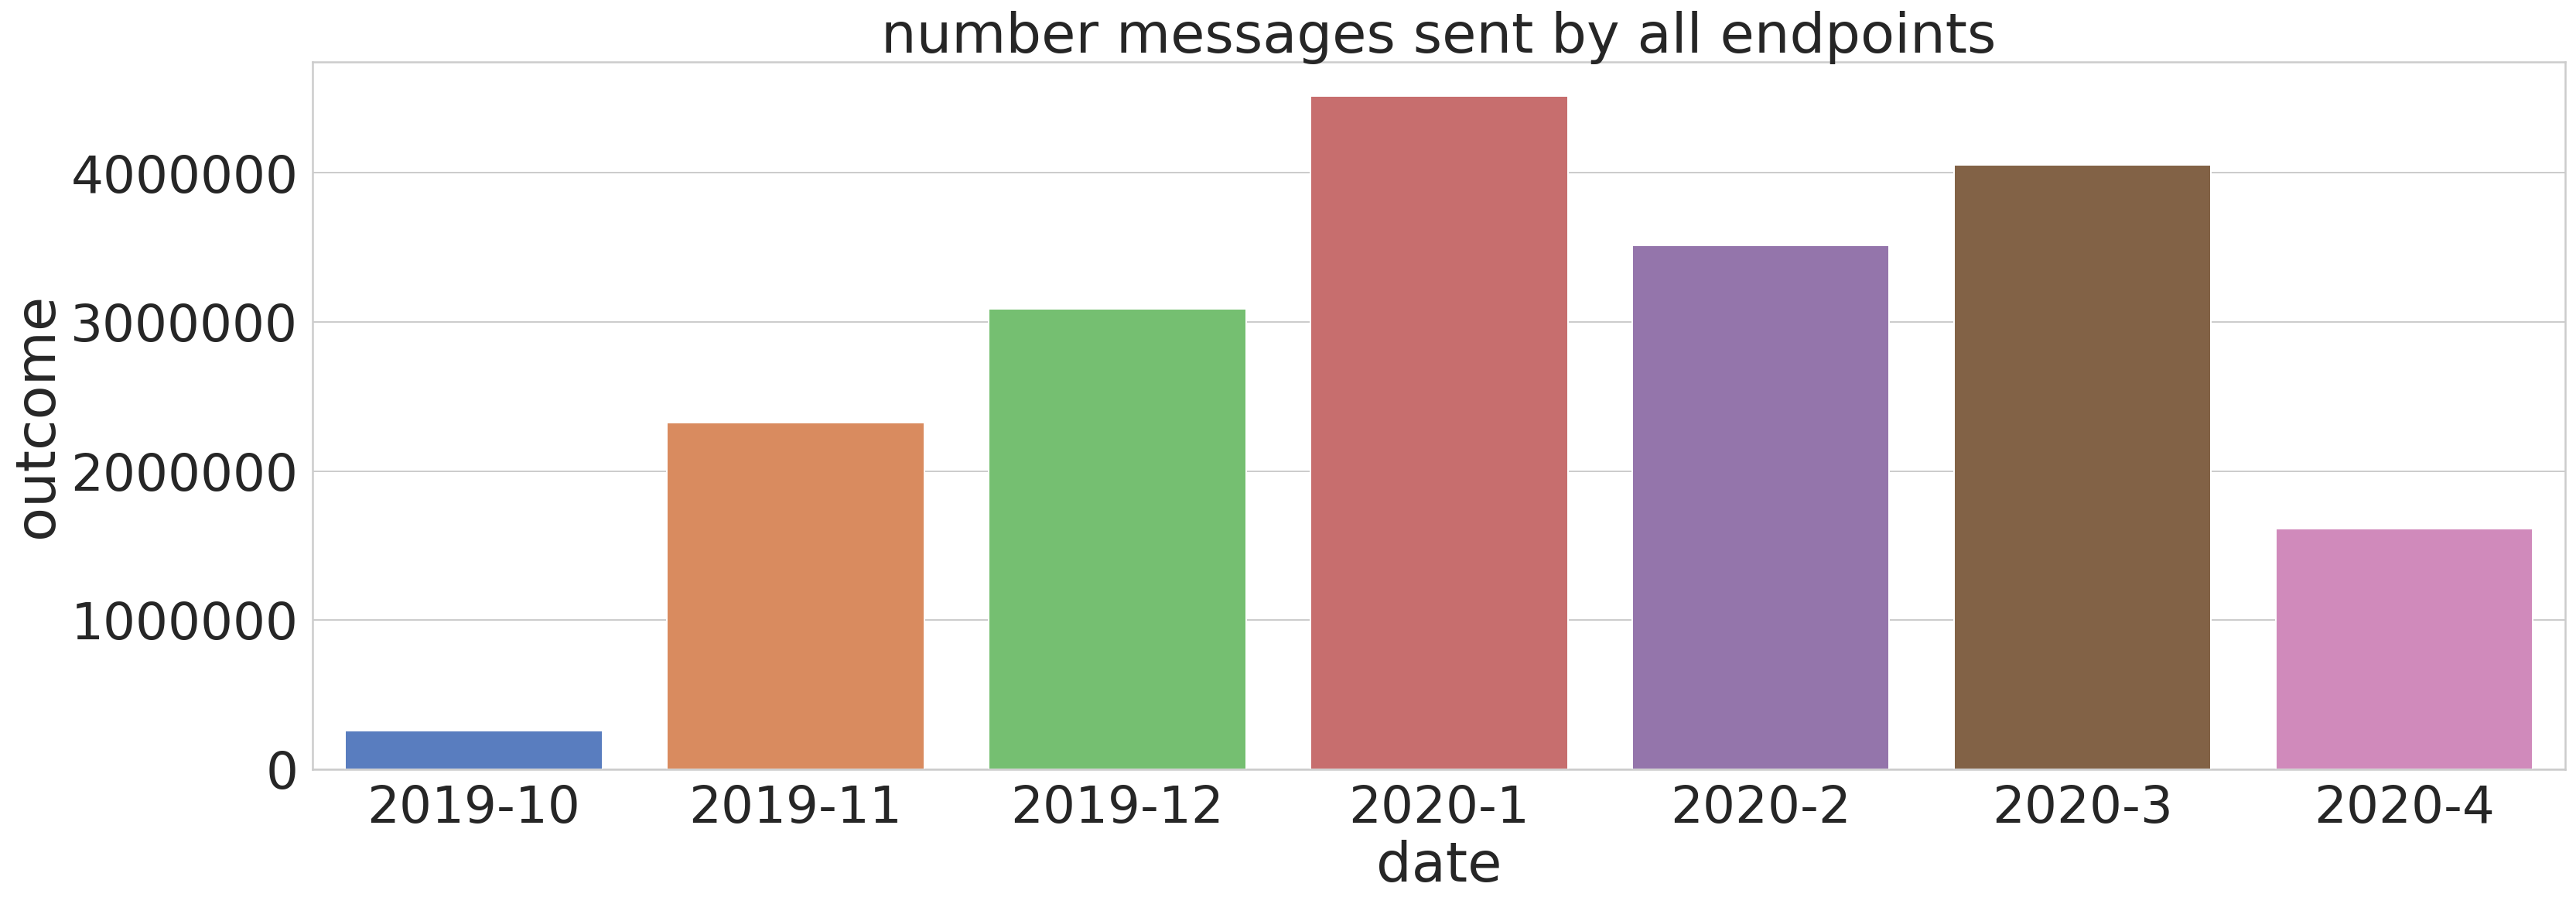

In [231]:
md = createData_ym(pfall,0,2)
createBarplot(md,24,9,3.0,title="number messages sent by all endpoints")

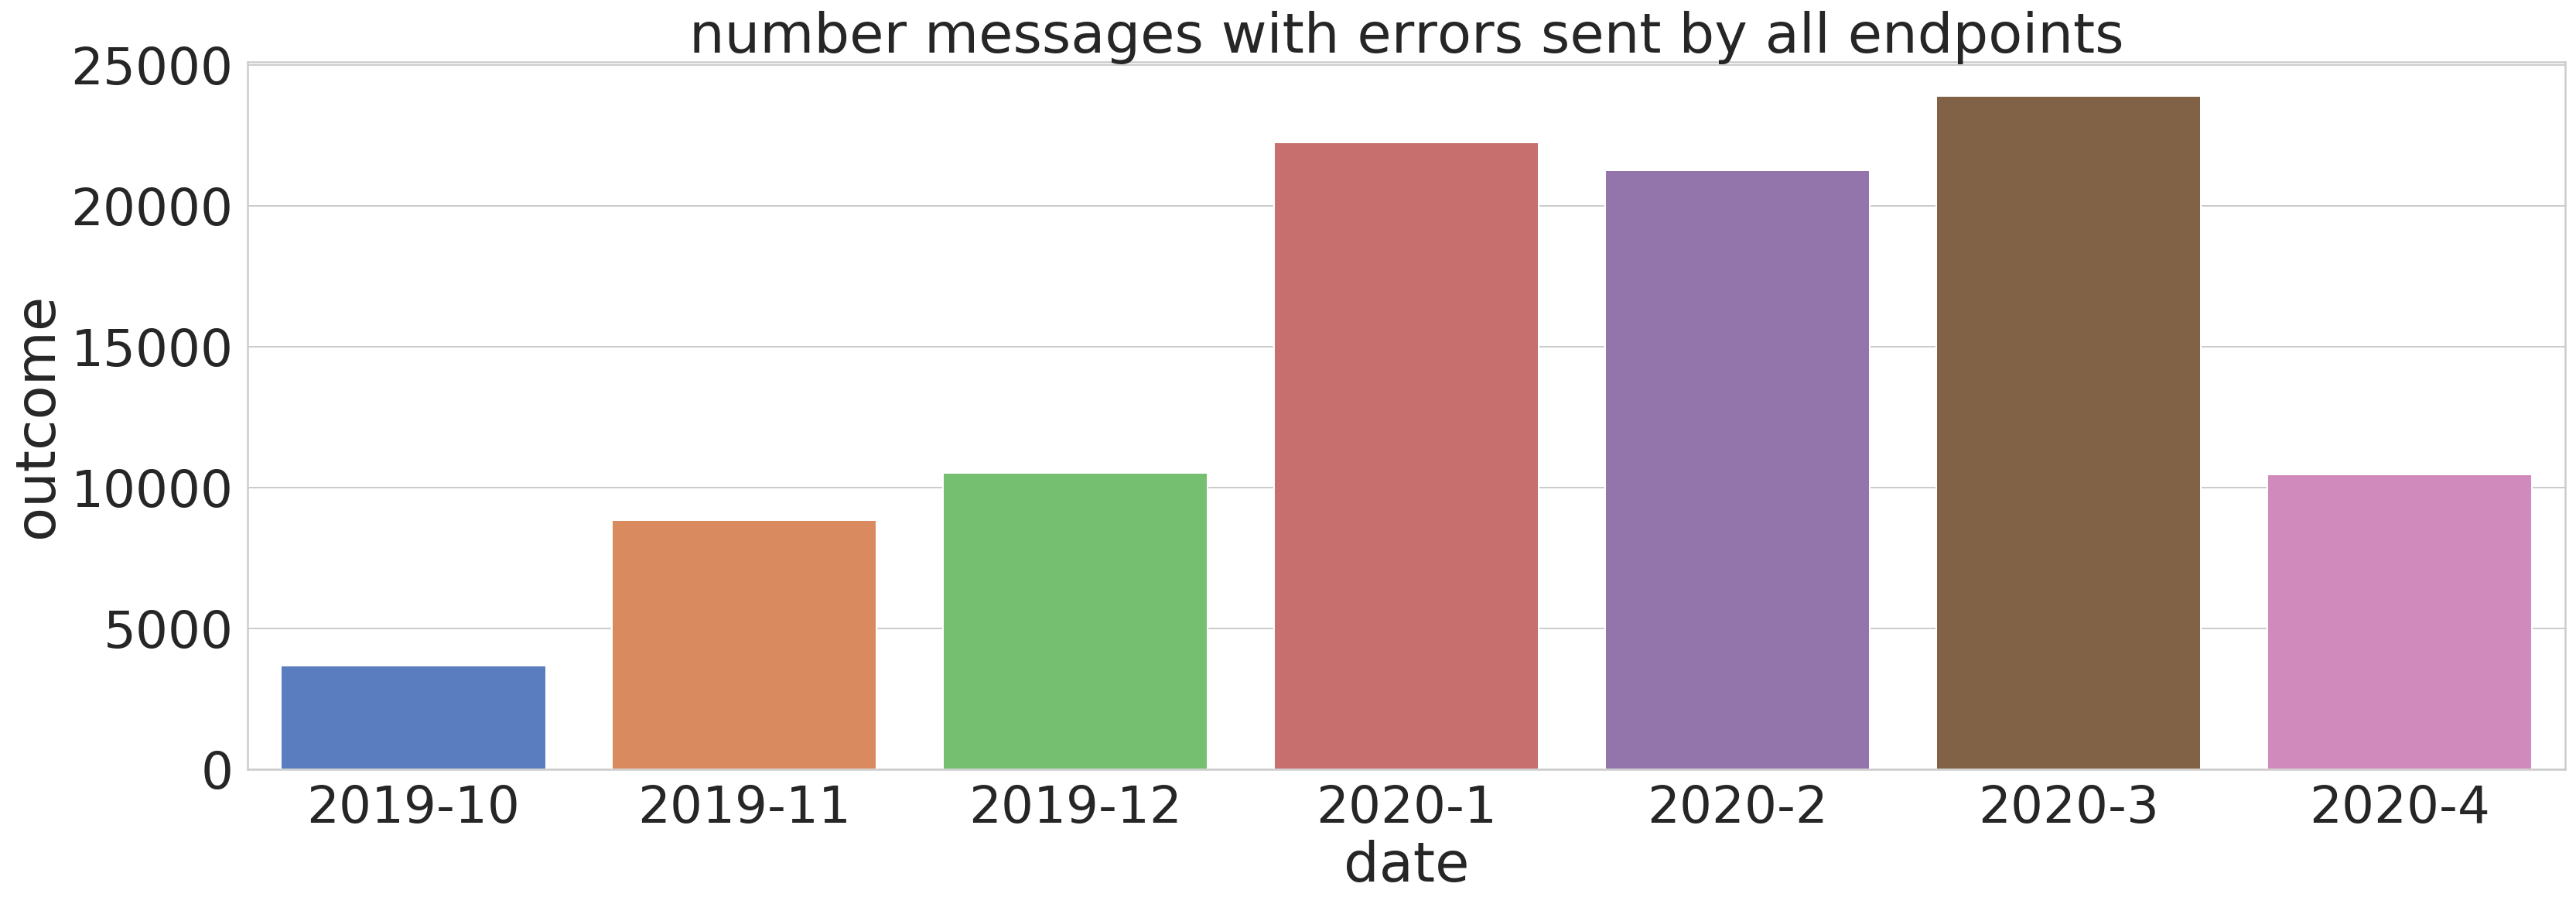

In [230]:
md = createData_ym(pfall,0,1)
createBarplot(md,24,9,3.0,title="number messages with errors sent by all endpoints")

# Details for different CSENDERENDPOINTID

In [251]:
#pd.unique(mdcountsall[1].index.get_level_values(0))
TOP=500000
result = pfall.groupby(['CSENDERENDPOINTID']).count()
data2 = pd.DataFrame()
data2['date'] = result.index.get_level_values(0).astype(str)
data2['outcome'] =  result['outcome'].astype(int)
topsender =  data2[data2['outcome'] > TOP].sort_values('outcome').reset_index()
topsender.columns = ['index', 'CSENDERENDPOINTID', 'outcome']

In [252]:
#pfall1 = pfall[pfall['CSENDERENDPOINTID'].isin(topsender['date'])]
pfall1 = pfall[pfall['CSENDERENDPOINTID']==int(topsender.iloc[7]['CSENDERENDPOINTID'])]

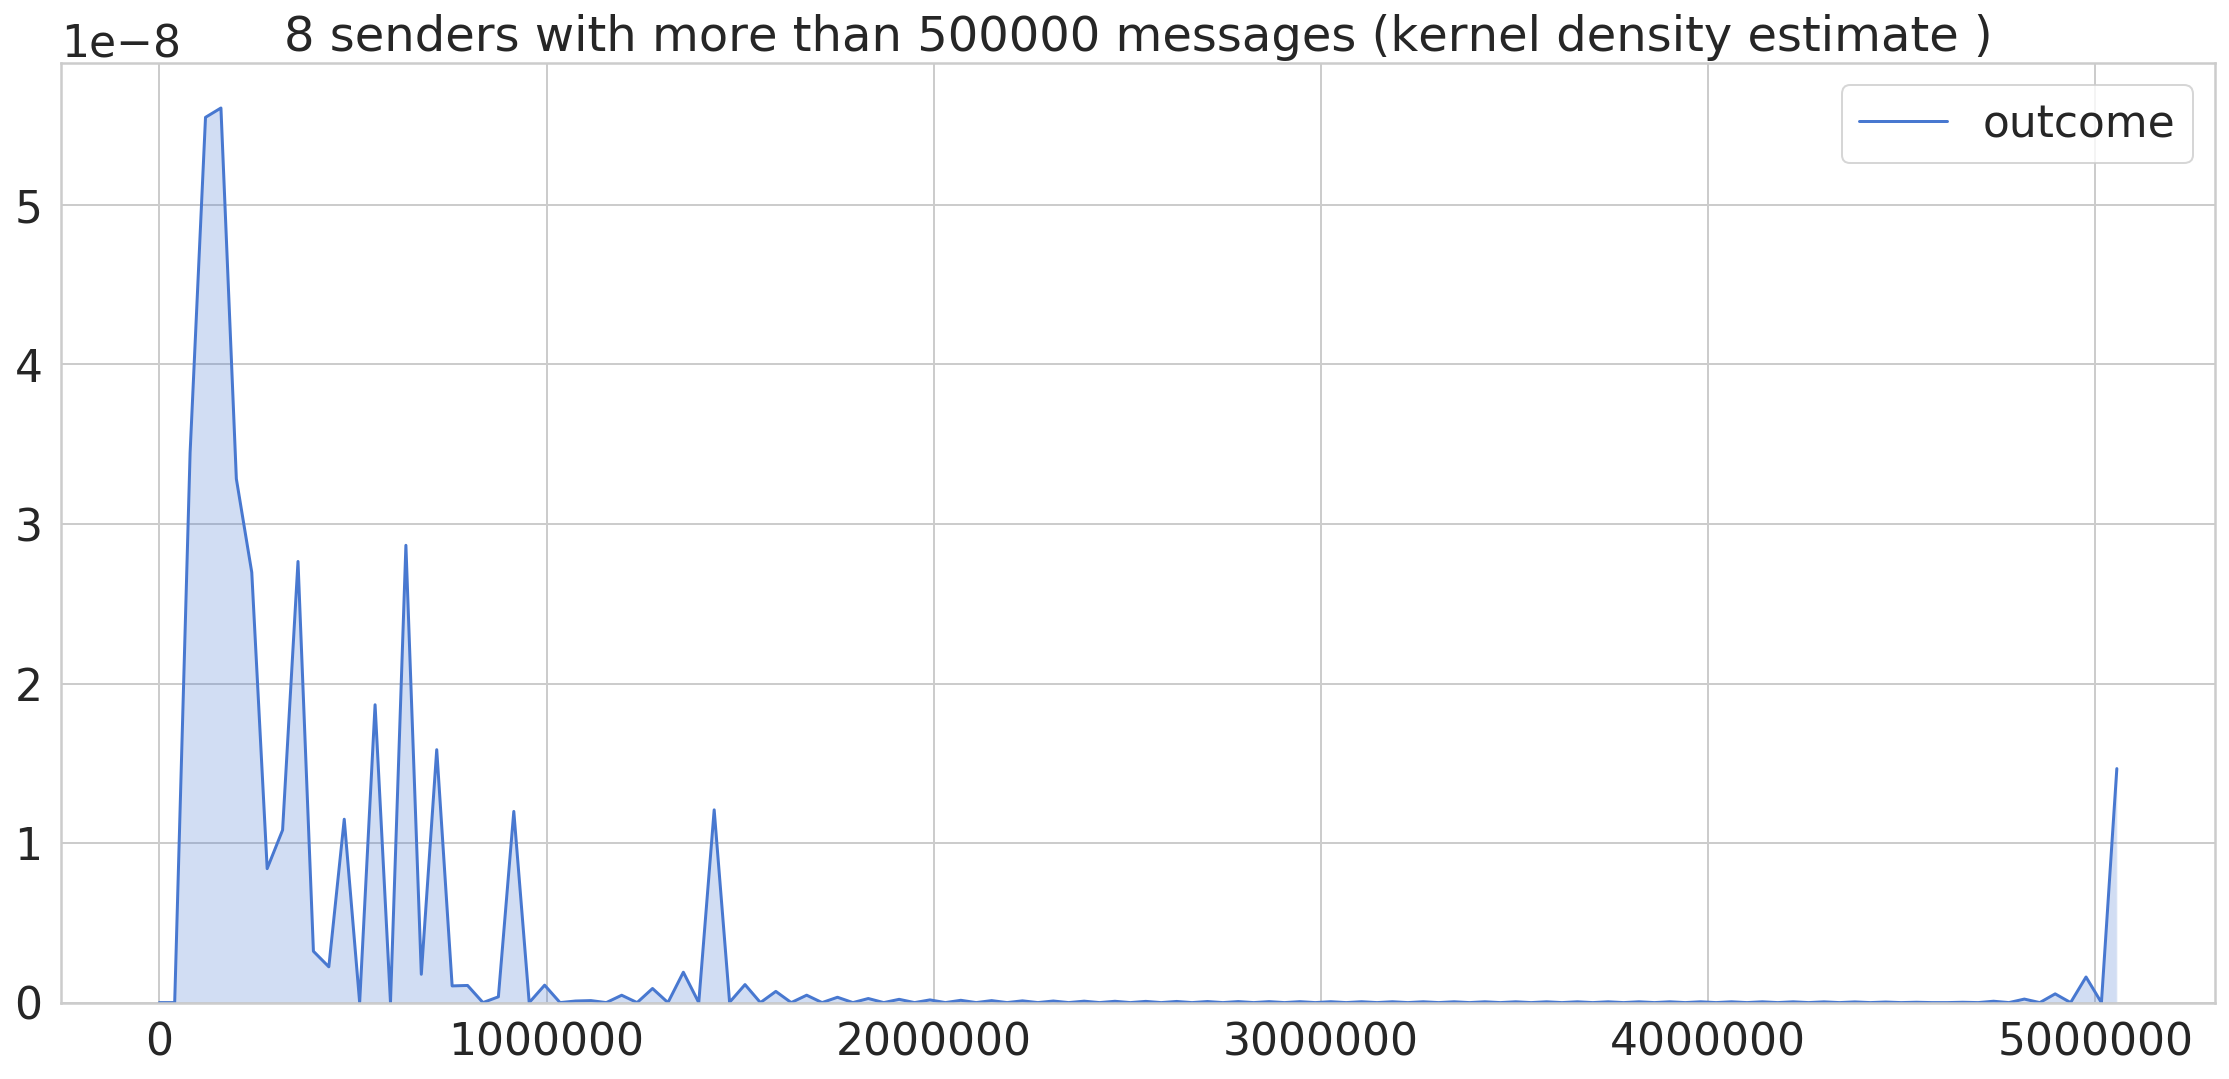

In [253]:
title = str(len(topsender)) + " senders with more than " + str(TOP) + " messages (kernel density estimate )"
createKDE(data2,16,8,2,title)
label(ax,1,90)
#topsender.iloc[7]

# Number messages of selected endpoint

CSENDERENDPOINTID: 2137: number messages so far = 5055494


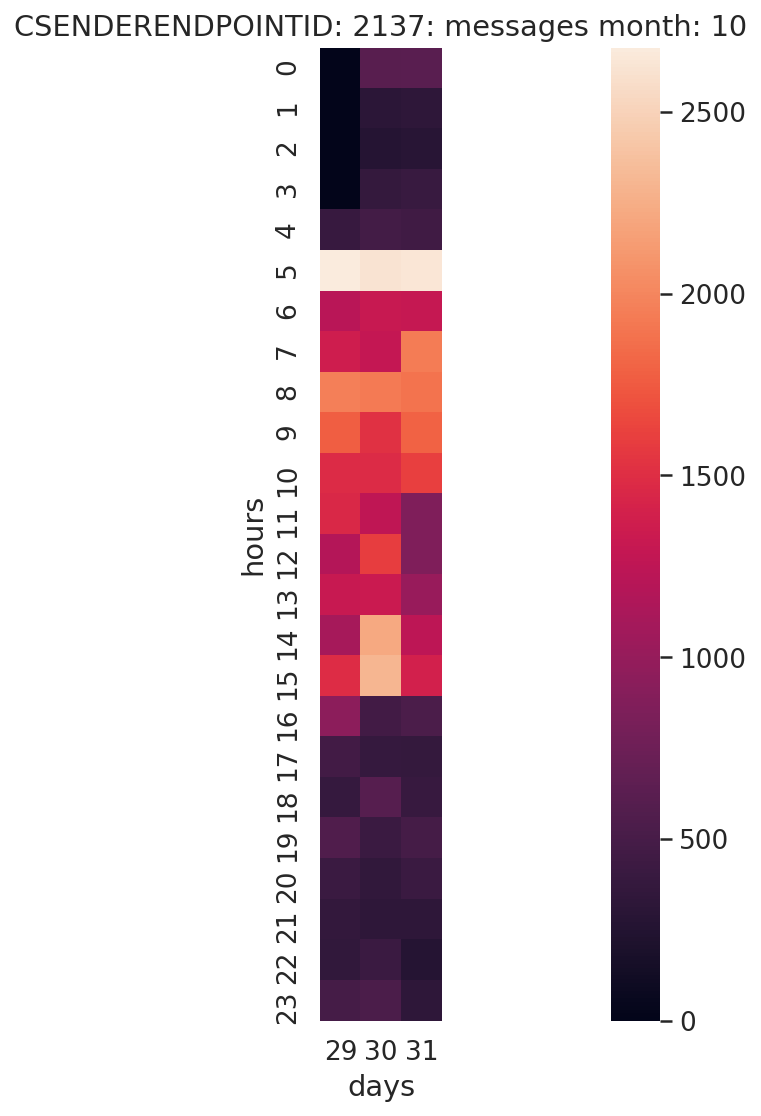

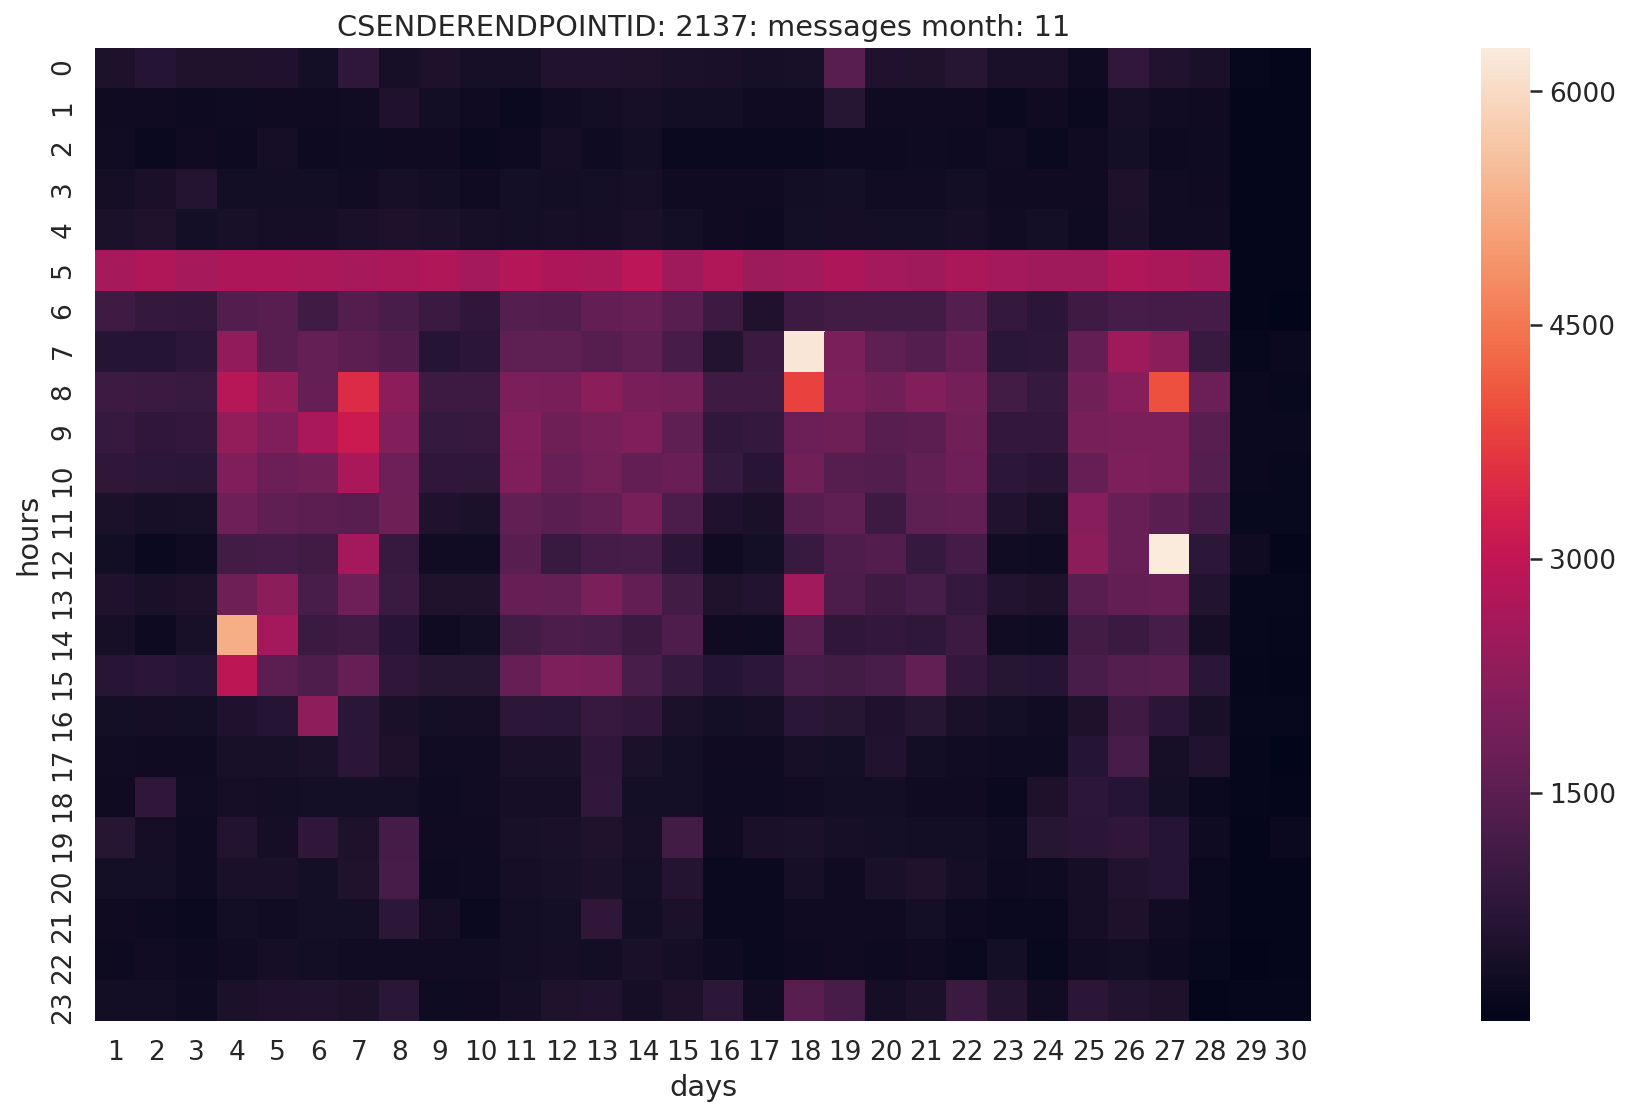

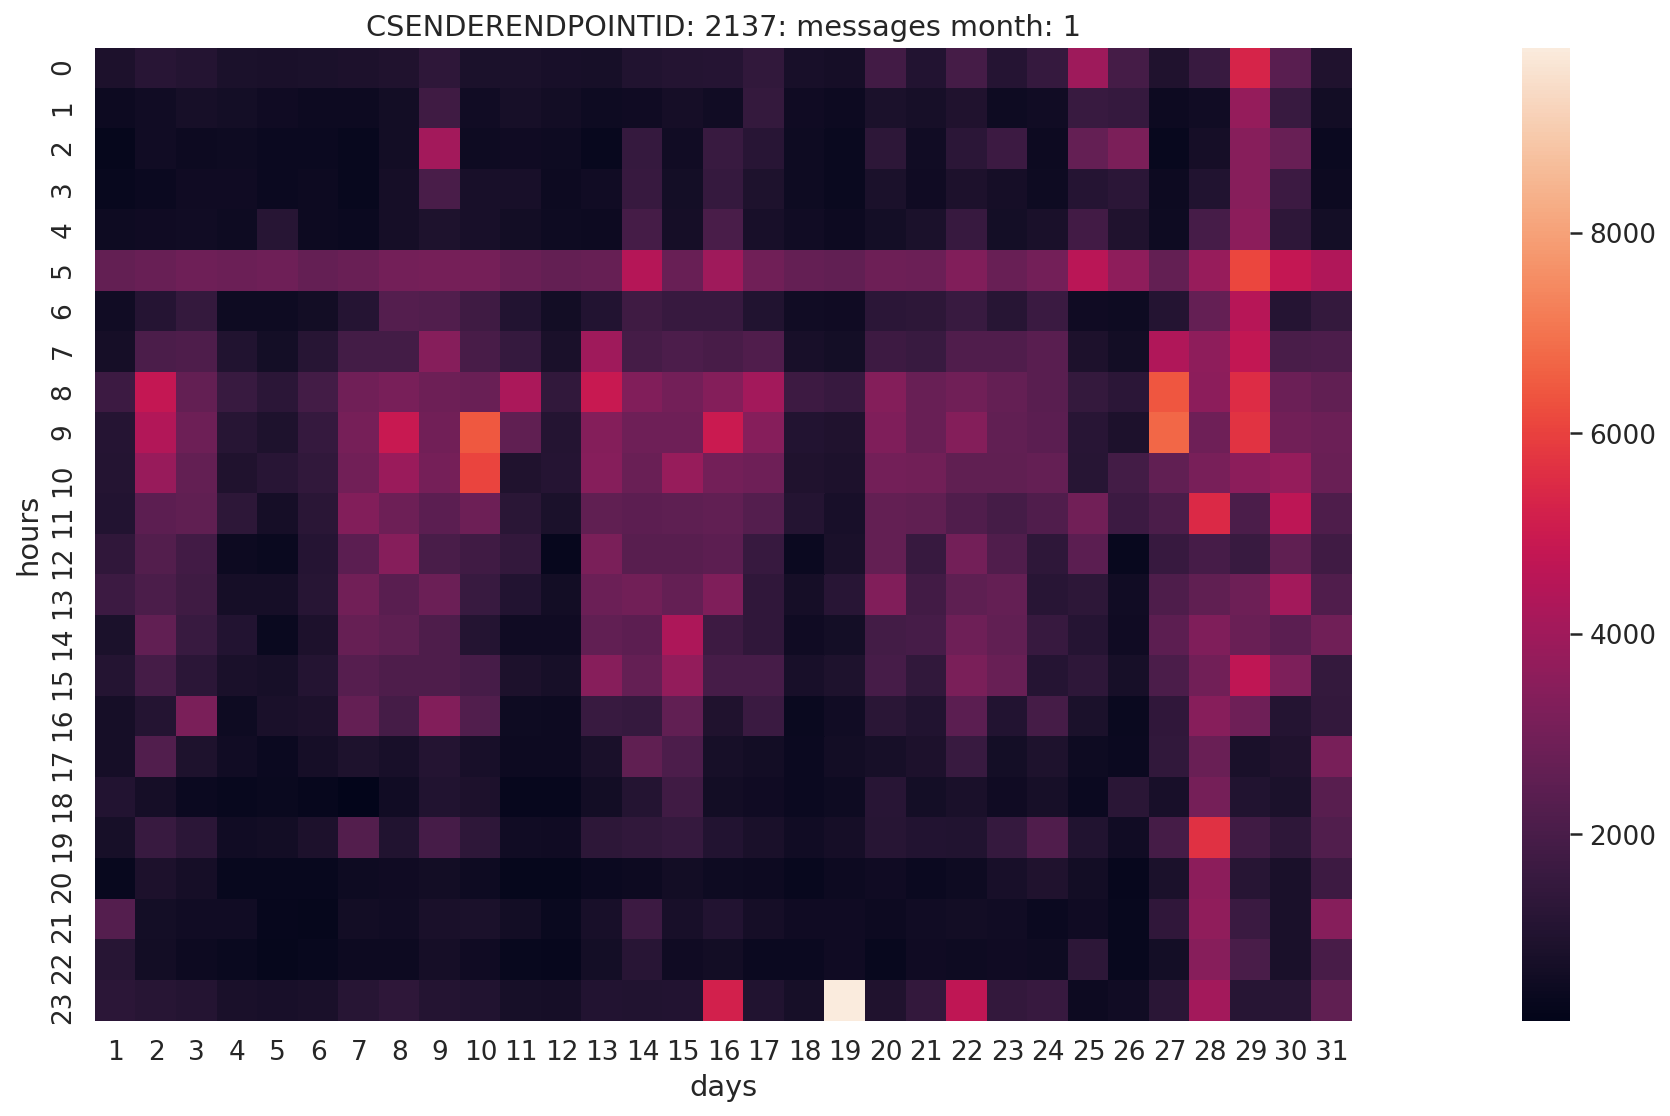

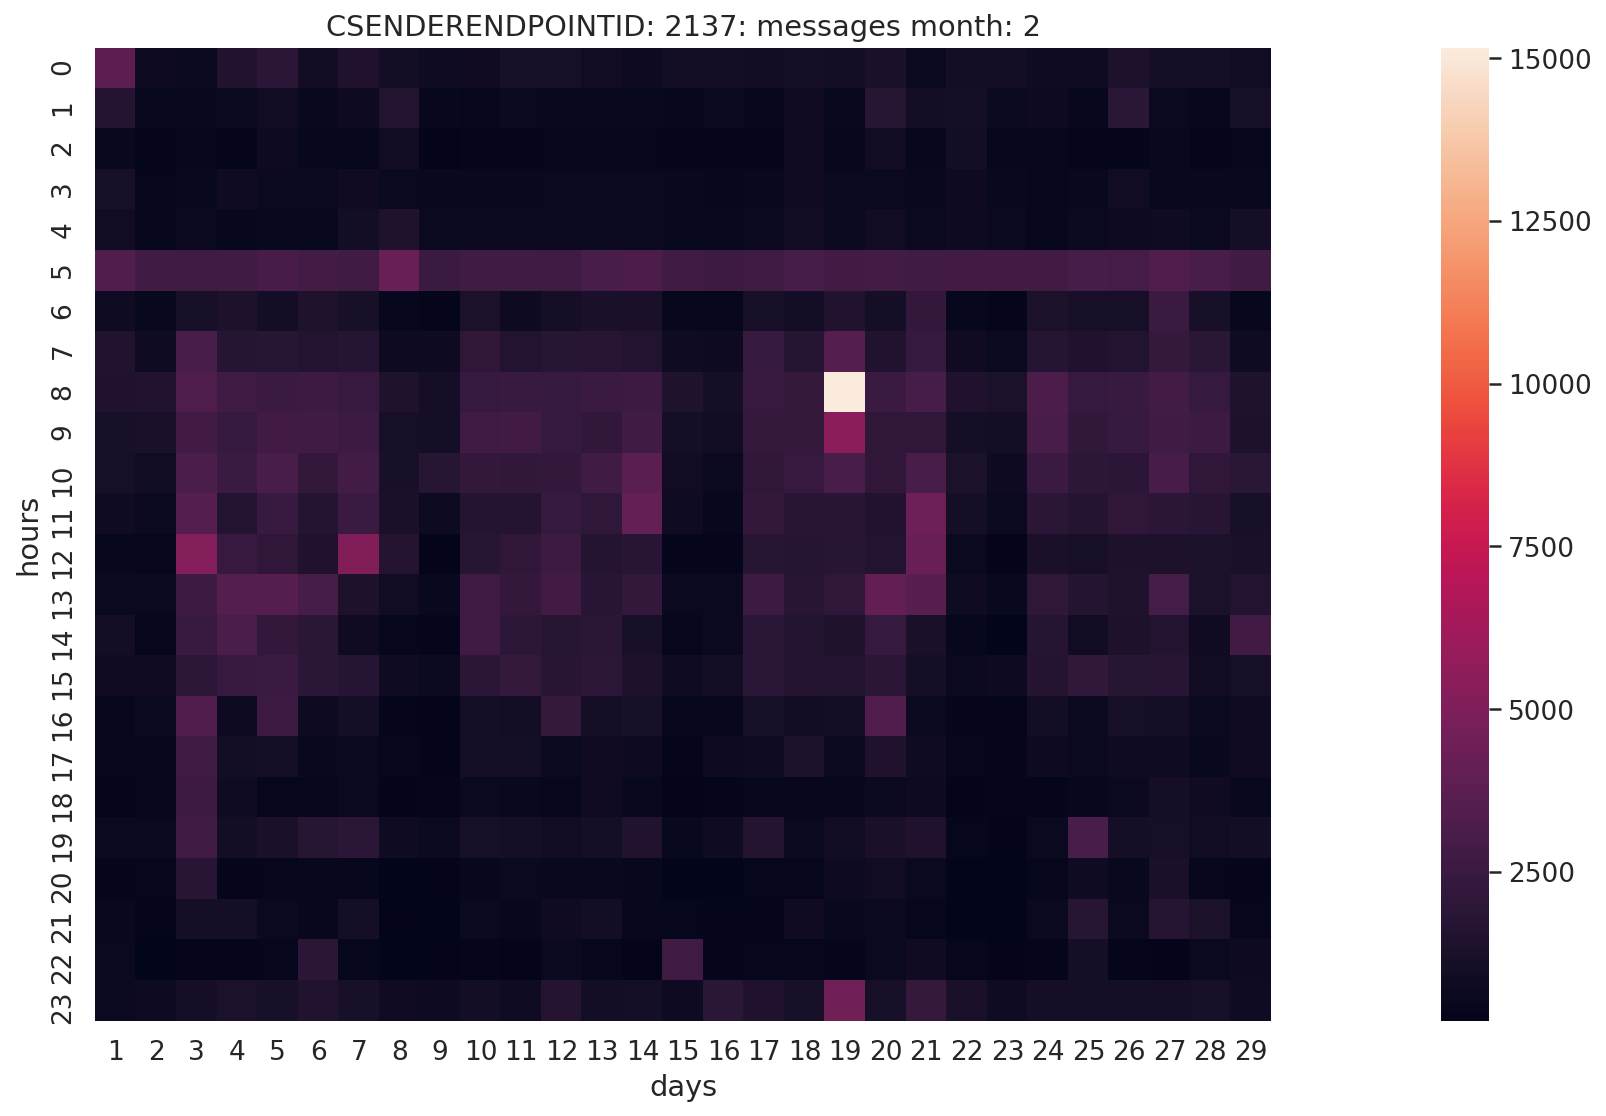

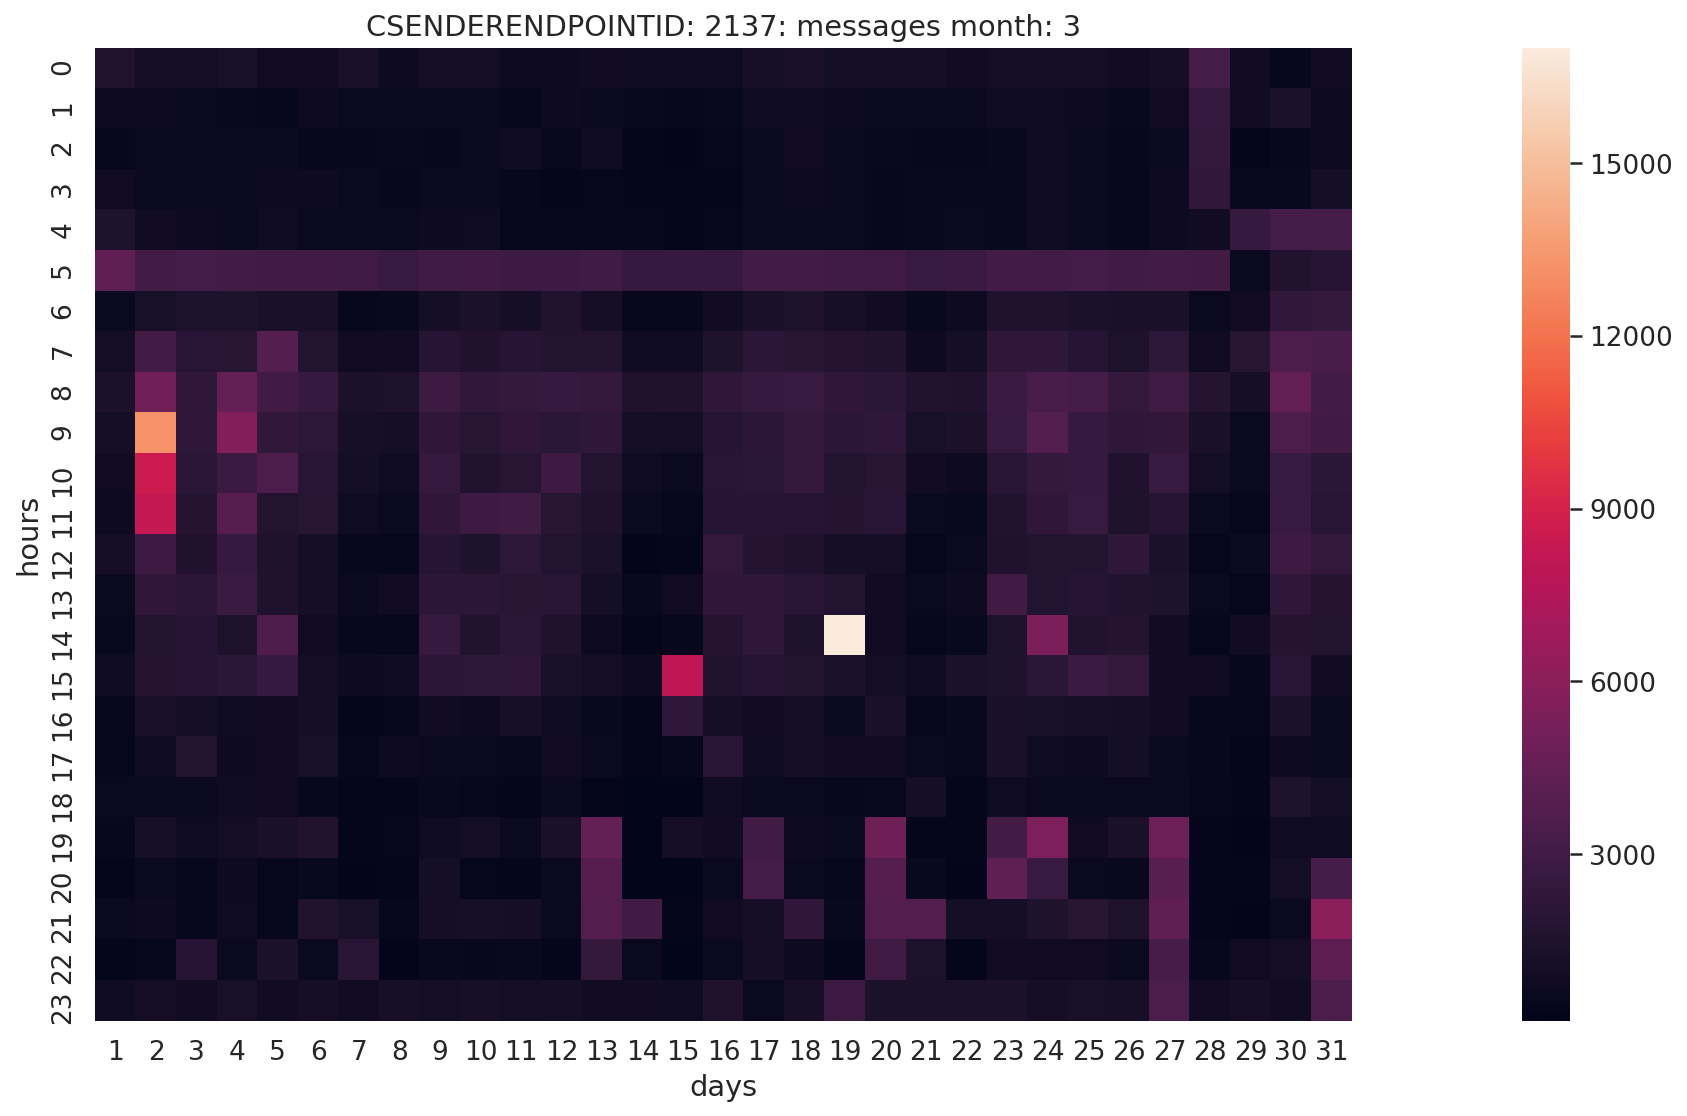

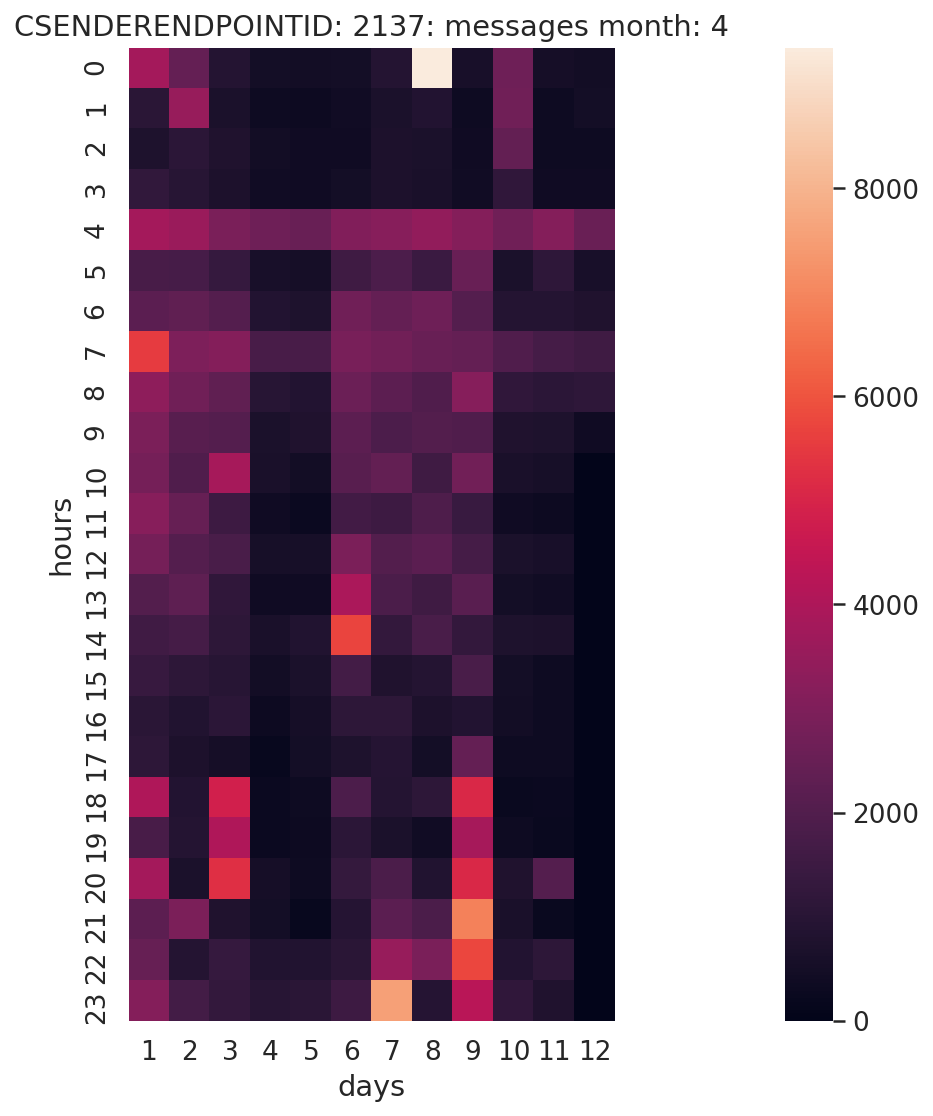

In [272]:
print("CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": number messages so far = " + str(topsender.iloc[7]['outcome']))
        

def createHeatmapSeries(pfall, months,category, outcome) :
    for month in months:
        data2 = createData(pfall,month,outcome)
        piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
        #titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category + " so far = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
        titlestring = "CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + ": "+ category  + " month: " + str(month) 
        sns.set(style='whitegrid', palette='muted', font_scale=1.2)
        createHeatmap(piv, titlestring)
       
createHeatmapSeries(pfall1,[10,11,1,2,3,4],'messages', 2)

# Number messages with errors of selected endpoint

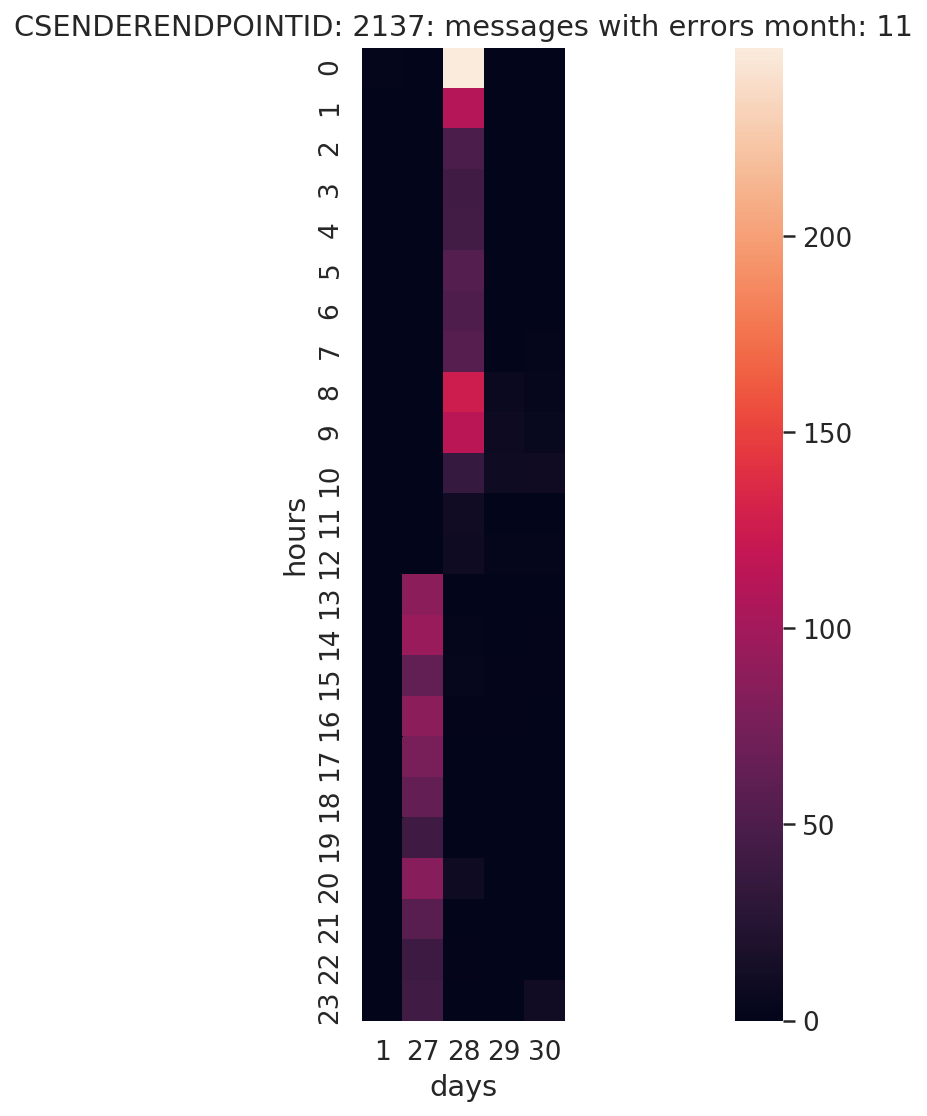

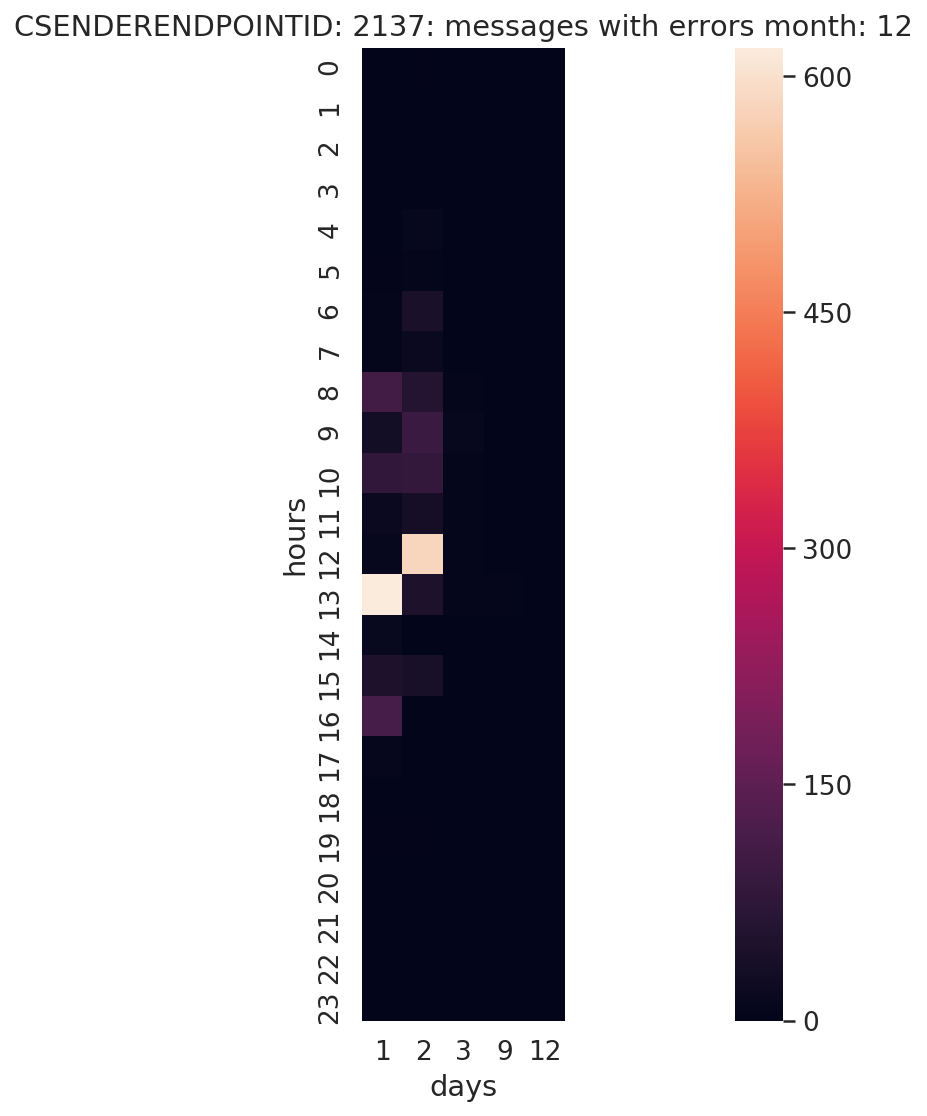

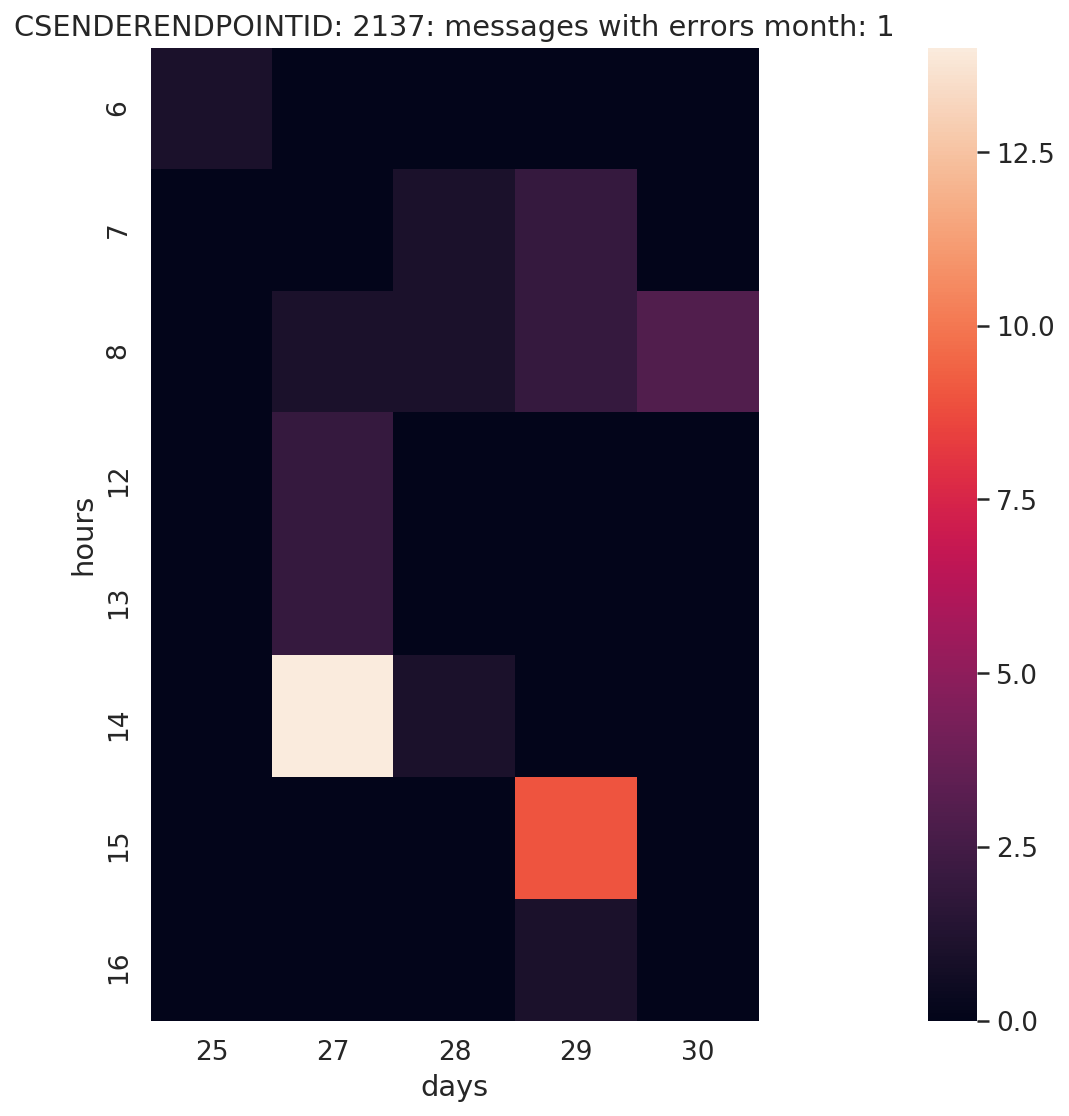

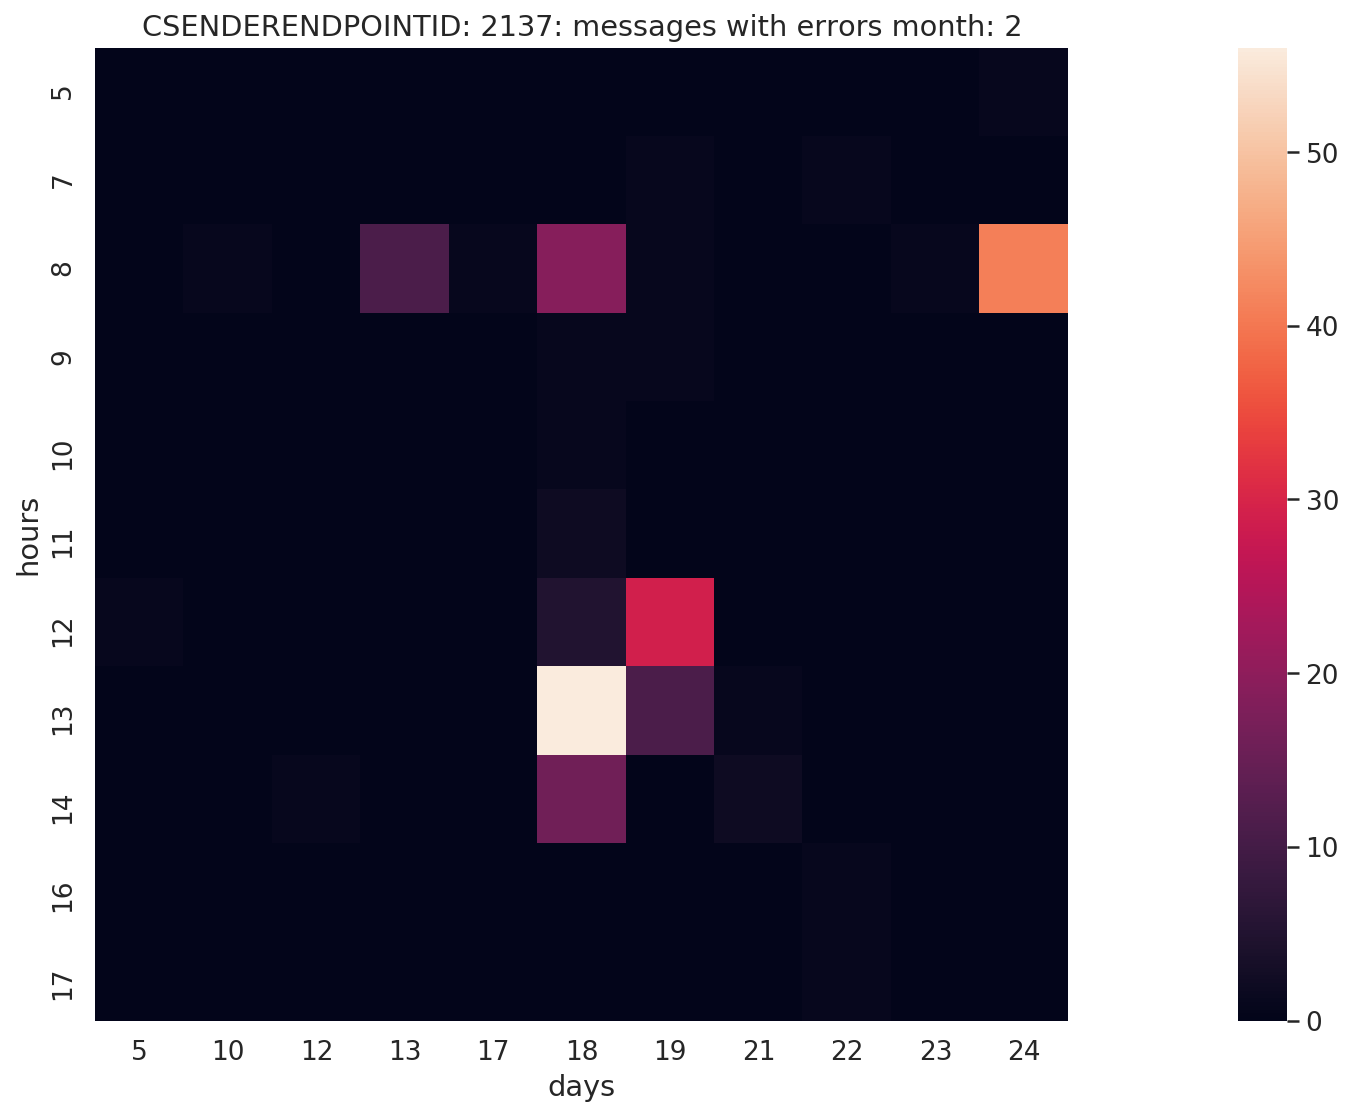

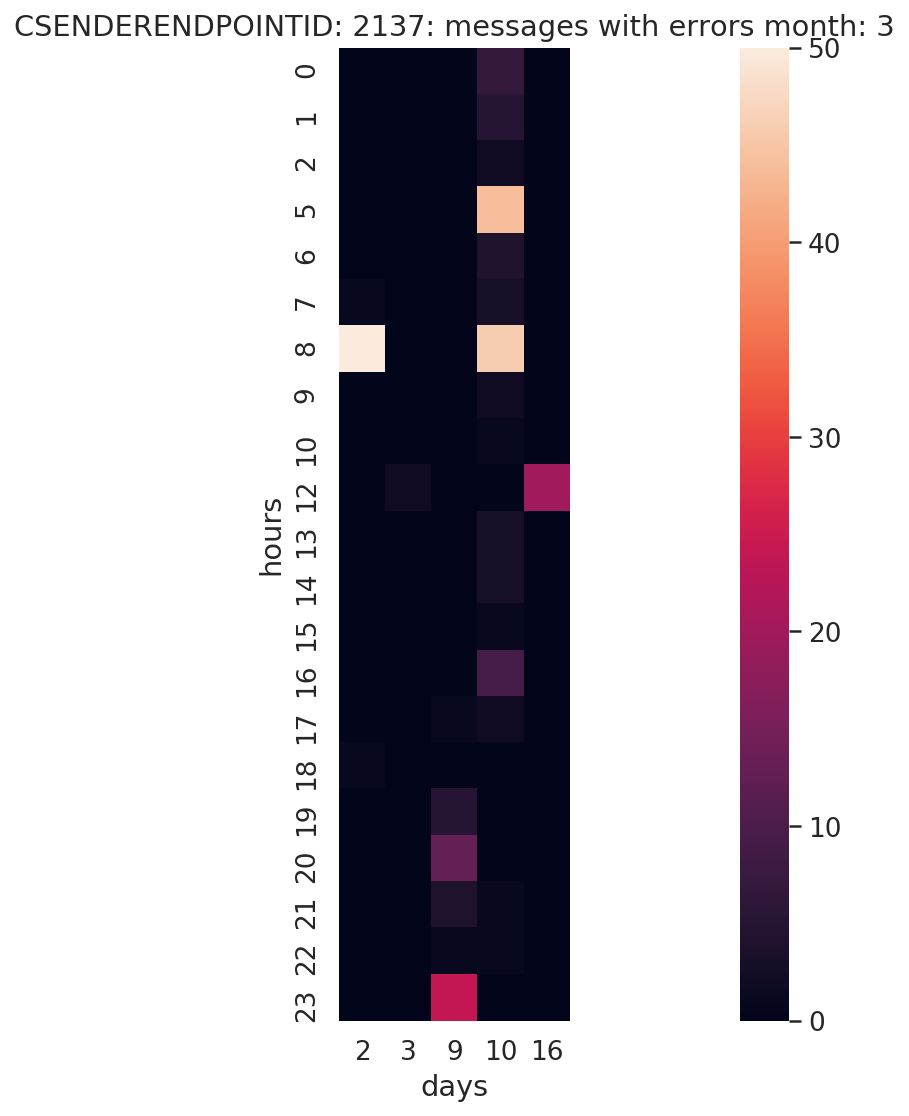

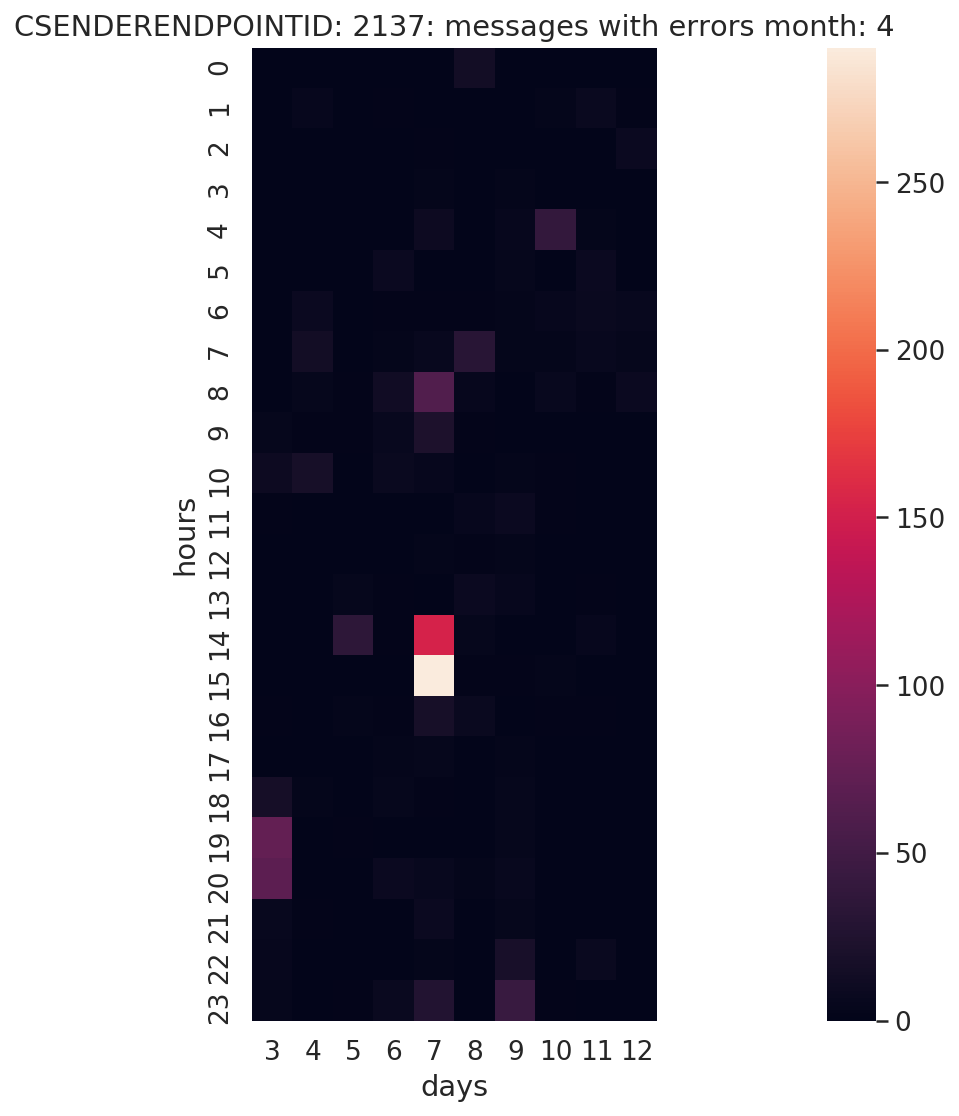

In [282]:
createHeatmapSeries(pfall1, [11,12,1,2,3,4],'messages with errors', 1)

# Anomaly Detection with LSTM Autoencoders (selected SENDERPOINTID)

In [283]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [284]:
df = createDataframe(pfall1)
train, test = getTrainAndTest(df,0.95)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[OUTCOME]])
train[OUTCOME] = scaler.transform(train[[OUTCOME]])
test[OUTCOME] = scaler.transform(test[[OUTCOME]])

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[[OUTCOME]], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[[OUTCOME]], test.close, TIME_STEPS)
print(X_train.shape)

model = initmodel()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

train.shape:  (3790, 1) test.shape:  (200, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(3766, 24, 1)
Train on 3389 samples, validate on 377 samples
Epoch 1/10
3389/3389 [==============================] - 7s 2ms/sample - loss: 0.4814 - val_loss: 0.5916
Epoch 2/10
3389/3389 [==============================] - 3s 870us/sample - loss: 0.4358 - val_loss: 0.5838
Epoch 3/10
3389/3389 [==============================] - 3s 895us/sample - loss: 0.4244 - val_loss: 0.5878
Epoch 4/10
3389/3389 [==============================] - 3s 850us/sample - loss: 0.4152 - val_loss: 0.5845
Epoch 5/10
3389/3389 [==============================] - 3s 850us/sample - loss: 0.4107 - val_loss: 0.5747
Epoch 6/10
3389/3389 [==============================] - 3s 857us/sample - loss: 0.4087 - val_loss: 0.5709
Epoch 7/10
3389/3389 [==============================] - 3s 914us/sample - loss: 0.4060 - val_loss: 0.5662
Epoch 8/10
3389/3389 [==============================] - 3s 886us/sample - loss: 0.4036 - val_loss: 0.5655
Epoch 9/10
3389/3389 [==============================] - 3s 846us/sample - loss: 0.4020 - val_

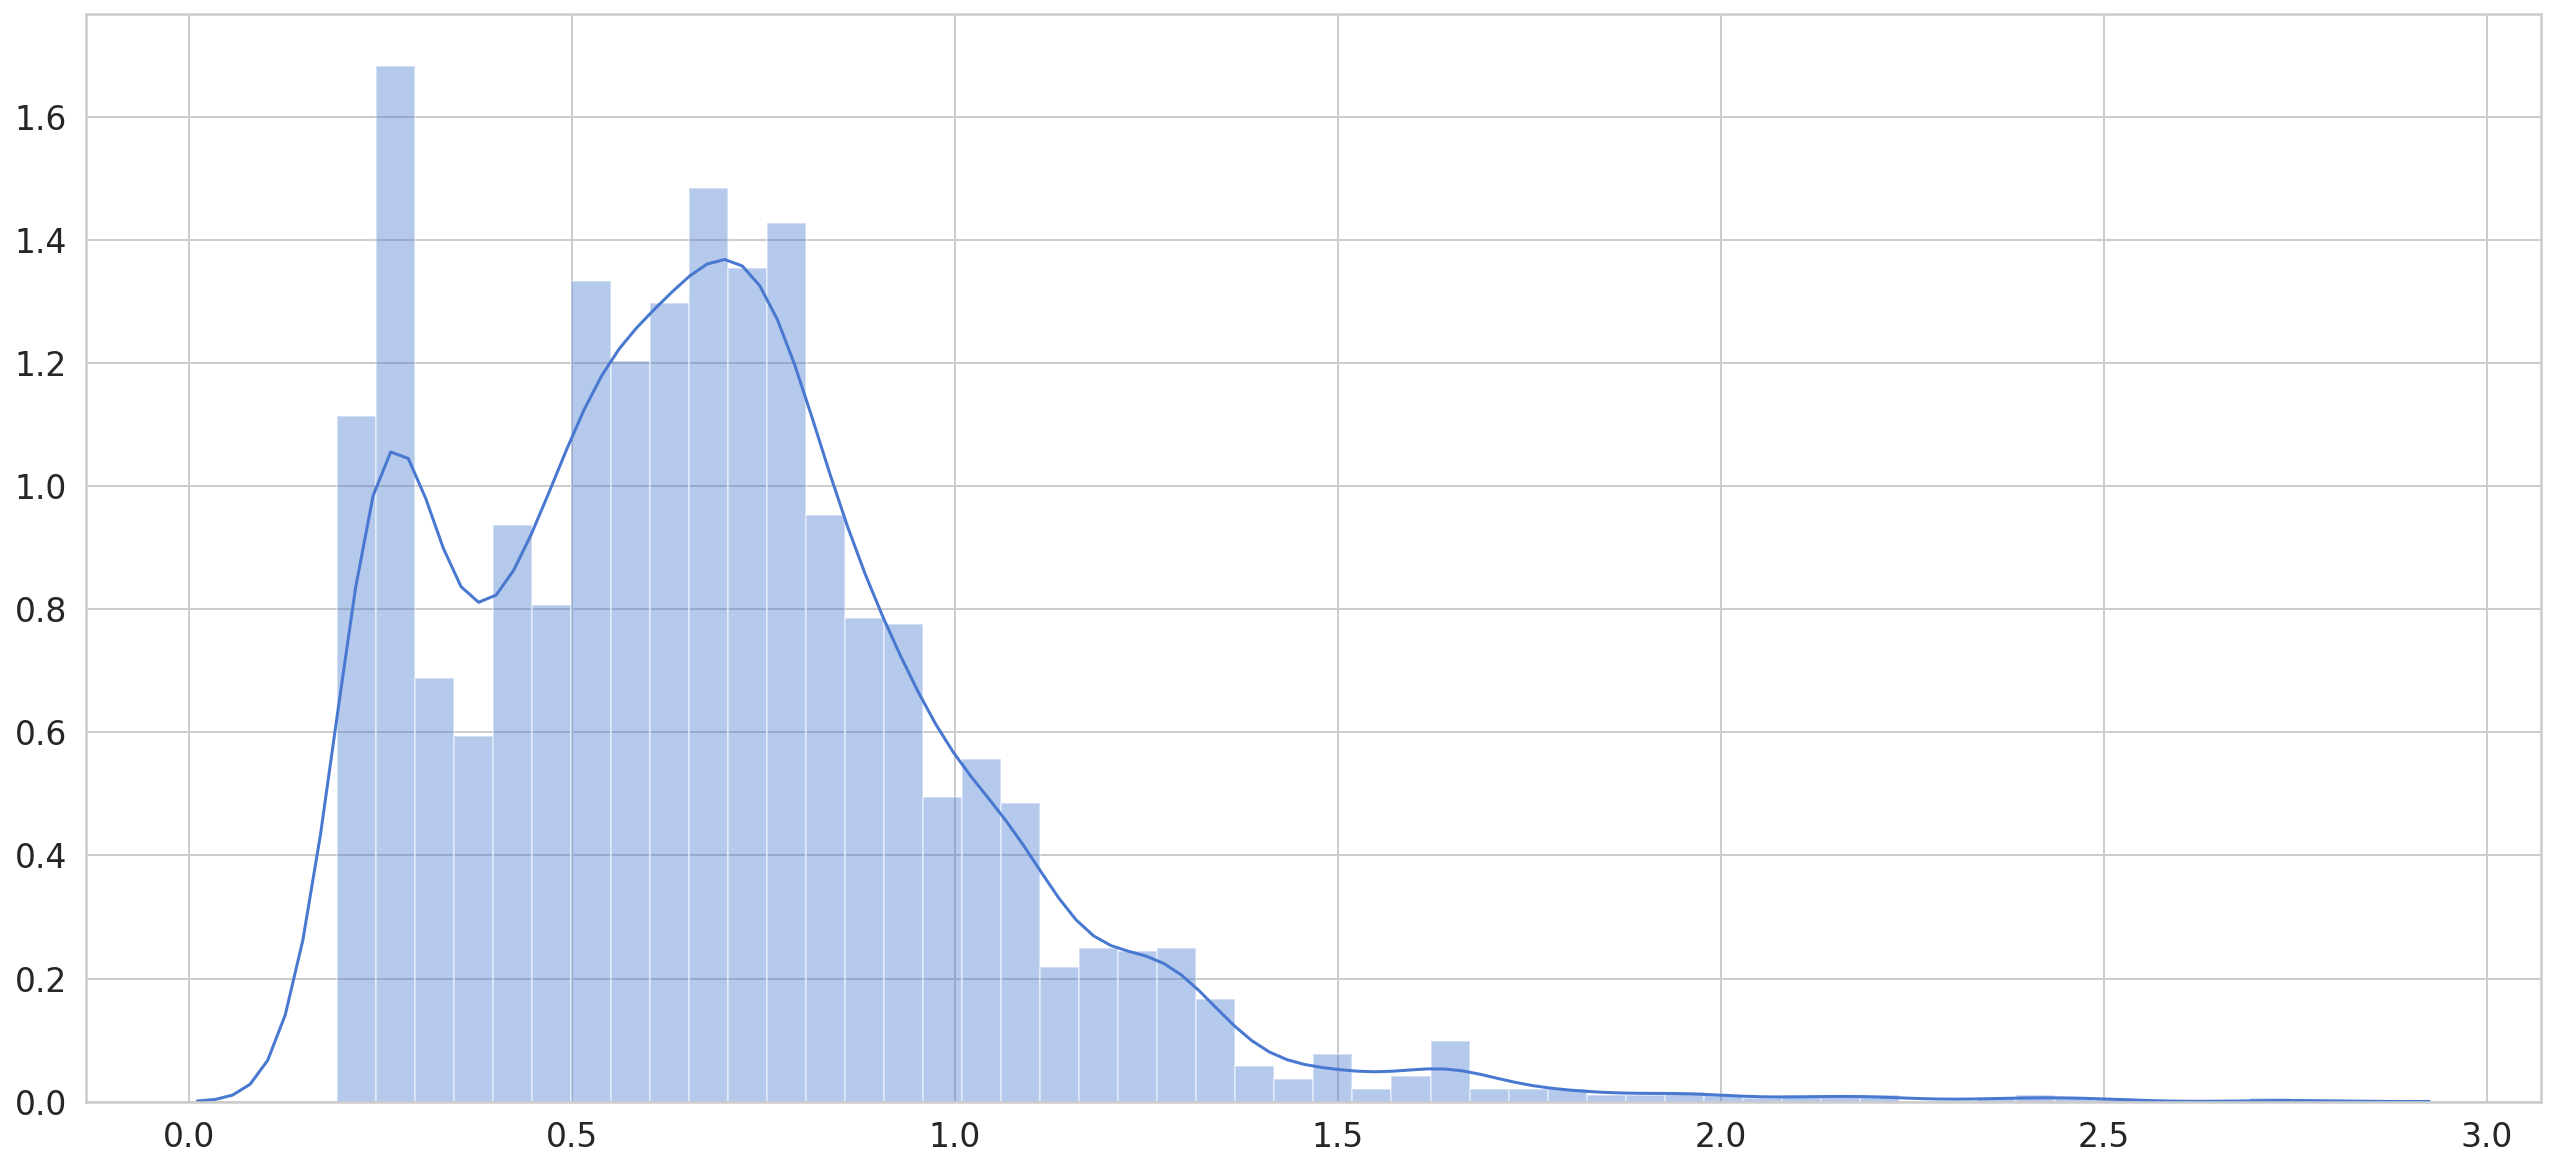

In [286]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [287]:
test_score_df = testScoreDF(model, 1.5)
anomalies     = test_score_df[test_score_df.anomaly == True]

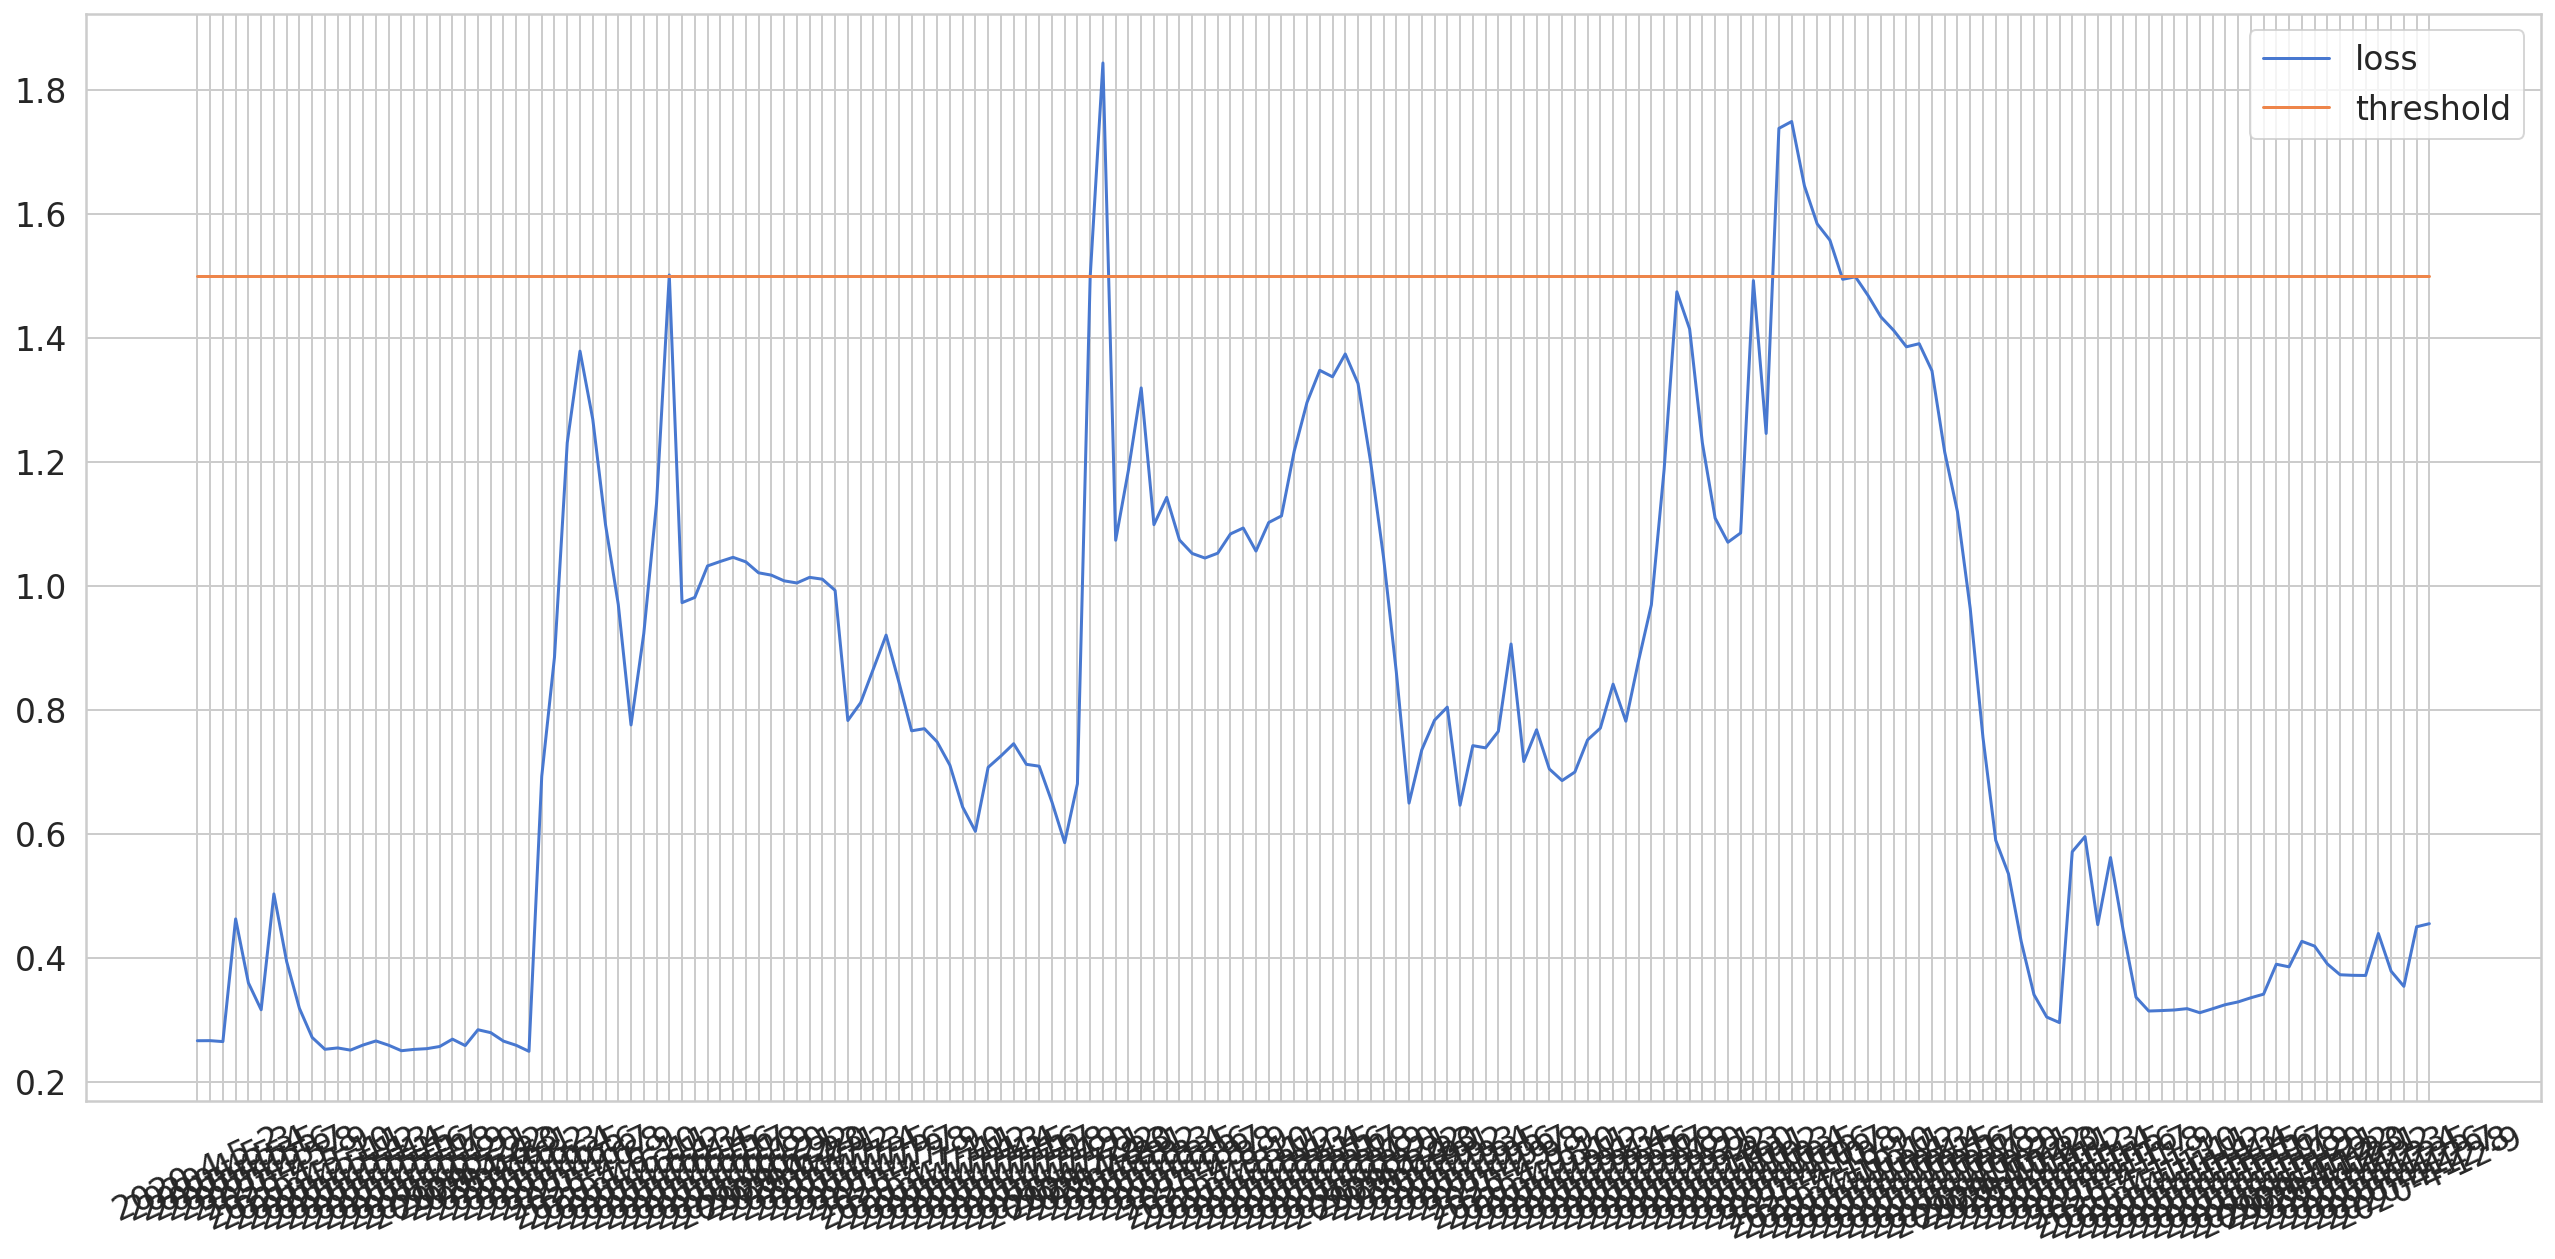

In [288]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [290]:
#anomalies.head()
#anomalies

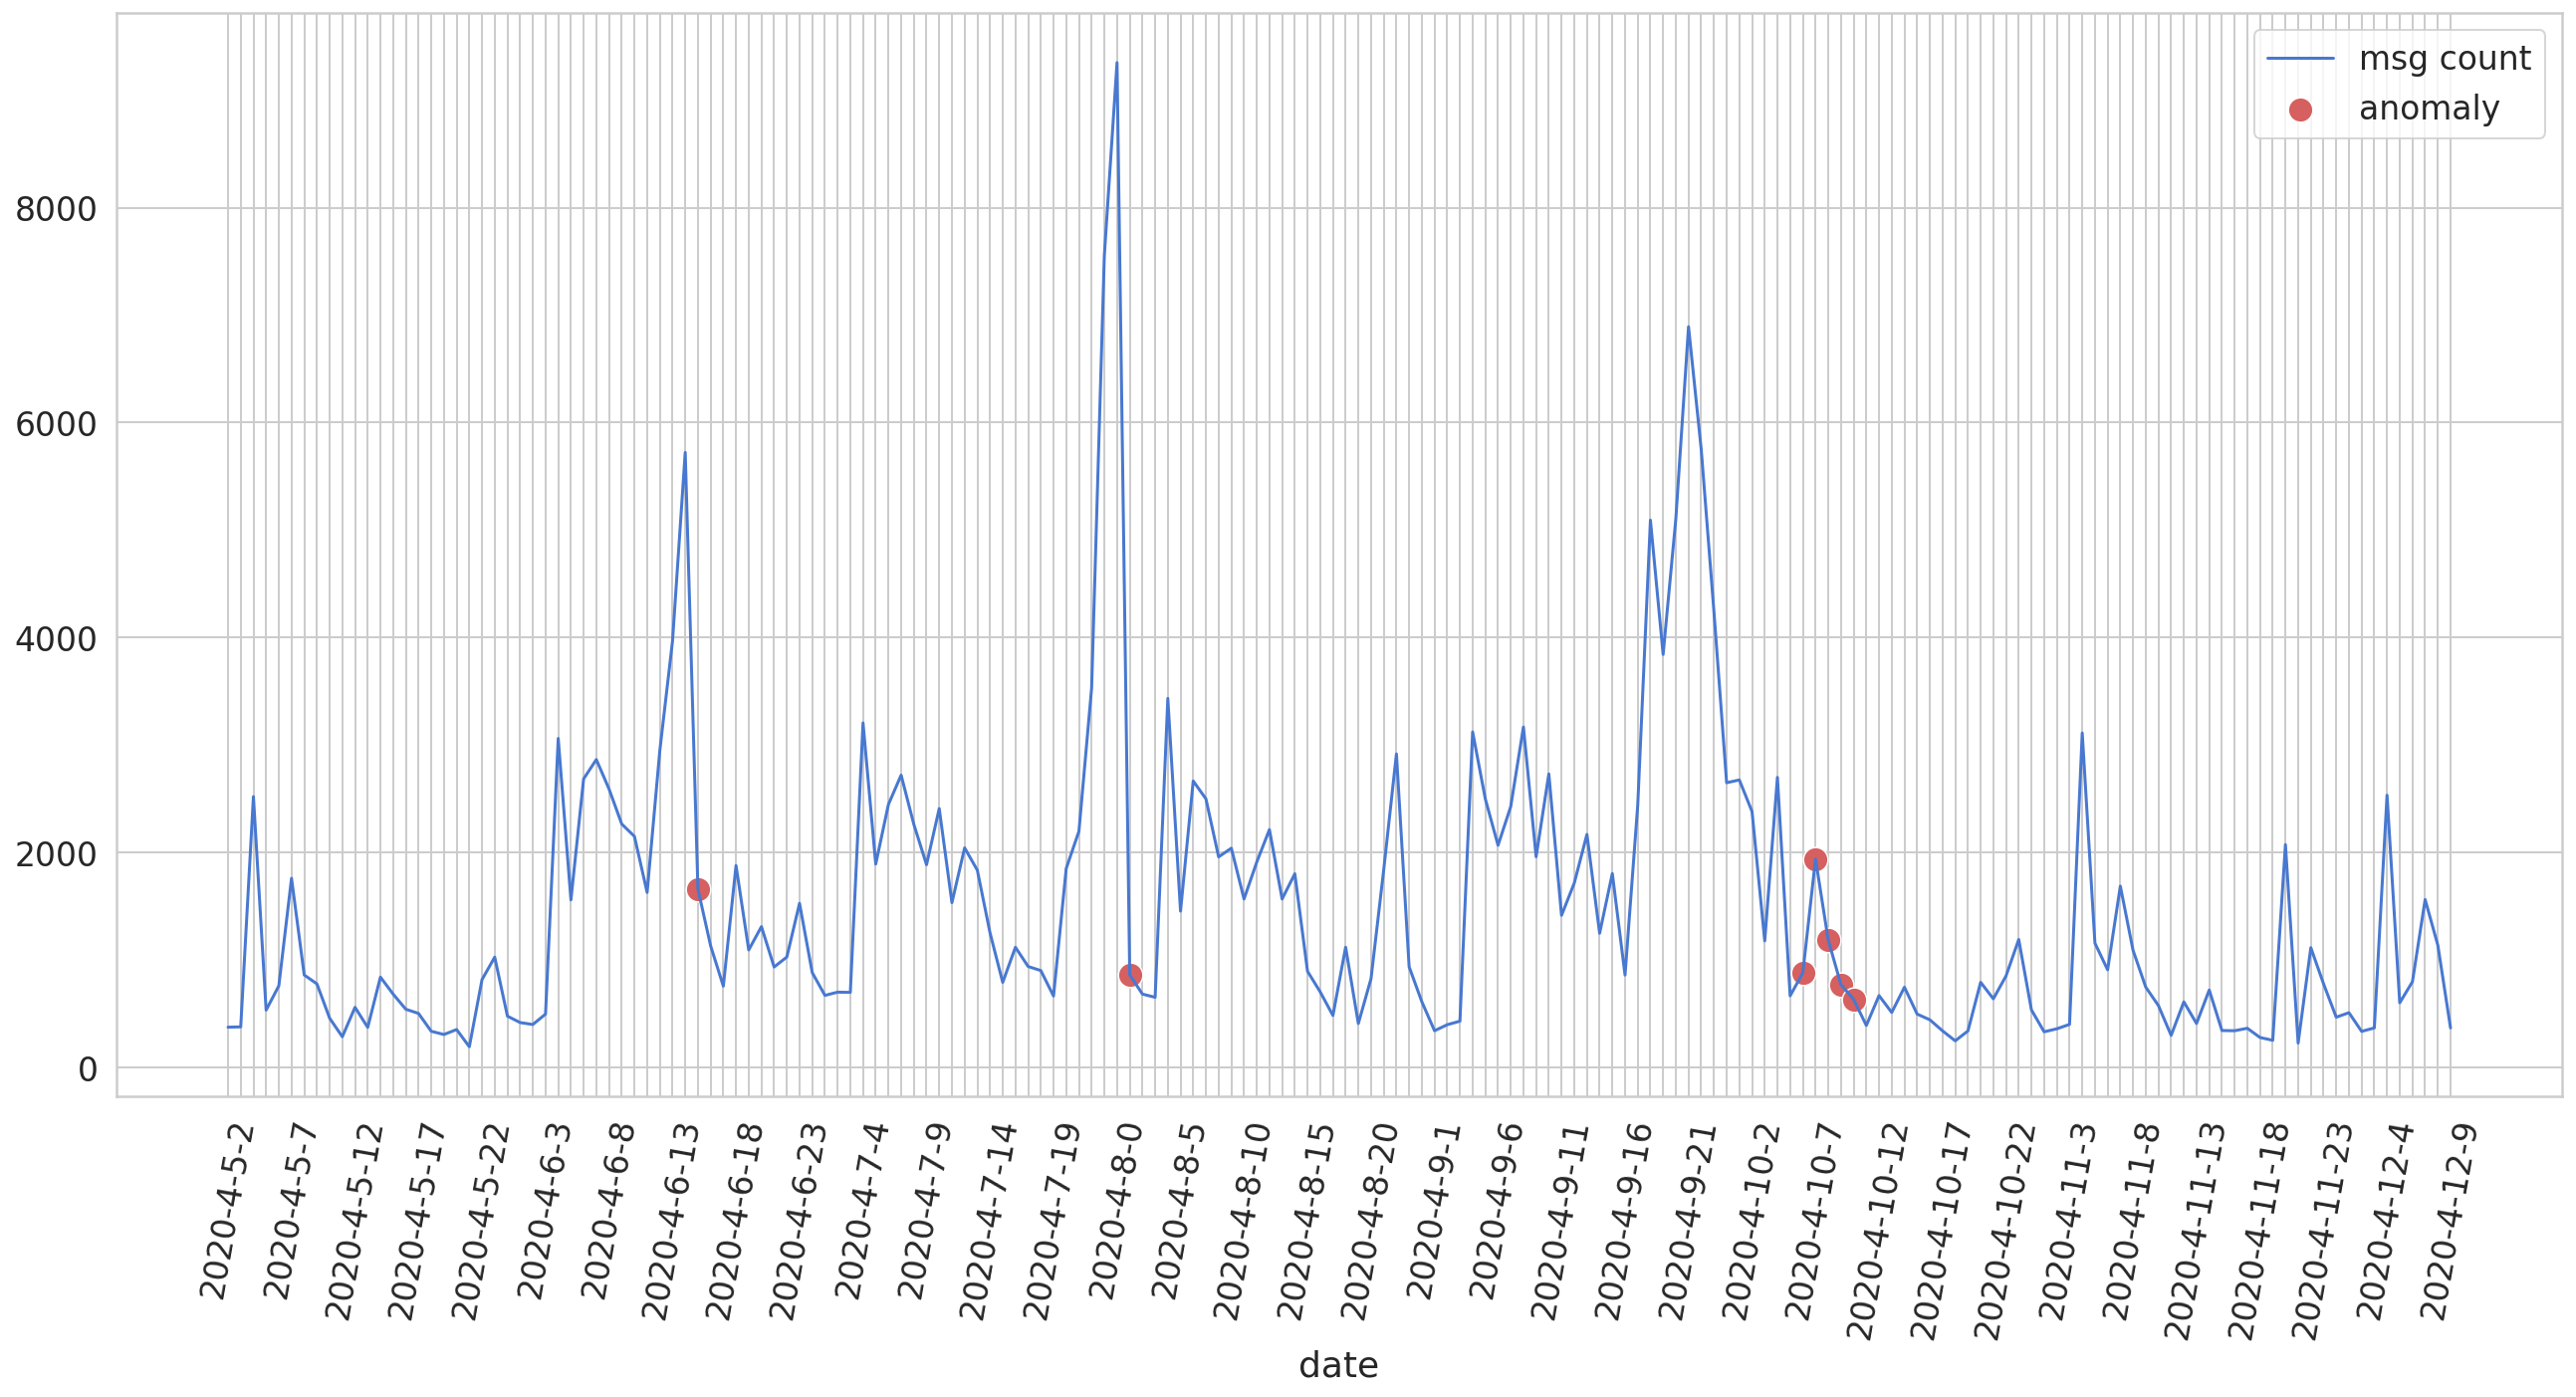

In [291]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='msg count'
);

ax = sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=152,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

label(ax,5,80)

# Trial 1

In [ ]:
#dataall2 = getdata_gt(1583136852562 ,timestamp_diff,selected)
#len(dataall2)

#pfall.loc[pfall['CSTARTTIME'].idxmax()]['CSTARTTIME'],len(pfall.index)
#pfall.loc[pfall['CSTARTTIME'].idxmax()]['CSTARTTIME']
#pfall.dtypes
#pfall['CSTARTTIME'].idxmax()

#dataall2[2]
dataall
#dataall.loc[dataall['CSTARTTIME'].astype(int).idxmax()]['CSTARTTIME'],len(dataall.index)

#dataall.loc[1765113]
#df.head()
#dataall
#pfall2 = getpf(dataall[(dataall['CSERVICE'] == 'IDS') & (dataall['CSTATUS'] == 'PENDING') ])

#pd.unique(dataall[dataall['CSTATUS'] == 'PENDING' ]['CSERVICE' ])


In [ ]:
# cgeck for NaN columns
na = dataall.isna().any()
#dataall
status = pd.unique(dataall['CSTATUS'])
service = pd.unique(dataall['CSERVICE'])
rprotocol = pd.unique(dataall['CRECEIVERPROTOCOL'])
sprotocol = pd.unique(dataall['CRECEIVERPROTOCOL'])

In [ ]:
#status
service
#sprotocol
#pfall

# Trial

In [ ]:
selected = ['CSENDERENDPOINTID','CRECEIVERENDPOINTID']
trial = getdata_lt(start_lt,selected)

for each in start_gt:
    trial = trial.append(getdata_gt(each ,timestamp_diff,selected))
           
#trial = gettest(1577041508174,['CSENDERENDPOINTID','CRECEIVERENDPOINTID'])
#trial
#enc = encodeall(trial,['CSENDERENDPOINTID','CRECEIVERENDPOINTID'])
#enc

#pd.unique(trial['CRECEIVERENDPOINTID'])

#ges = pd.DataFrame(trial['CRECEIVERENDPOINTID'] )
#ges['receiver'] = encodeall(ges,['CRECEIVERENDPOINTID'])['CRECEIVERENDPOINTID']
#ges

In [ ]:
#dataall
#len(pd.unique(trial['CRECEIVERENDPOINTID'])),len(pd.unique(trial['CSENDERENDPOINTID']))
#senders = pd.unique(trial['CSENDERENDPOINTID']) 
#receivers = pd.unique(trial['CRECEIVERENDPOINTID']) 


#result = []
#result.append(senders)
#result.append(receivers)
#result = np.concatenate((senders,receivers))
#len(pd.unique(result)), len(result),len(senders) , len(receivers)


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# determine categorical and numerical features
numerical_ix = trial.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = trial.select_dtypes(include=['object', 'bool']).columns
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix), ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

In [ ]:
#trial['CSENDERENDPOINTID']
from sklearn import preprocessing
#trial.columns
le = preprocessing.LabelEncoder()
X_2 = trial.apply(le.fit_transform)
X_2.head()

In [ ]:
enc = preprocessing.OneHotEncoder()
enc.fit(trial)
onehotlabels = enc.transform(trial).toarray()
onehotlabels.shape

In [ ]:
#onehotlabels
rlist = pd.unique(trial['CRECEIVERENDPOINTID'])

In [ ]:
categories = [rlist,rlist]
categories


In [ ]:
values = trial['CRECEIVERENDPOINTID']
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

# binary encode . INSTANTIATE
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
print(integer_encoded)

# 2. FIT
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
#print(inverted)
#integer_encoded[1]

# 3. Transform
#onehotlabels = onehot_encoder.transform(values).toarray()
#onehotlabels.shape

In [ ]:
#### WORK
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

le = preprocessing.LabelEncoder()
data = trial.apply(le.fit_transform)

columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0,1])], remainder='passthrough')

#ohe = OneHotEncoder([0,1],  sparse=False, handle_unknown="ignore")
#df_processed_np = ohe.fit_transform(trial)


#data2 = columnTransformer.fit_transform(data)
#print(data2)
#data
#categorical_features = list(trial.columns[trial.dtypes == 'object'])

#columnTransformer.fit_transform(data)
#dataset = np.array(columnTransformer.fit_transform(data), dtype = np.str)
dataset = np.array(columnTransformer.fit_transform(trial), dtype = np.object)
type(dataset)

columnTransformer.fit_transform(trial).toarray()

In [ ]:
values = dataall[['CRECEIVERENDPOINTID']].copy()
#values.ndim
#values

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
hs_train_transformed = ohe.fit_transform(values)
hs_train_transformed
hs_train_transformed.shape

In [ ]:
feature_names = ohe.get_feature_names()
feature_names

row0 = hs_train_transformed[0]
row0, feature_names[row0 == 1], values.values[0], ohe.inverse_transform([row0])

hs_inv = ohe.inverse_transform(hs_train_transformed)
hs_inv
np.array_equal(hs_inv, values.values)

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_cols = ['CSENDERENDPOINTID', 'CRECEIVERENDPOINTID']
cat_transformers = [('cat', cat_pipe, cat_cols)]
ct = ColumnTransformer(transformers=cat_transformers)

In [ ]:
X_cat_transformed = ct.fit_transform(trial)
X_cat_transformed.shape
#X_cat_transformed[0]

# Cont

In [ ]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = ['cold', 'cold', 'warm', 'cold', 'hot', 'hot', 'warm', 'cold', 'warm', 'hot']
values = array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

In [ ]:
#dataall = dataall.append(dataall2, ignore_index=True).append(dataall3, ignore_index=True)

In [ ]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/dataall.parquet/*')
dataall = df.toPandas()

In [ ]:
# convert dataall to dataframe and store it to hdfs
#dataall
dfm = sparkSession.createDataFrame(dataall)
dfm.write.parquet('hdfs://172.30.17.145:8020/user/admin/dataall_200403.parquet')

In [ ]:
import numpy as np
import pandas as pd

# Enable Arrow-based columnar data transfers
#spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Generate a pandas DataFrame
#pdf = pd.DataFrame(np.random.rand(100, 3))

# Create a Spark DataFrame from a pandas DataFrame using Arrow
dfall = sparkSession.createDataFrame(pfall)
dfall.write.parquet('hdfs://172.30.17.145:8020/user/admin/pfall.parquet')

In [ ]:
pfall[pfall['month'] == 2]

# Vis

Text(0, 0.5, 'Messages')

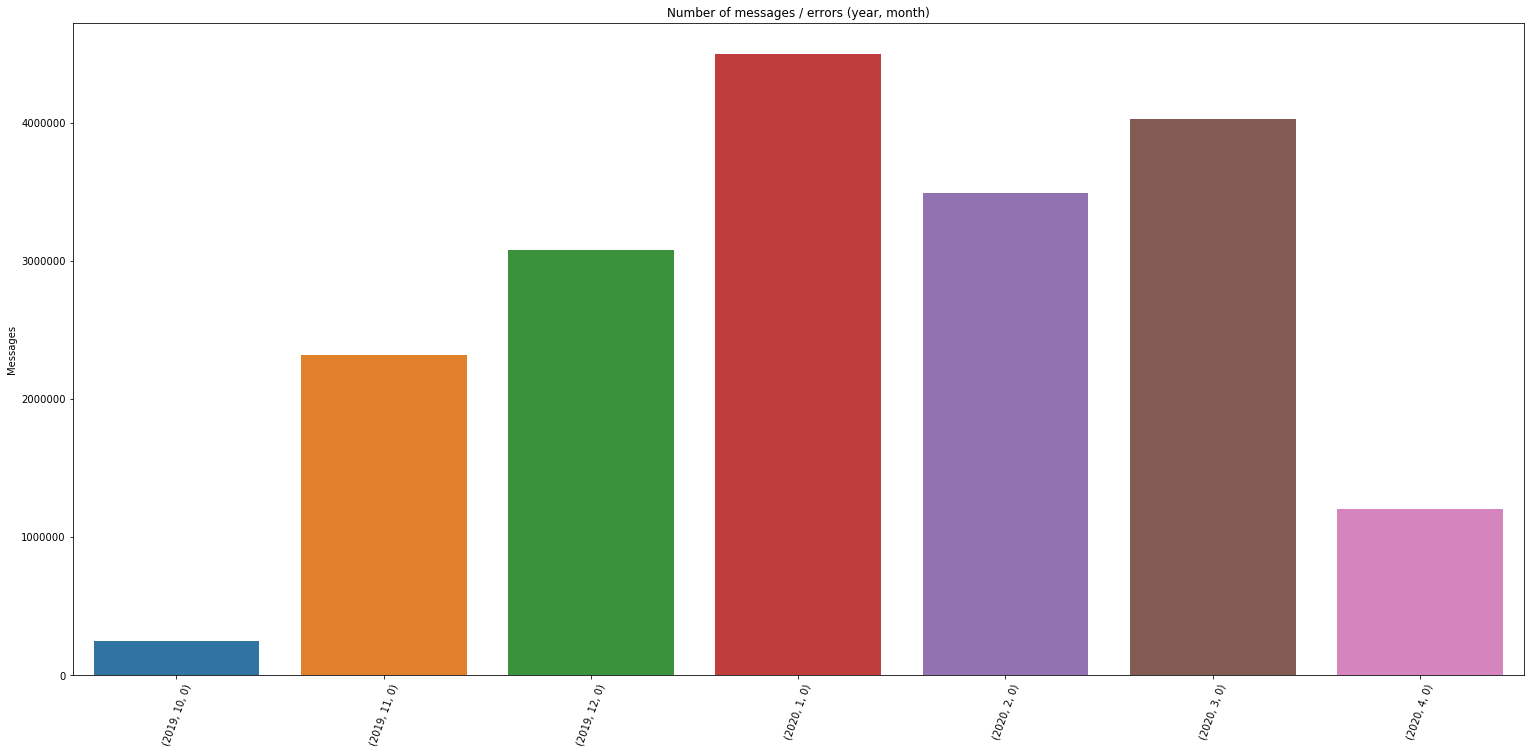

In [8]:
#pd.unique(pfall.outcome)
#dataall
#encodedpfall
#mdcountsall

#mdcountsall = pfall.groupby(['year','month','day'])['outcome'].count()
#mdcountsall = pfall[(pfall['month'] == 2) & (pfall['day'] == 20)].groupby(['year','month','day','hour','outcome'])['outcome'].count()
#mdcountsall = pfall[(pfall['month'] == 3)].groupby(['year','month','day','outcome'])['outcome'].count()
#mdcountsall = pfall.groupby(['year','month','outcome'])['outcome'].count()

#mdcountsall = pfall[(pfall['outcome'] == 0) & (pfall['month'] == 3)].groupby(['year','month','day','outcome'])['outcome'].count()

mdcountsall = pfall[(pfall['outcome'] == 0) ].groupby(['year','month','outcome'])['outcome'].count()

#filter results
#mdcountsall = mdcountsall[mdcountsall > 150000]

#.reset_index()

#& (pfall['outcome'] > 15000)
#md = md[md['outcome'] > 15000].reset_index()

#mdcountsall = dataall[dataall['outcome'] == 1].groupby(['year','month','day'])['outcome'].count()
#mdcountsall = dataall[dataall['outcome'] == 1].groupby(['year','month','day'])['outcome'].count().apply(lambda x: x / 175000 * 3500)

# Set the width and height of the figure
plt.figure(figsize=(26,12))

# Add title
#plt.title("Number of messages with errors (year, month, day)")
#plt.title("Number of messages (year, month, day)")
plt.title("Number of messages / errors (year, month)")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
g = sns.barplot(x=mdcountsall.index, y=mdcountsall)
#g.set_xticklabels(g.get_xticklabels(), rotation=70)
label(g,1,70)

# Add label for vertical axis
plt.ylabel("Messages")
#mdcountsall.head()


In [ ]:
md = pfall[(pfall['outcome'] == 0) & (pfall['month'] == 3)].groupby(['year','month','day','outcome'])['outcome'].count()

data2 = pd.DataFrame()
data2['date'] =   abc(md)
#data2['outcome'] =  md.reset_index()['outcome'].astype(int) 

#plt.figure(figsize=(16,6))

#sns.heatmap(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.barplot(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.scatterplot(x=data2['date'], y=data2['CINBOUNDSIZE'], data=data2)
#label(ax,4,90)
#data2
#md.reset_index()['outcome'].astype(int) 
md['outcome']

In [93]:
#dataall.groupby(['year','month','day', 'outcome'])['outcome'].count()[2019,11]
#dataall.groupby(['year','month','day'])['outcome'].count()

md=pfall.groupby(['year','month','day','hour'])['outcome'].count()
#mdcountsall.reset_index(drop=True,inplace=True)

#md['outcome'] = md['outcome'].astype(int)
#md=md[md['outcome']  > '10000']

md.index =   ymdh(md)

md = md.reset_index()
#mdcountsall.index = mdcountsall['level_0']
md.head()
md = md[md['outcome'] > 15000].reset_index()

md

level_0          index  outcome
0        154   2019-11-4-14    18940
1        363   2019-11-13-7    15193
2        483   2019-11-18-7    24436
3        580   2019-11-22-8    22422
4        704  2019-11-27-12    22804
..       ...            ...      ...
97      3713   2020-3-31-21    23370
98      3714   2020-3-31-22    20209
99      3723     2020-4-1-7    19188
100     3736    2020-4-1-20    16035
101     3761    2020-4-2-21    15042

[102 rows x 3 columns]

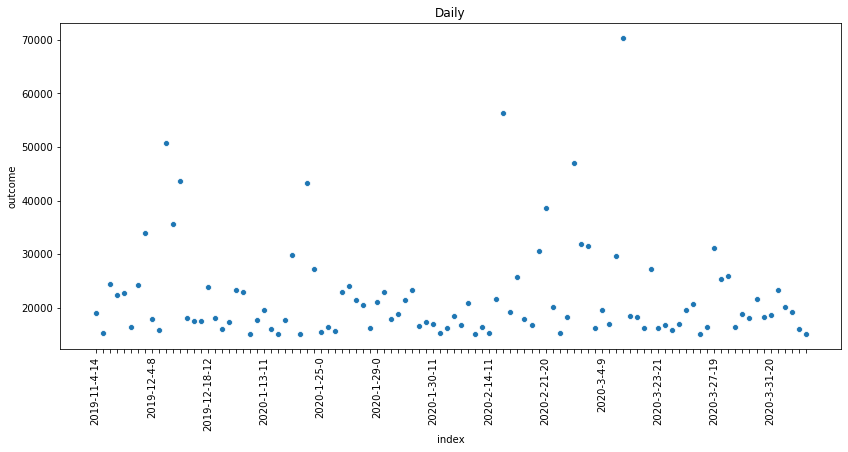

In [69]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

# Add title
plt.title("Daily")

# Line chart showing daily global streams of each song 
#mdcountsall=pfall.groupby(['year','month','day'])['outcome'].count()
#mdcountsall.reset_index
#g = sns.lineplot(x=md.index, y=md['outcome'])
#ax = sns.lineplot(x=md['index'], y=md['outcome'])

ax = sns.scatterplot(x=md['index'], y=md['outcome'], data=md)

#g.set_xticklabels(g.get_xticklabels(), rotation=90)
#sns.lineplot(x=mdcountsall.index, y=mdcountsall)
#sns.lineplot(data=mdcountsall)
#sns.distplot(pfall.groupby(['year','month','day'])['outcome'].count())

# Add label for vertical axis
#plt.ylabel("Messages")
label(ax,8,90)

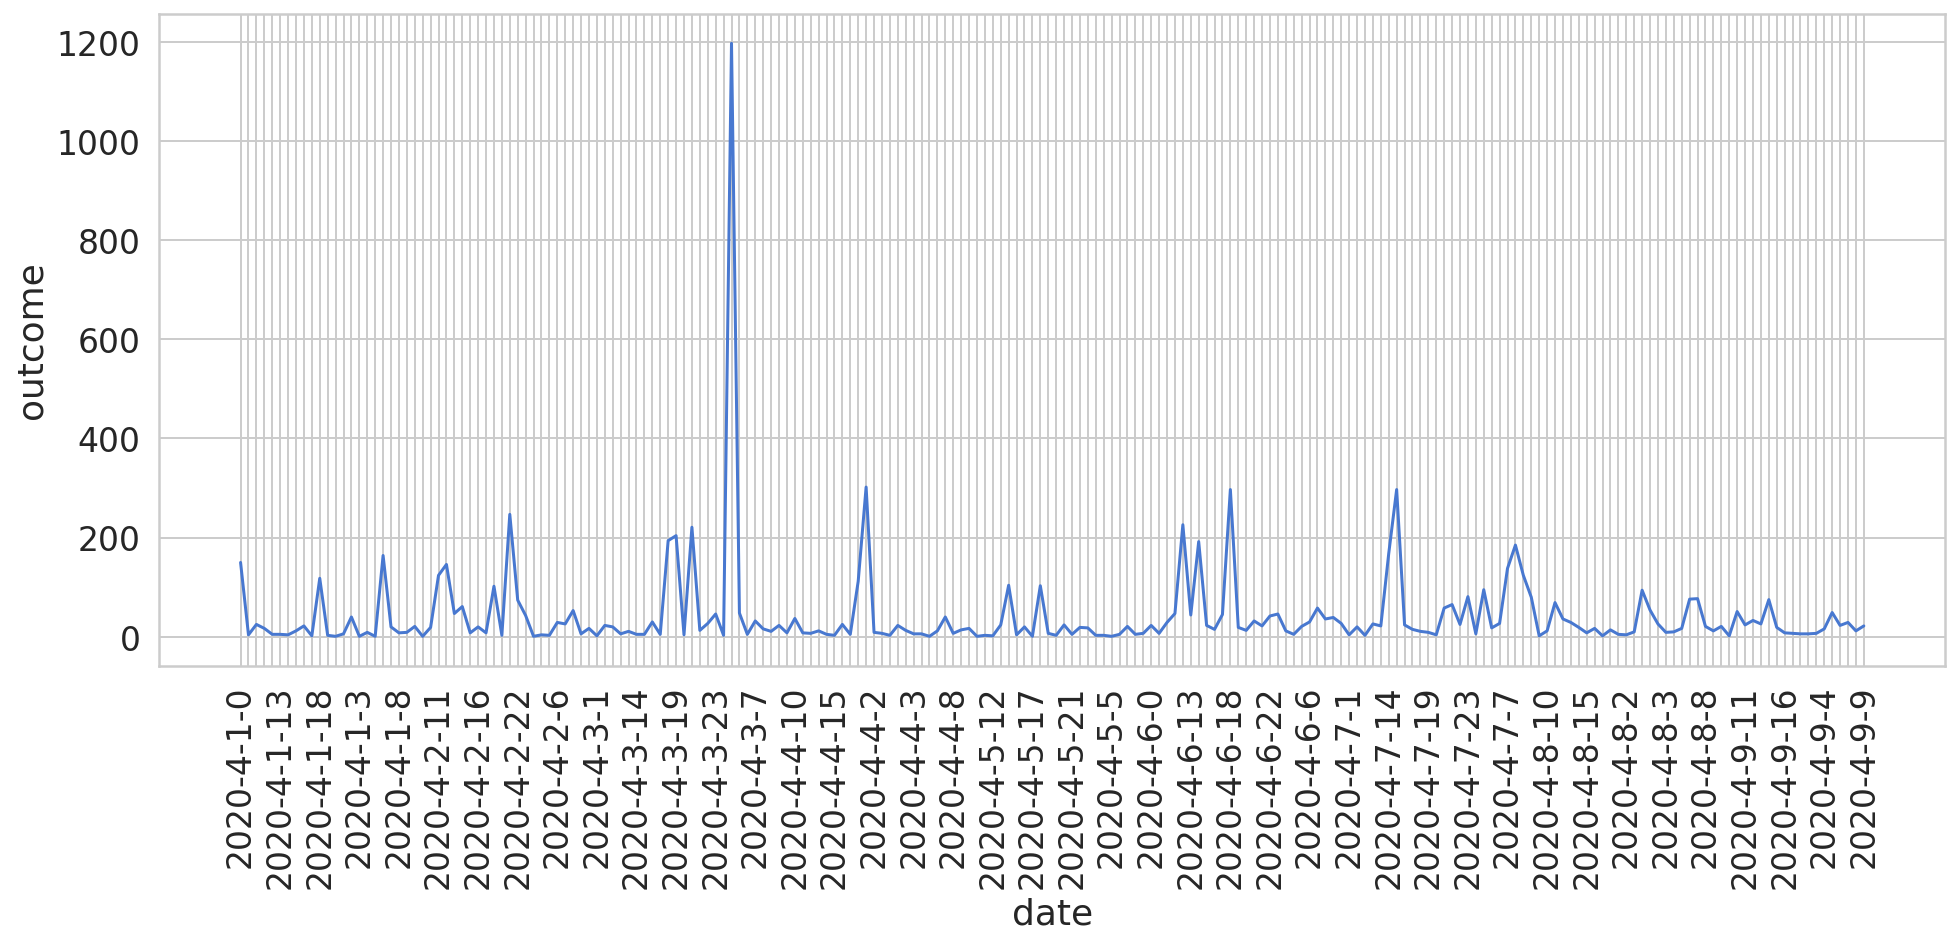

In [58]:
plt.figure(figsize=(16,6))

#sns.heatmap(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.barplot(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.scatterplot(x=data2['date'], y=data2['outcome'], data=data2)
ax = sns.lineplot(x=data2['date'], y=data2['outcome'], data=data2)

# Histogram 
#ax = sns.distplot(a=data2['outcome'], kde=False)
# kernel density estimate (KDE) 
#ax = sns.kdeplot(data=data2['outcome'], shade=True)

#label(ax,80,45)
label(ax,5,90)

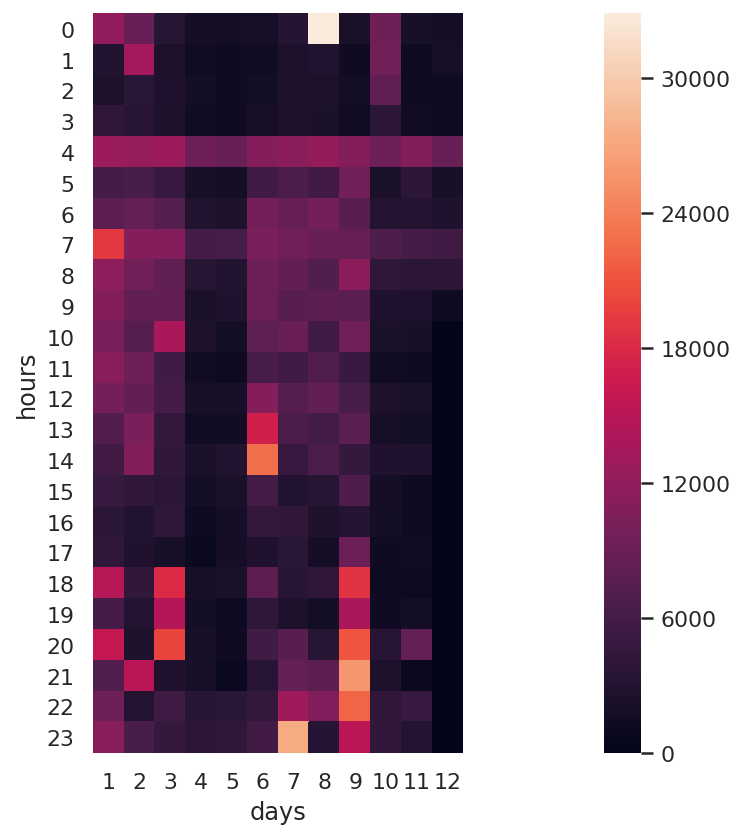

In [138]:
data2 = createData(pfall,4,2) 
piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
createHeatmap(piv)
#piv

# Unterteilung

In [118]:
#mdcountsall.head()
#a = mdcountsall.index.get_level_values(0).astype(str)
#mdcountsall[0,1,2019]
#pd.unique(mdcountsall[1].index.get_level_values(0))
#mdcountsall[0,2].count()
result = pfall.groupby(['CSENDERENDPOINTID']).count()
data2 = pd.DataFrame()
data2['date'] = result.index.get_level_values(0).astype(str)
data2['outcome'] =  result['outcome'].astype(int)
topsender =  data2[data2['outcome'] > 500000].sort_values('outcome').reset_index()
topsender.columns = ['index', 'CSENDERENDPOINTID', 'outcome']

In [131]:
#topsender
#len(pfall['CSENDERENDPOINTID']==2136)
#pfall[pfall['CSENDERENDPOINTID'].isin(topsender['date'][0])]
#pfall[pfall['CSENDERENDPOINTID']==2137]
#pfall.head()

#pfall1 = pfall[pfall['CSENDERENDPOINTID'].isin(topsender['date'])]
pfall1 = pfall[pfall['CSENDERENDPOINTID']==int(topsender.iloc[7]['CSENDERENDPOINTID'])]
#pfall1
#topsender.iloc[7]['CSENDERENDPOINTID']

In [172]:
topsender.iloc[7]

index                   2137
CSENDERENDPOINTID       2137
outcome              5055494
Name: 7, dtype: object

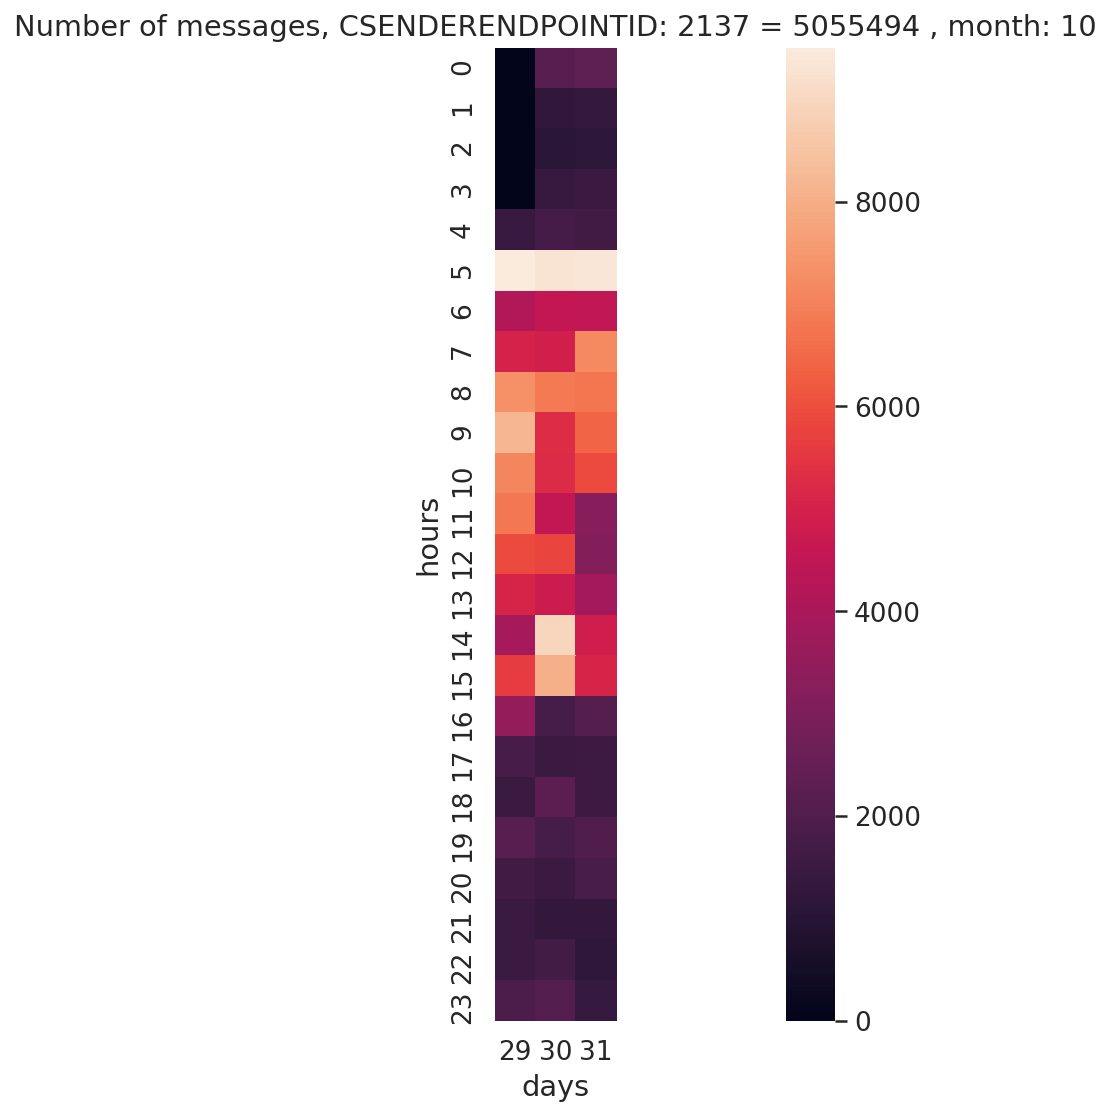

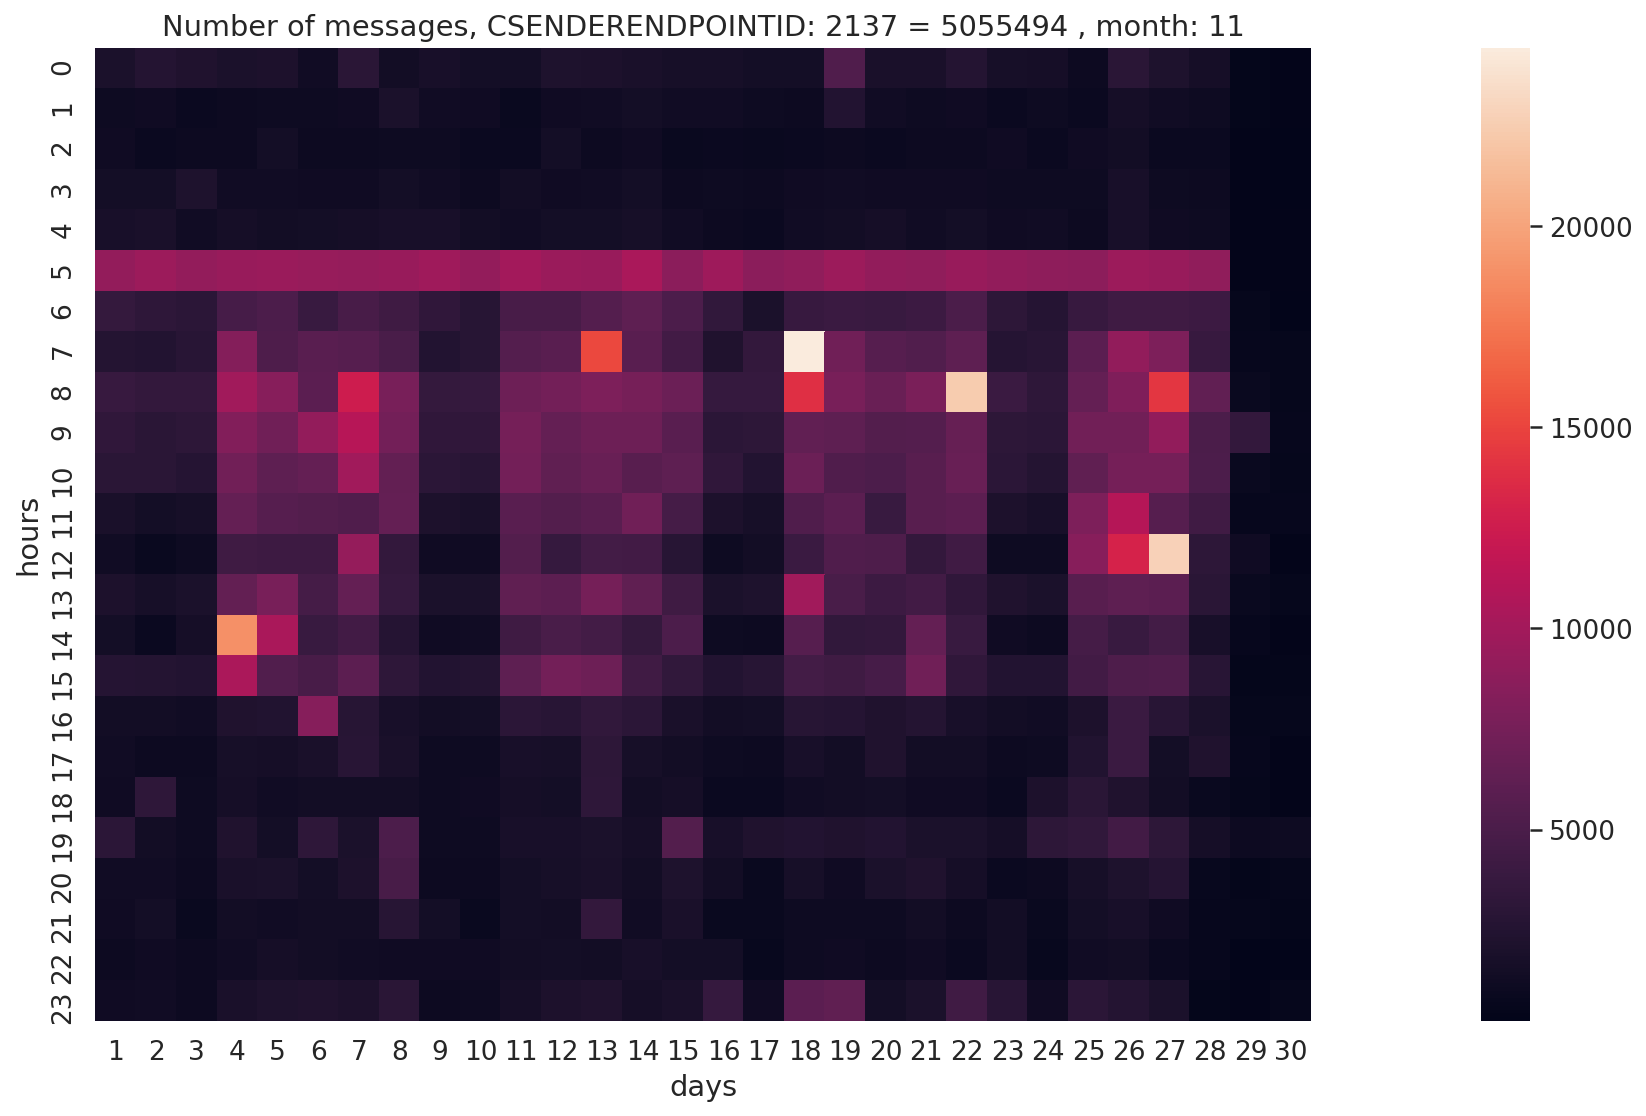

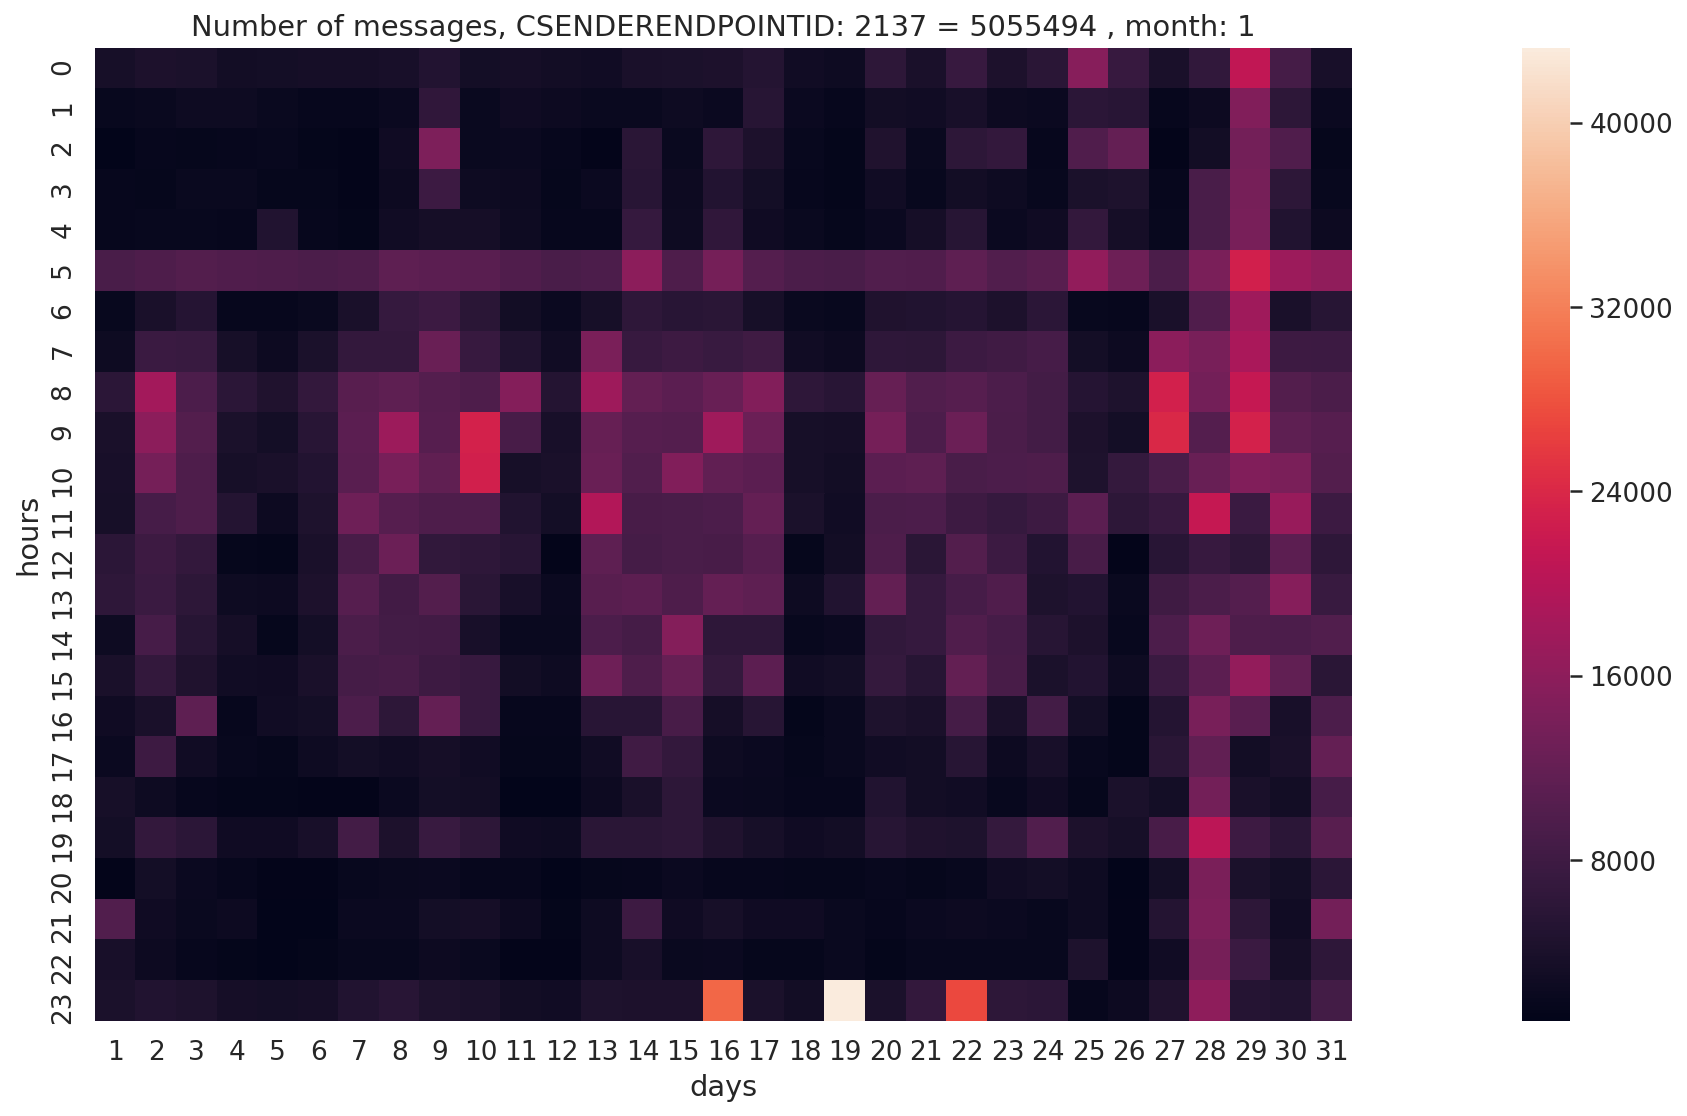

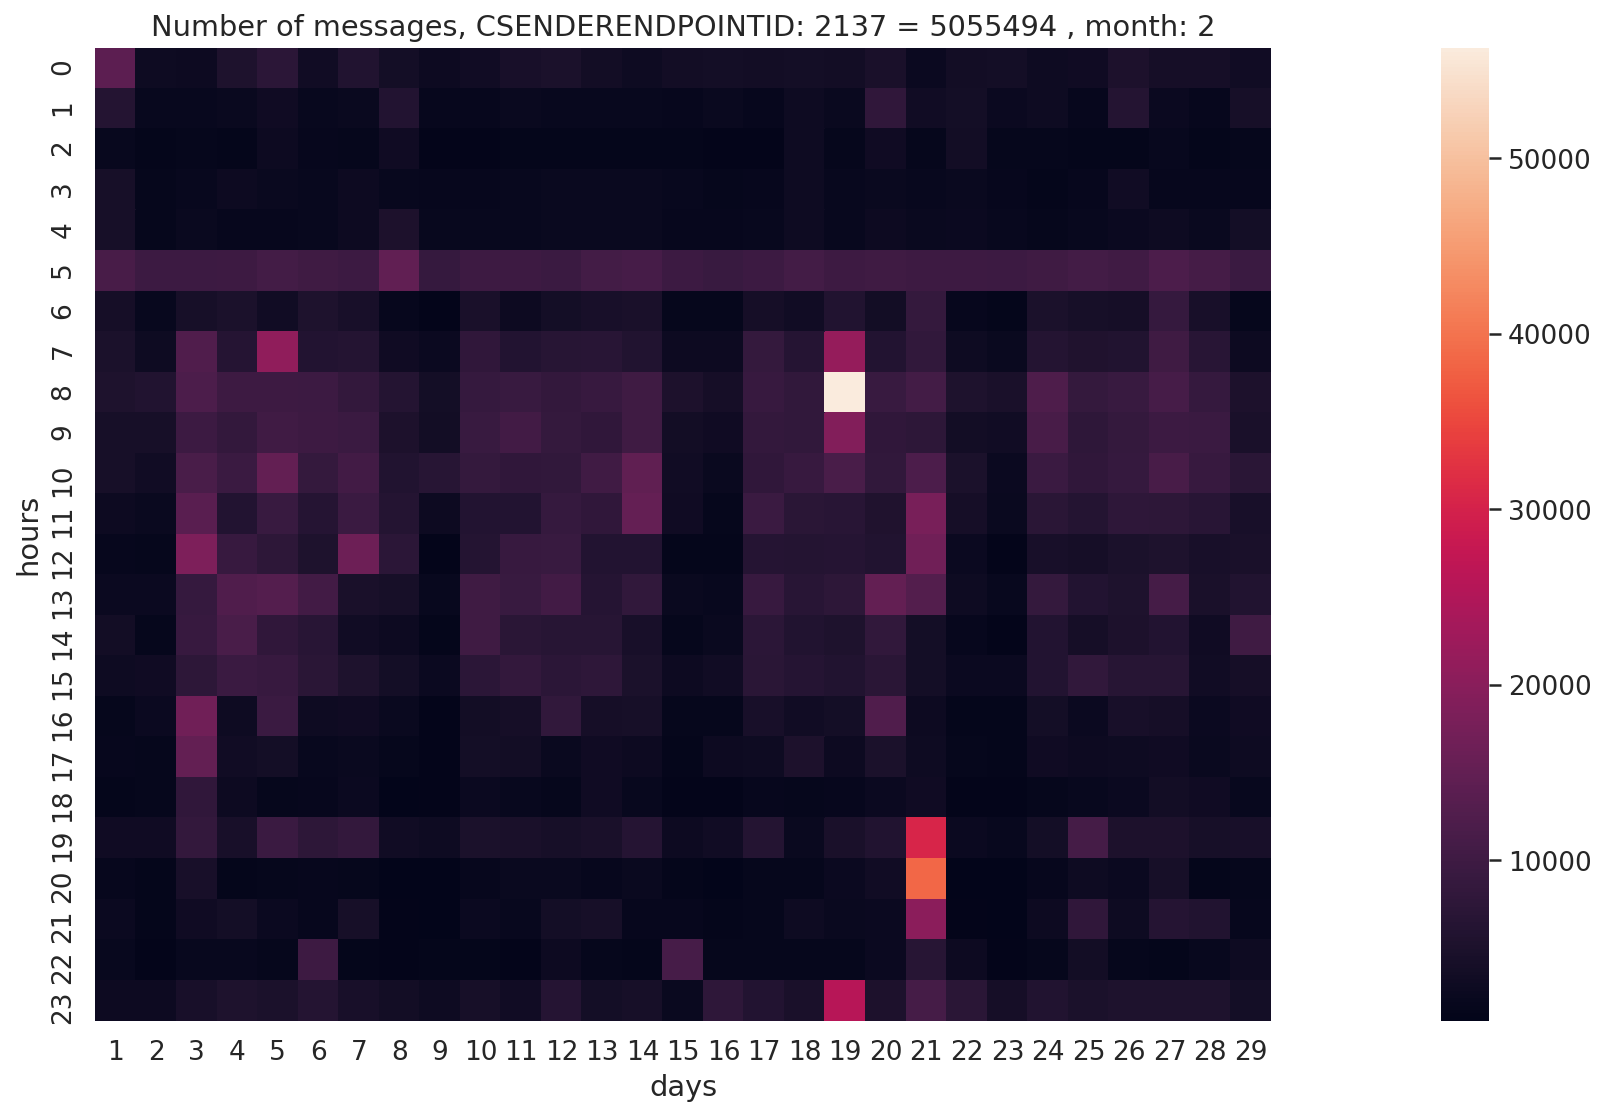

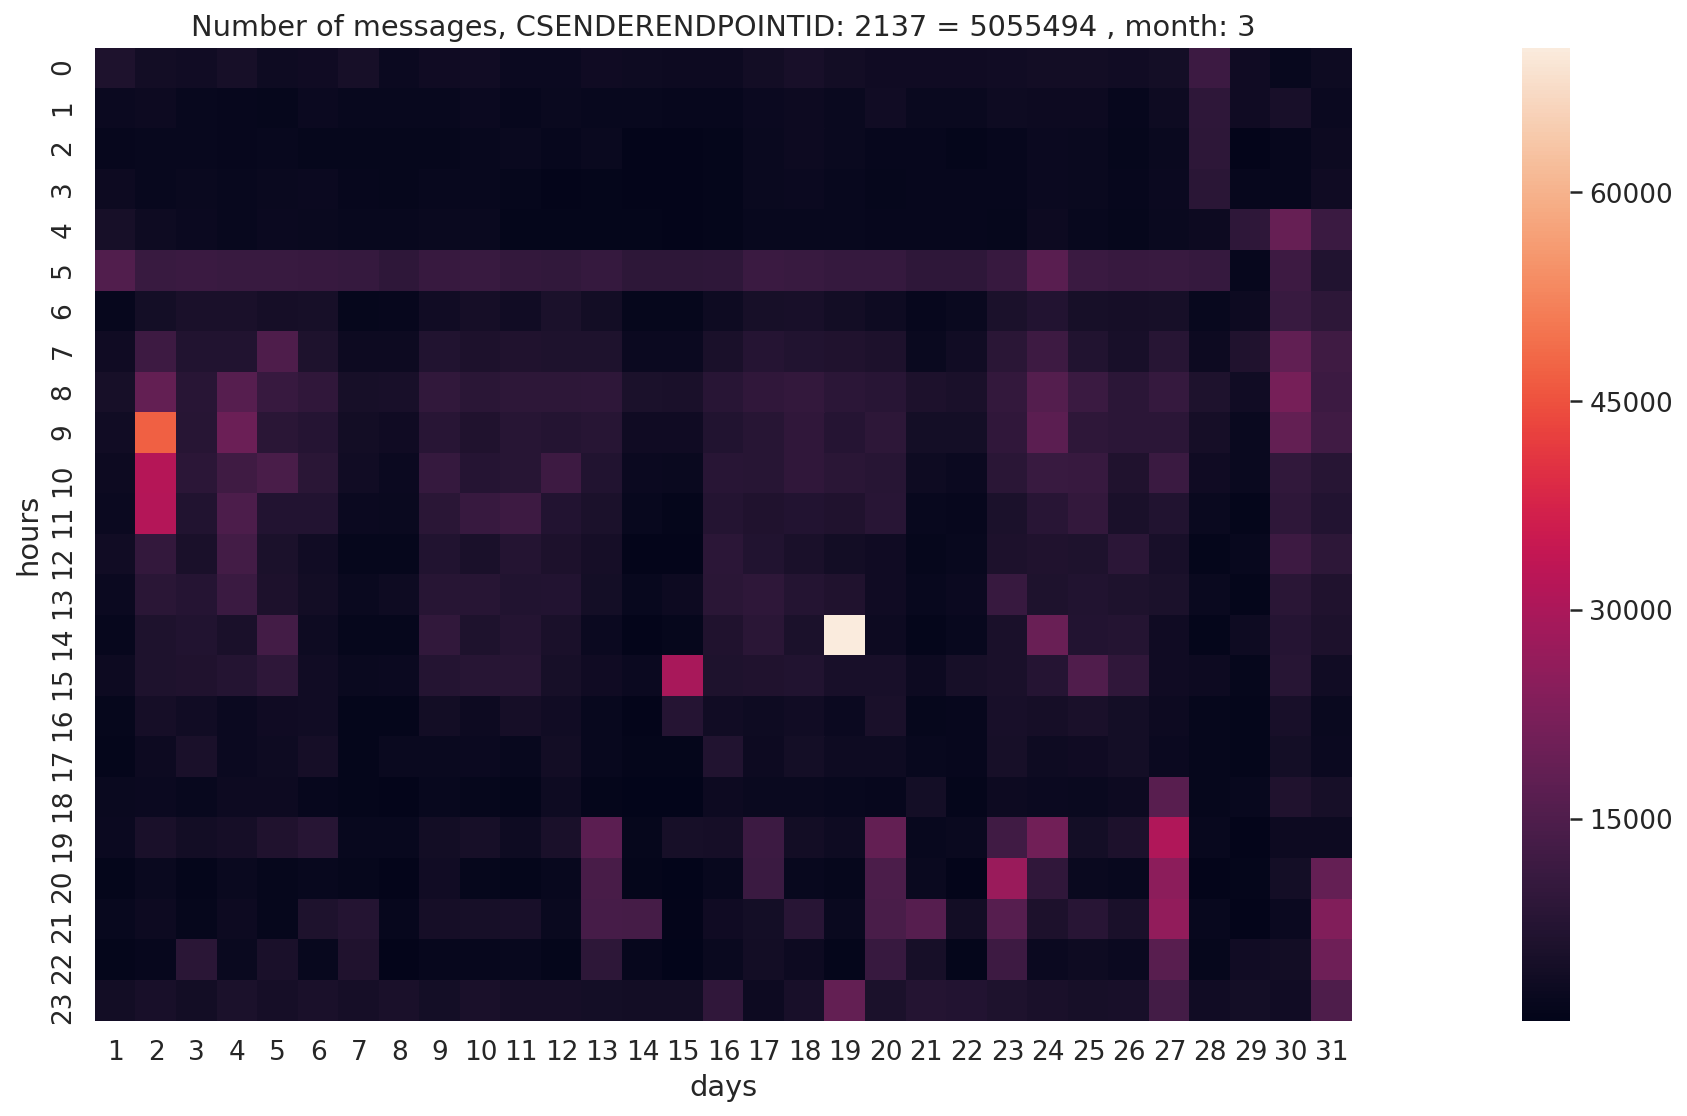

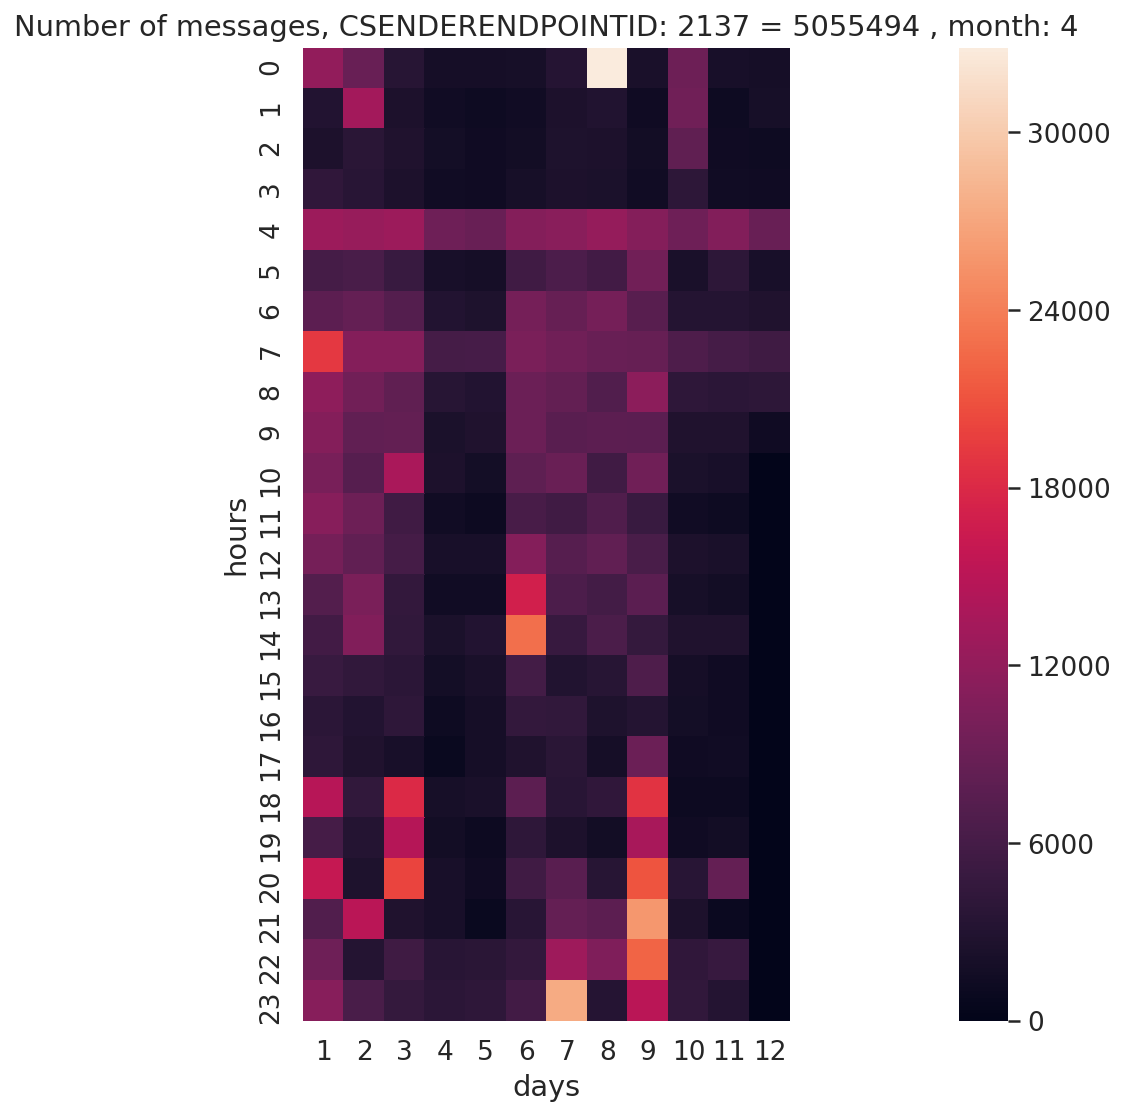

In [182]:

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
month = 4
category = 'messages'
months = [10,11,1,2,3,4]

for month in months:
    data2 = createData(pfall,month,2)
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    titlestring = "Number of "+ category + ": CSENDERENDPOINTID: " + str(topsender.iloc[7]['CSENDERENDPOINTID']) + " = " + str(topsender.iloc[7]['outcome']) + " , month: " + str(month) 
    createHeatmap(piv, titlestring)

In [ ]:
df.set_index(get_ymdh_string(pfall['year'].map(str),pfall['month'].map(str),pfall['day'].map(str),pfall['hour'].map(str)), inplace=True)

In [134]:
pfall['CSENDERENDPOINTID'].head()

0     940
1    1715
2    1715
3    1715
4    2300
Name: CSENDERENDPOINTID, dtype: int64

In [9]:
mdcountsall = pfall.groupby(['outcome','CSENDERENDPOINTID','year','month','day','hour'])['outcome'].count()

pfall.groupby(['CSENDERENDPOINTID']).count()

#a,b,c,d = get_ymdh(mdcountsall)
#data2 = pd.DataFrame()
#data2['date'] = get_ymdh_string(a,b,c,d)
#data2['outcome'] =  mdcountsall.reset_index()['outcome'].astype(int) 

CGLOBALMESSAGEID  CMESSAGETAT2  CSLATAT  CINBOUNDSIZE  \
CSENDERENDPOINTID                                                          
0                               374           374      374           374   
1                                74            74       74            74   
2                               153           153      153           153   
3                               704           704      704           704   
4                                 1             1        1             1   
...                             ...           ...      ...           ...   
2390                            546           546      546           546   
2391                              4             4        4             4   
2392                           1264          1264     1264          1264   
2393                              2             2        2             2   
2394                              2             2        2             2   

                   outcome  CSERVICE  CRECEIVERPROTOCOL  CSENDERPROTOCOL  \
CSENDERENDPOINTID                                                          
0                      374       374                374              374   
1                       74        74                 74               74   
2                      153       153                153              153   
3                      704       704                704              704   
4                        1         1                  1                1   
...                    ...       ...                ...              ...   
2390                   546       546                546              546   
2391                     4         4                  4                4   
2392                  1264      1264               1264             1264   
2393                     2         2                  2                2   
2394                     2         2                  2                2   

                   CRECEIVERENDPOINTID  CSTATUS  year  month   day  hour  \
CSENDERENDPOINTID                                                          
0                                  374      374   374    374   374   374   
1                                   74       74    74     74    74    74   
2                                  153      153   153    153   153   153   
3                                  704      704   704    704   704   704   
4                                    1        1     1      1     1     1   
...                                ...      ...   ...    ...   ...   ...   
2390                               546      546   546    546   546   546   
2391                                 4        4     4      4     4     4   
2392                              1264     1264  1264   1264  1264  1264   
2393                                 2        2     2      2     2     2   
2394                                 2        2     2      2     2     2   

                   minute  second  microsecond  
CSENDERENDPOINTID                               
0                     374     374          374  
1                      74      74           74  
2                     153     153          153  
3                     704     704          704  
4                       1       1            1  
...                   ...     ...          ...  
2390                  546     546          546  
2391                    4       4            4  
2392                 1264    1264         1264  
2393                    2       2            2  
2394                    2       2            2  

[2395 rows x 17 columns]

index                   2137
CSENDERENDPOINTID       2137
outcome              5055494
Name: 7, dtype: object

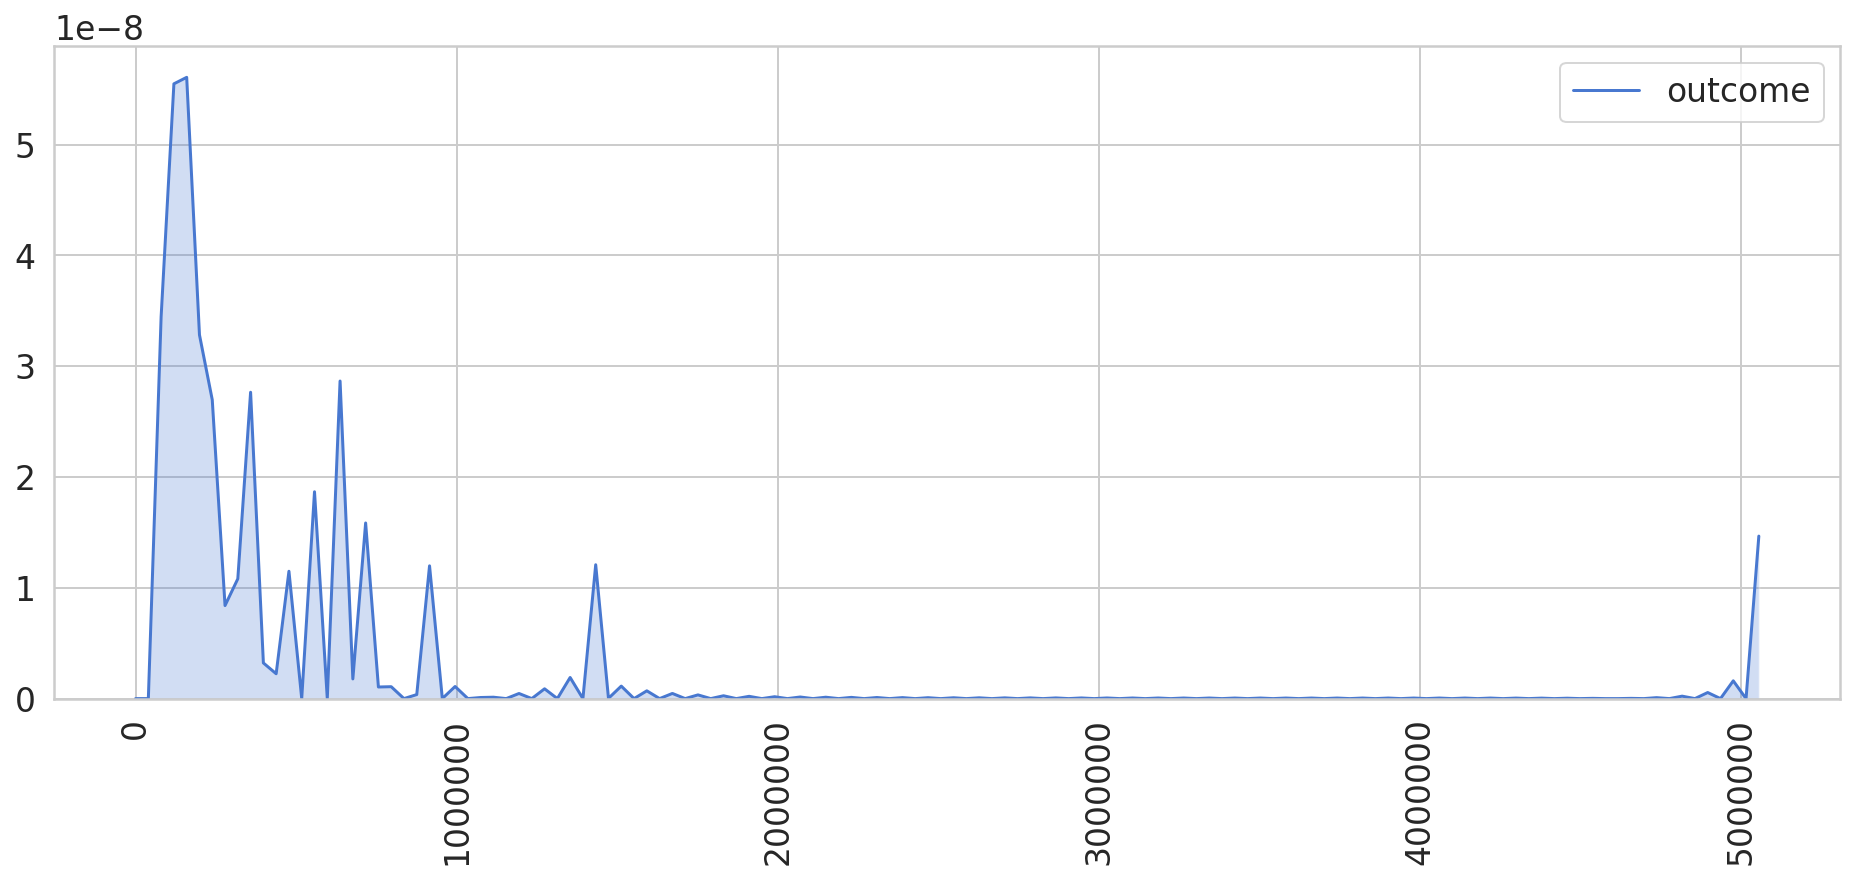

In [125]:
plt.figure(figsize=(16,6))

#sns.heatmap(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.barplot(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.scatterplot(x=data2['date'], y=data2['outcome'], data=data2)
#ax = sns.lineplot(x=data2['date'], y=data2['outcome'], data=data2)

# Histogram 
#ax = sns.distplot(a=data2['outcome'], kde=False)
# kernel density estimate (KDE) 
ax = sns.kdeplot(data=data2['outcome'], shade=True)

#label(ax,80,45)
label(ax,1,90)


topsender.iloc[7]

# Time Series Anomaly Detection with LSTM Autoencoders 

In [ ]:
#install
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128"   
!pip install gdown
!pip install tensorflow

In [ ]:
# test data
!gdown --id 10vdMg_RazoIatwrT7azKFX4P02OebU76 --output spx.csv

In [12]:
# test data
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

In [48]:
#old trial
type(data2)
df = pd.DataFrame()
df['close'] = data2['outcome']
df.set_index(data2['date'], inplace=True)

In [9]:
## 3
#pfall['CMESSAGETAT2'].head()
#pfall.head()
#data3 = createDataAno(outcome)
df = pd.DataFrame()
df['close'] = pfall['CMESSAGETAT2']
#df.set_index(data3['date'], inplace=True)
df.set_index(get_ymdh_string(pfall['year'].map(str),pfall['month'].map(str),pfall['day'].map(str),pfall['hour'].map(str)), inplace=True)

In [ ]:
#testing
df = df.groupby(df.index).sum()
df.head()

#len(df) / 24

In [ ]:
#testing : plot
plt.plot(df, label='close price')
legend();

Time Series Anomaly Detection with LSTM Autoencoders

In [183]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [184]:
# functions

OUTCOME = 'close'

TIME_STEPS = 24
#TIME_STEPS = 30
#TIME_STEPS = 720
#TIME_STEPS = 168
#TIME_STEPS = 336

# setup data (current)
def createDataframe(pfall) :
    data3 = createData(pfall,0,2)
    df = pd.DataFrame()
    df[OUTCOME] = data3['outcome']
    df.set_index(data3['date'], inplace=True)
    return df

def getTrainAndTest(df,TRAIN_SIZE) :
    train_size = int(len(df) * TRAIN_SIZE)
    test_size = len(df) - train_size
    train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
    print("train.shape: ",train.shape, "test.shape: ", test.shape)
    return train, test

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def initmodel():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64, 
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
    model.compile(loss='mae', optimizer='adam')
    return model

def testScoreDF(model, THRESHOLD) : 
    X_test_pred = model.predict(X_test)
    test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

    test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
    test_score_df['loss'] = test_mae_loss
    test_score_df['threshold'] = THRESHOLD
    test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
    test_score_df[OUTCOME] = test[TIME_STEPS:][OUTCOME]
    return test_score_df

In [190]:
df = createDataframe(pfall)
train, test = getTrainAndTest(df,0.95)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[[OUTCOME]])
train[OUTCOME] = scaler.transform(train[[OUTCOME]])
test[OUTCOME] = scaler.transform(test[[OUTCOME]])

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[[OUTCOME]], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[[OUTCOME]], test.close, TIME_STEPS)
print(X_train.shape)

#model = initmodel()

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

train.shape:  (3790, 1) test.shape:  (200, 1)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(3766, 24, 1)
Train on 3389 samples, validate on 377 samples
Epoch 1/10
3389/3389 [==============================] - 3s 897us/sample - loss: 0.3979 - val_loss: 0.6202
Epoch 2/10
3389/3389 [==============================] - 3s 843us/sample - loss: 0.3950 - val_loss: 0.6183
Epoch 3/10
3389/3389 [==============================] - 3s 861us/sample - loss: 0.3954 - val_loss: 0.6205
Epoch 4/10
3389/3389 [==============================] - 3s 859us/sample - loss: 0.3929 - val_loss: 0.6104
Epoch 5/10
3389/3389 [==============================] - 3s 845us/sample - loss: 0.3916 - val_loss: 0.6107
Epoch 6/10
3389/3389 [==============================] - 3s 844us/sample - loss: 0.3902 - val_loss: 0.6118
Epoch 7/10
3389/3389 [==============================] - 3s 852us/sample - loss: 0.3885 - val_loss: 0.6133
Epoch 8/10
3389/3389 [==============================] - 3s 844us/sample - loss: 0.3875 - val_loss: 0.6007
Epoch 9/10
3389/3389 [==============================] - 3s 839us/sample - loss: 0.3863 - va

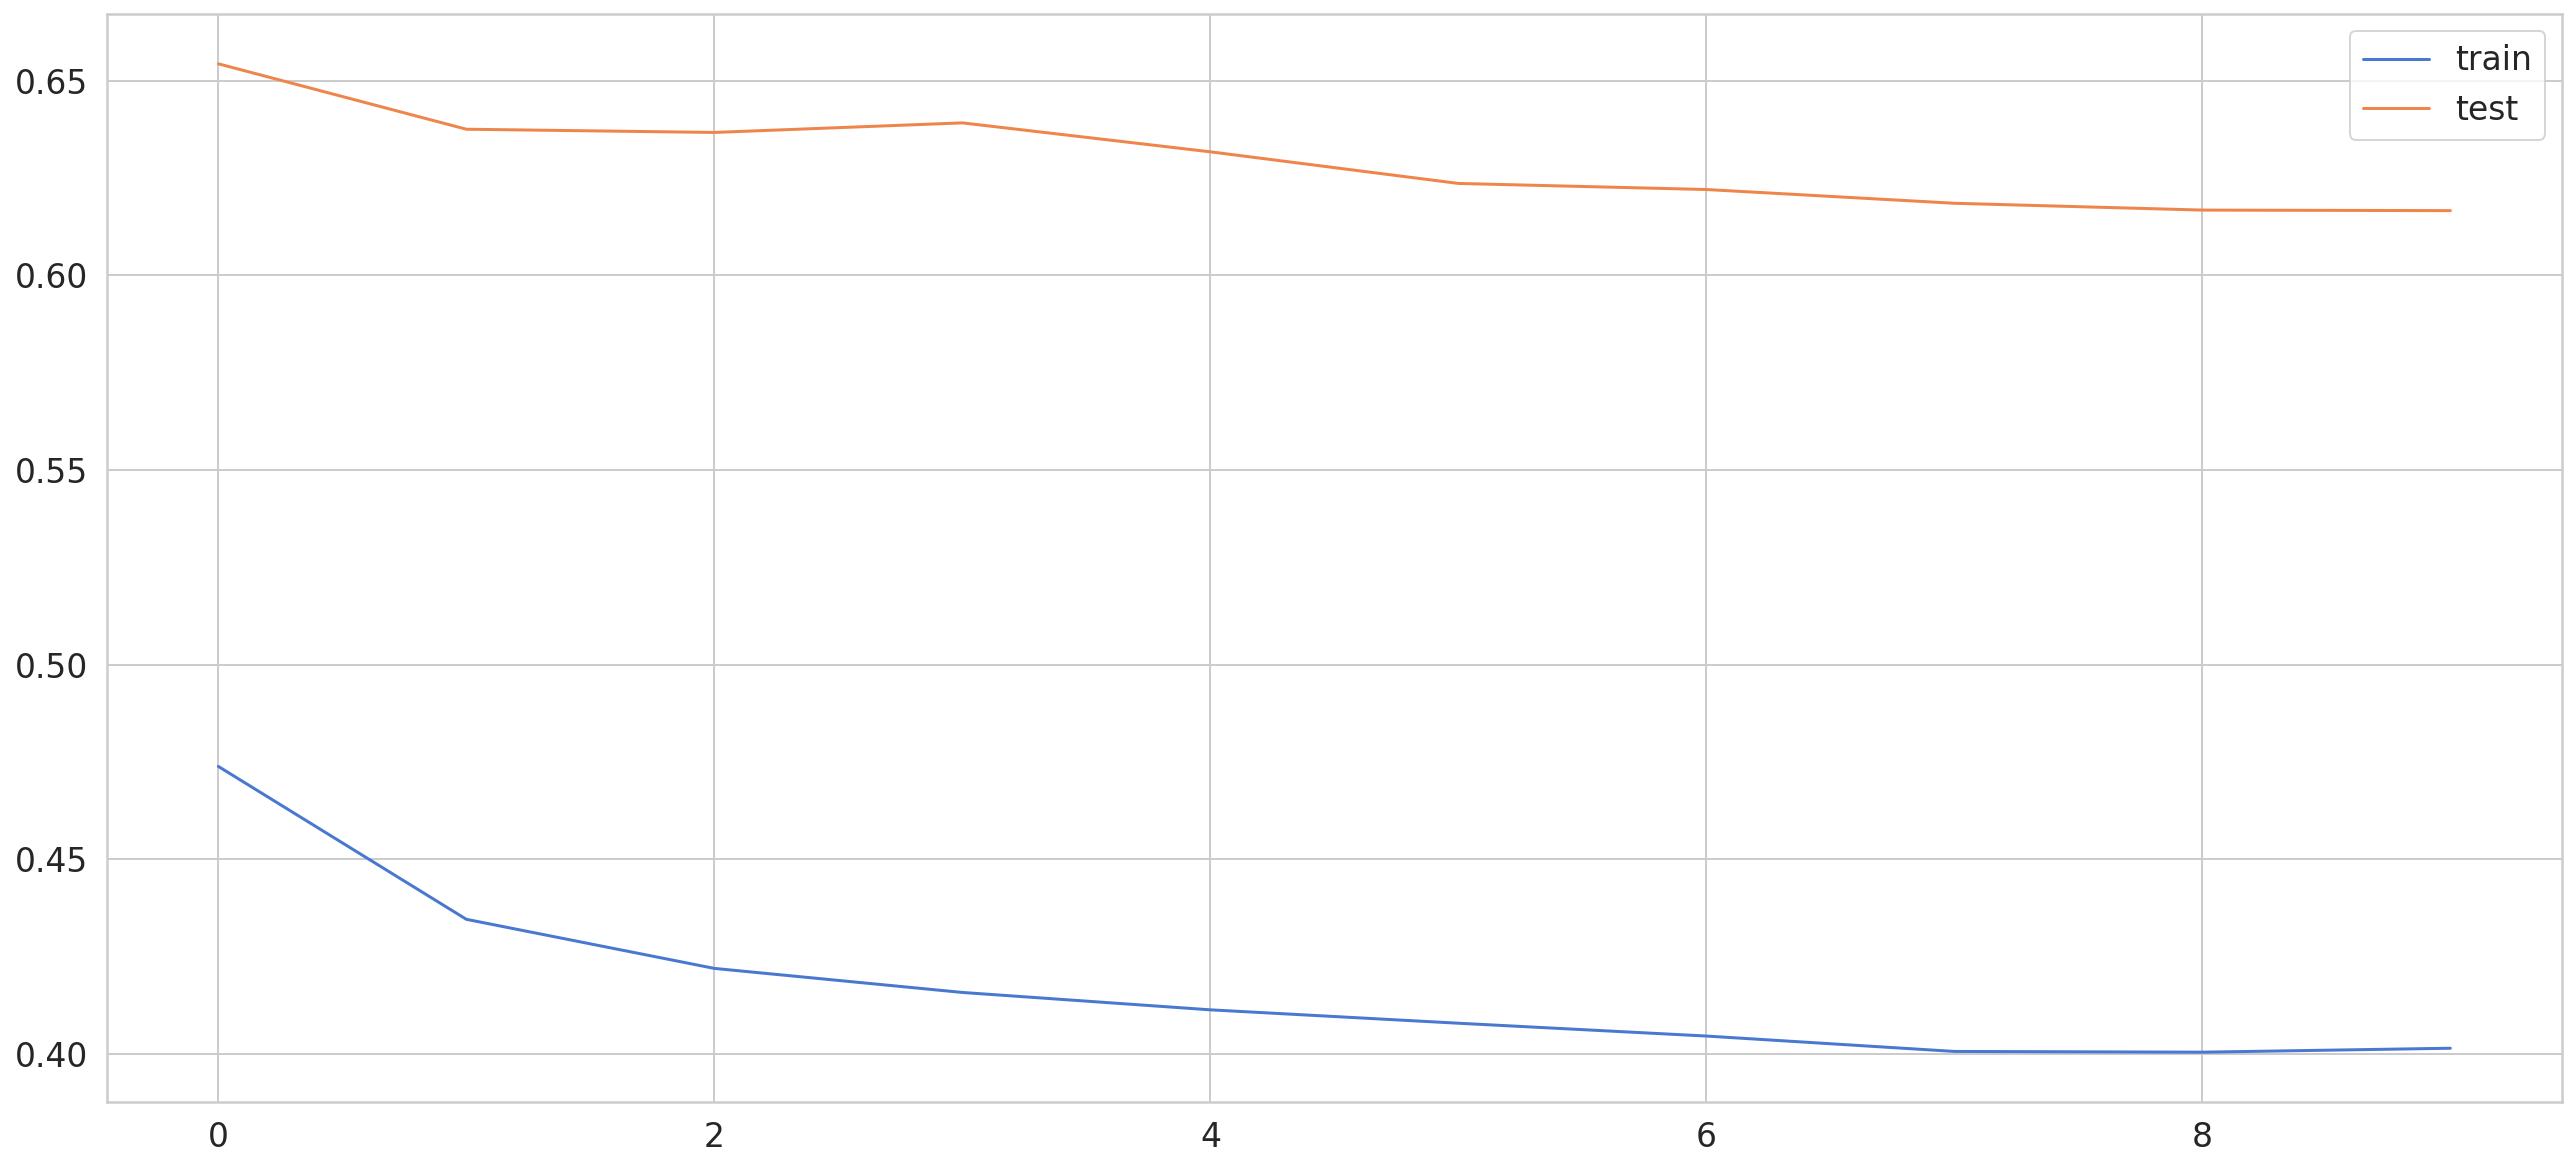

In [70]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

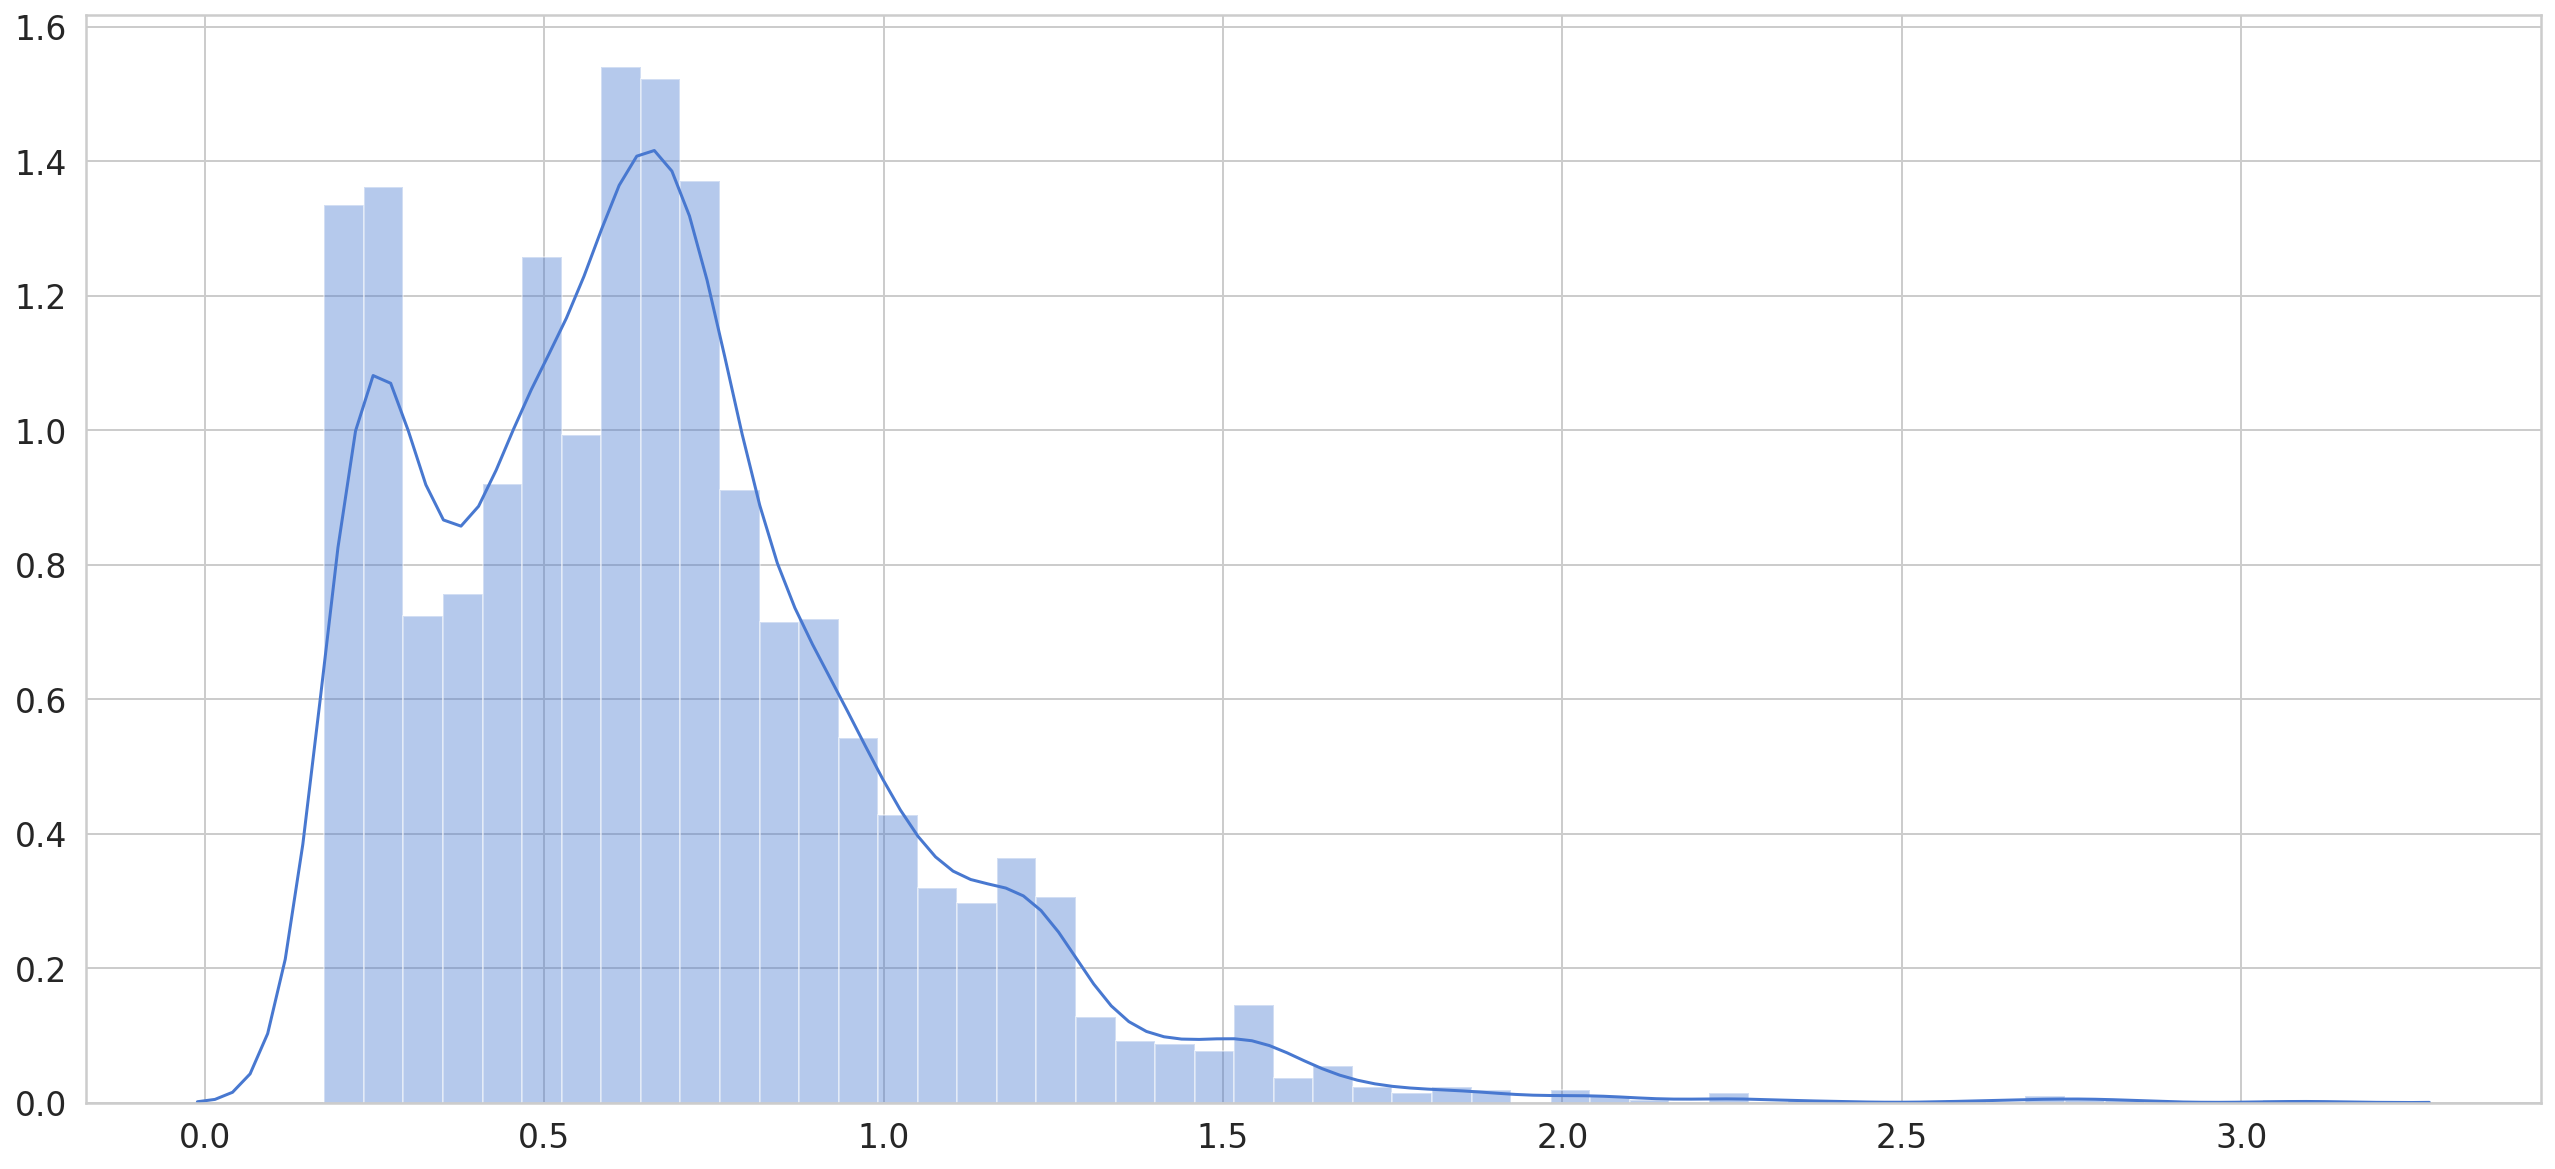

In [86]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [186]:
test_score_df = testScoreDF(model, 1.5)
anomalies     = test_score_df[test_score_df.anomaly == True]

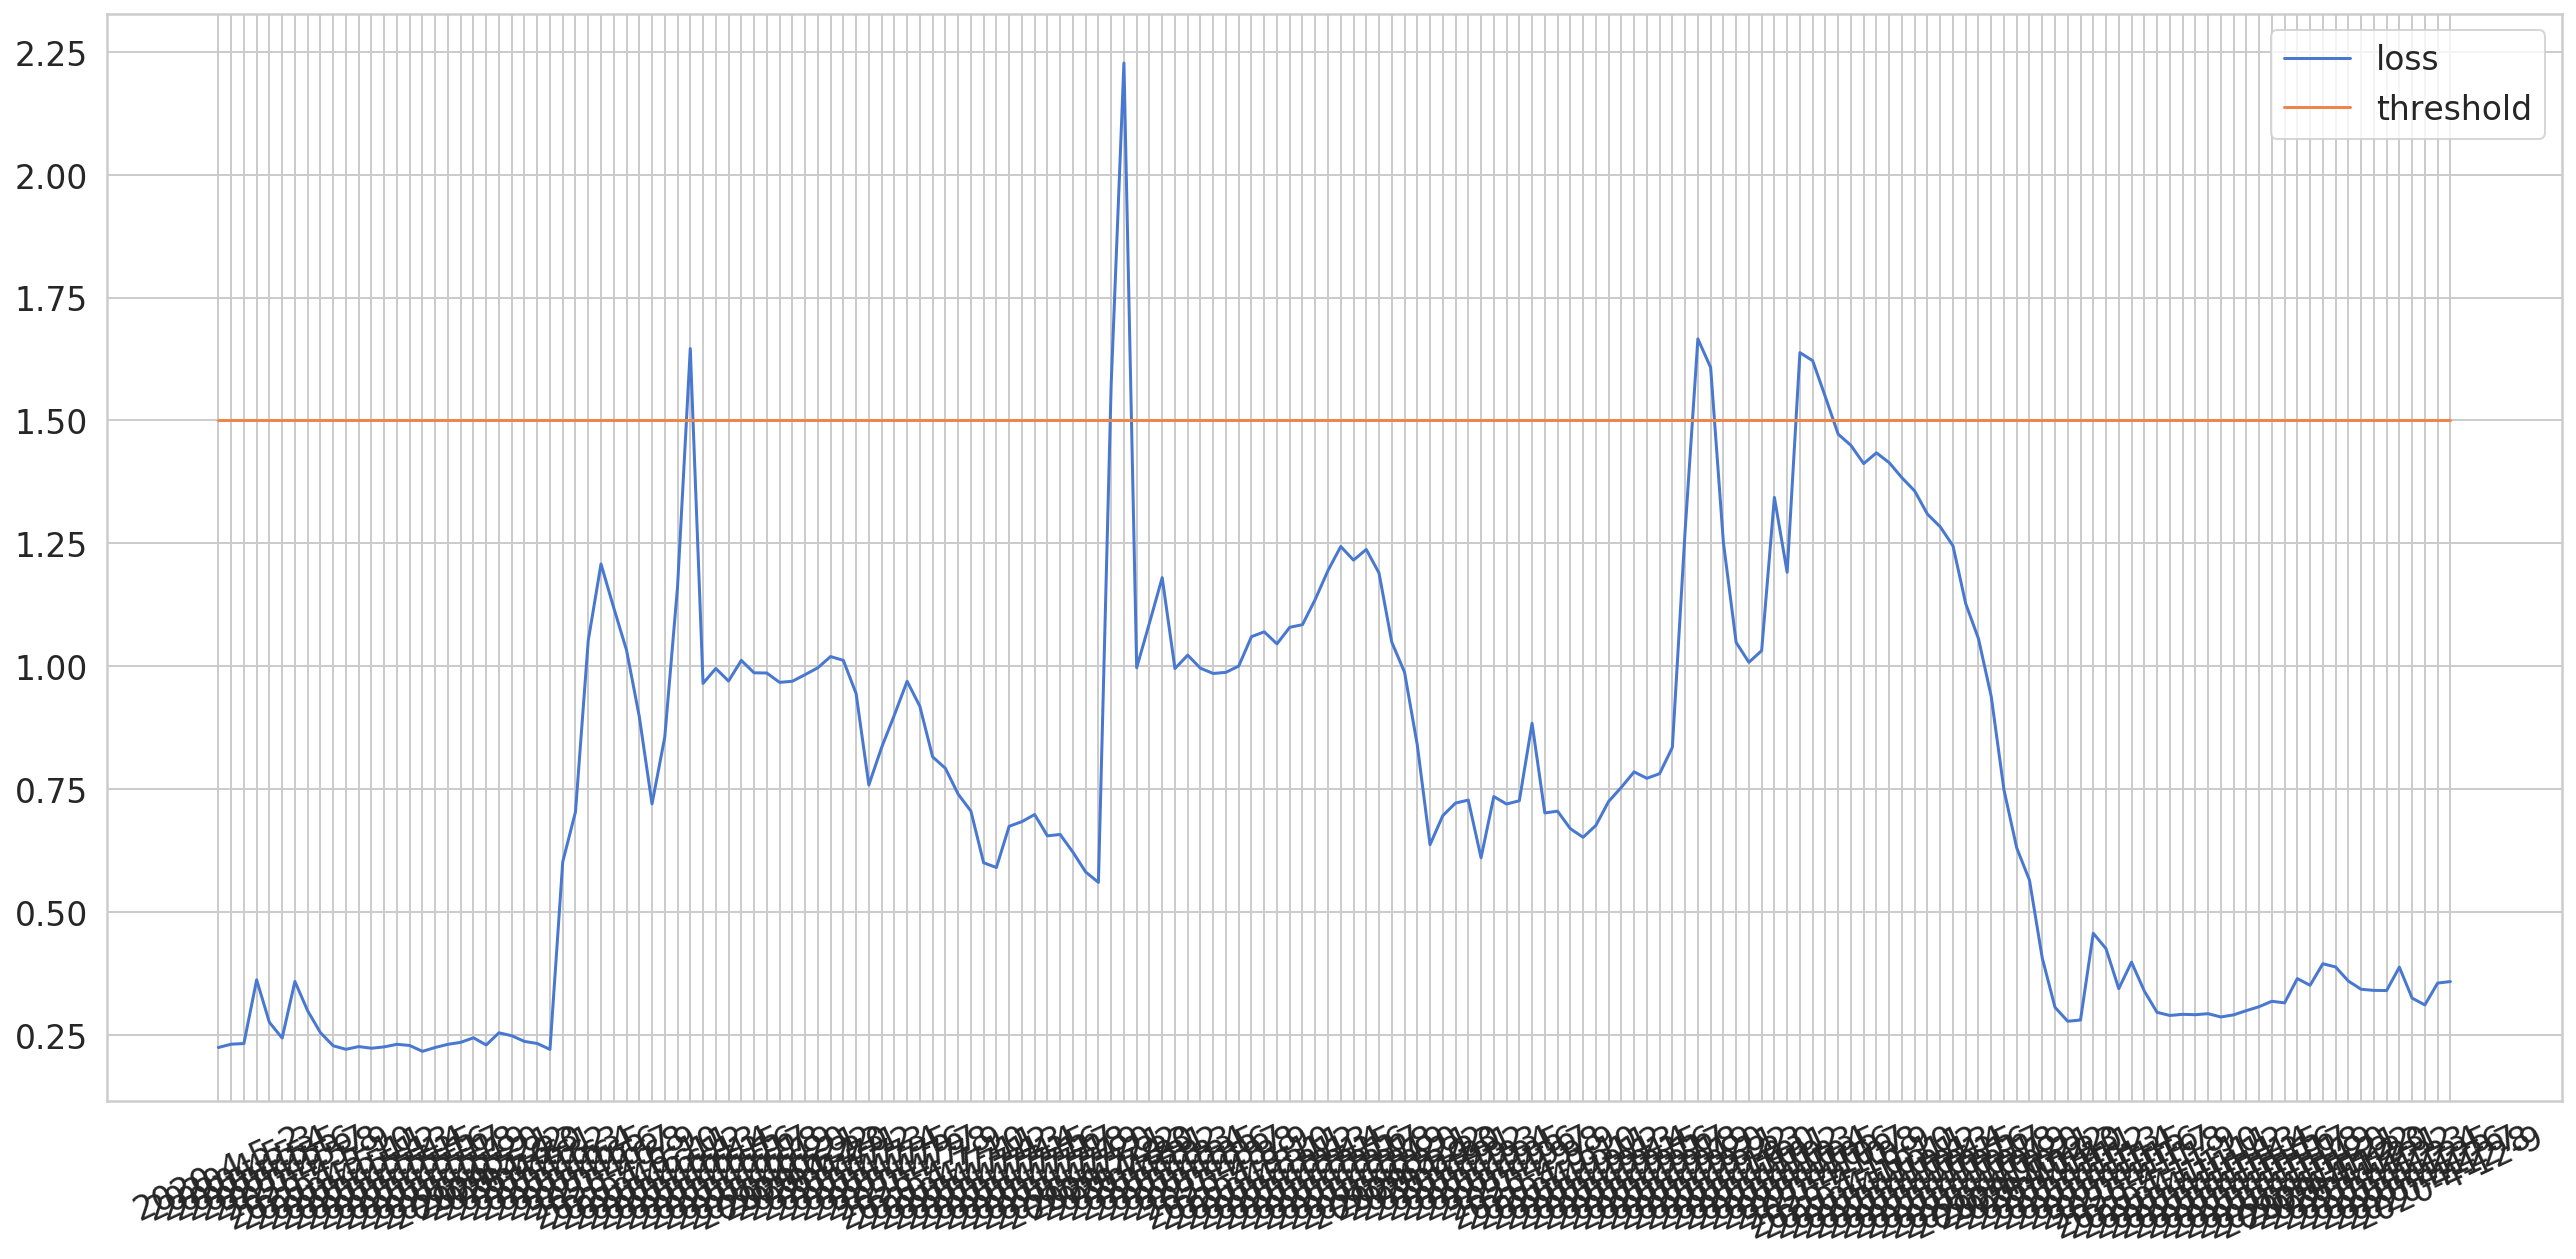

In [88]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [89]:

#anomalies.head()
anomalies

loss  threshold  anomaly     close
date                                               
2020-4-6-15  1.646157        1.5     True  0.211948
2020-4-8-0   1.573802        1.5     True  6.190174
2020-4-8-1   2.227240        1.5     True -0.442924
2020-4-9-22  1.665940        1.5     True  3.818497
2020-4-9-23  1.607849        1.5     True  2.277503
2020-4-10-6  1.638023        1.5     True -0.366725
2020-4-10-7  1.621602        1.5     True  0.416913
2020-4-10-8  1.547720        1.5     True -0.167061

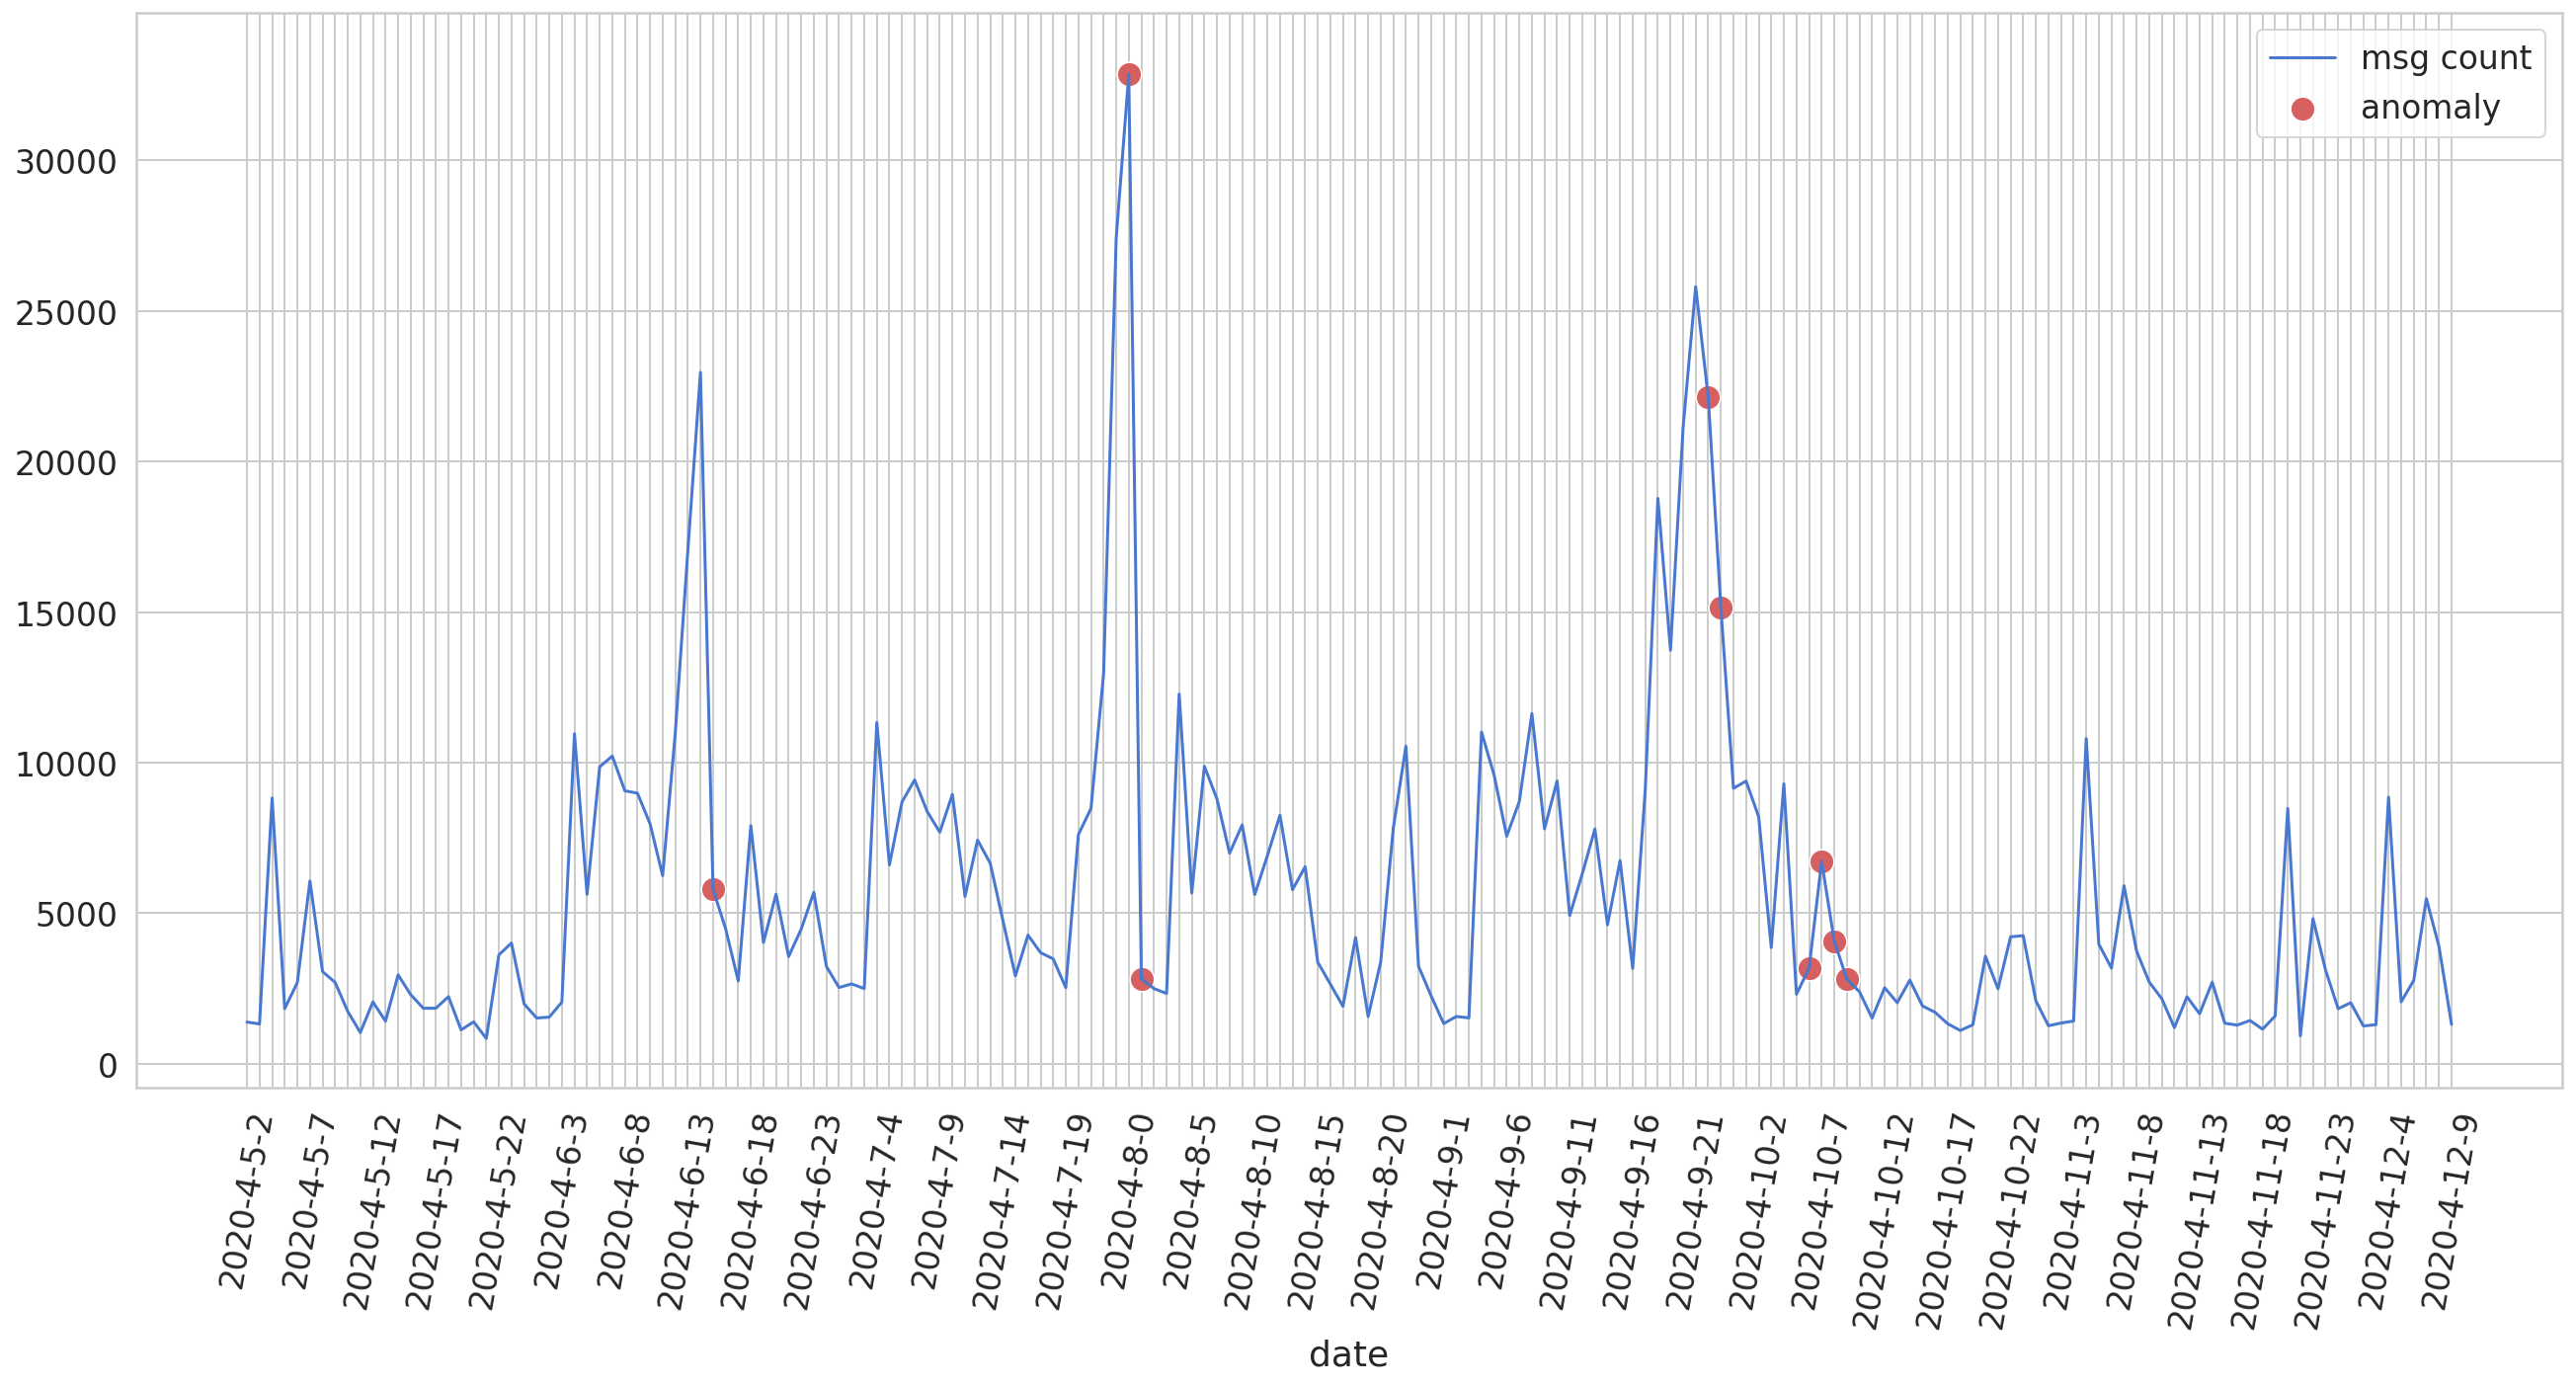

In [187]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='msg count'
);

ax = sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=152,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

label(ax,5,80)

# Train

In [34]:
#del dataall['microsecond']
#pfall.dtypes
pfall.head()

CGLOBALMESSAGEID  CMESSAGETAT2  CSLATAT  CINBOUNDSIZE  outcome  \
0  8166452458945691777          6152     5168         20525        0   
1 -6418901839252866076          9595     9449         31472        0   
2 -4286110911660535956         10801    10656         31822        0   
3  1914793846427484848          9719     9575         33259        0   
4  7931678358474834122          7152     7123          1212        0   

   CSERVICE  CRECEIVERPROTOCOL  CSENDERPROTOCOL  CSENDERENDPOINTID  \
0         6                  0                9                939   
1         5                  0                4               1714   
2         5                  0                4               1714   
3         5                  0                4               1714   
4         0                 10                0               2299   

   CRECEIVERENDPOINTID  CSTATUS  year  month  day  hour  minute  second  \
0                 2328       11  2019     10   29     4       9      19   
1                  958       11  2019     10   29     4       9      30   
2                 1849       11  2019     10   29     4       9      31   
3                 1849       11  2019     10   29     4       9      31   
4                  949       11  2019     10   29     4       9      33   

   microsecond  
0       728000  
1       795000  
2       388000  
3       483000  
4       962000

In [88]:
#Creating training, validation, and test splits (V1)

#data = pfall[(pfall['month'] == 11)]
data = pfall

valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

train = data[:-2 * valid_size]
valid = data[-2 * valid_size:-valid_size]
test = data[-valid_size:]

In [82]:
#Creating training, validation, and test splits (V2 - current)
data = pfall
train, valid, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [89]:
print("data",len(data),"train",len(train),"valid",len(valid),"test",len(test))

for each in [train, valid, test]:
    print(f"Outcome fraction  = {each.outcome.mean():.4f}")

data 18867632 train 15094106 valid 1886763 test 1886763
Outcome fraction  = 0.0048
Outcome fraction  = 0.0074
Outcome fraction  = 0.0066


In [90]:
#Training a LightGBM model

import lightgbm as lgb

feature_cols = train.columns.drop('outcome').drop('CSTATUS').drop('CGLOBALMESSAGEID').drop('microsecond')
#feature_cols = feature_cols.drop('CSENDERENDPOINTID')
#feature_cols = feature_cols.drop('CRECEIVERENDPOINTID')
##feature_cols = feature_cols.drop('year')
#feature_cols = feature_cols.drop('month')
#feature_cols = feature_cols.drop('day')
#feature_cols = feature_cols.drop('hour')
feature_cols = feature_cols.drop('minute')
feature_cols = feature_cols.drop('second')
feature_cols = feature_cols.drop('CSLATAT')
feature_cols = feature_cols.drop('CMESSAGETAT2')

dtrain = lgb.Dataset(train[feature_cols], label=train['outcome'])
dvalid = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
feature_cols

Index(['CINBOUNDSIZE', 'CSERVICE', 'CRECEIVERPROTOCOL', 'CSENDERPROTOCOL',
       'CSENDERENDPOINTID', 'CRECEIVERENDPOINTID', 'year', 'month', 'day',
       'hour'],
      dtype='object')

In [91]:
#Making predictions & evaluating the model

from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.roc_auc_score(test['outcome'], ypred)

print(f"Test AUC score: {score}")

Test AUC score: 0.8936476113329274


In [92]:

def getres():
    res = test[feature_cols].copy()
    res['ypred'] = ypred
    res = res.assign(ypred=((res['ypred'] >0.5) ).astype(int))
    res['outcome'] = test['outcome']
    res['CSTATUS'] = test['CSTATUS']
    return res

res = getres()
#res

wrong = (res[(res['outcome'] != res['ypred'] )])
right = (res[(res['outcome'] == res['ypred'] )])

#len((res[(res['outcome'] != res['ypred'] )])) , len((res[res['outcome'] == res['ypred'] ]))


#t = res['outcome'] 
#len(t[t == 1]), len(s[s == 1])

#len(wrong),len(wrong[wrong['outcome'] == 0]),len(wrong[wrong['outcome'] == 1]),len(right),len(right[right['outcome'] == 0]),len(right[right['outcome'] == 1]),right[right['outcome'] == 1].groupby(['CSTATUS'])['outcome'].count()

print(feature_cols)
print("data",len(data),"train",len(train),"valid",len(valid),"test",len(test))

for each in [train, valid, test]:
    print(f"Outcome fraction  = {each.outcome.mean():.4f}")

print(f"Test AUC score: {score}")    
    
print ("prediction wrong:", len(wrong), "prediction right:",len(right)) 
print("right(success):" ,len(right[right['outcome'] == 0]),"right(error):", len(right[right['outcome'] == 1]))


Index(['CINBOUNDSIZE', 'CSERVICE', 'CRECEIVERPROTOCOL', 'CSENDERPROTOCOL',
       'CSENDERENDPOINTID', 'CRECEIVERENDPOINTID', 'year', 'month', 'day',
       'hour'],
      dtype='object')
data 18867632 train 15094106 valid 1886763 test 1886763
Outcome fraction  = 0.0048
Outcome fraction  = 0.0074
Outcome fraction  = 0.0066
Test AUC score: 0.8936476113329274
prediction wrong: 5567 prediction right: 1881196
right(success): 1872408 right(error): 8788


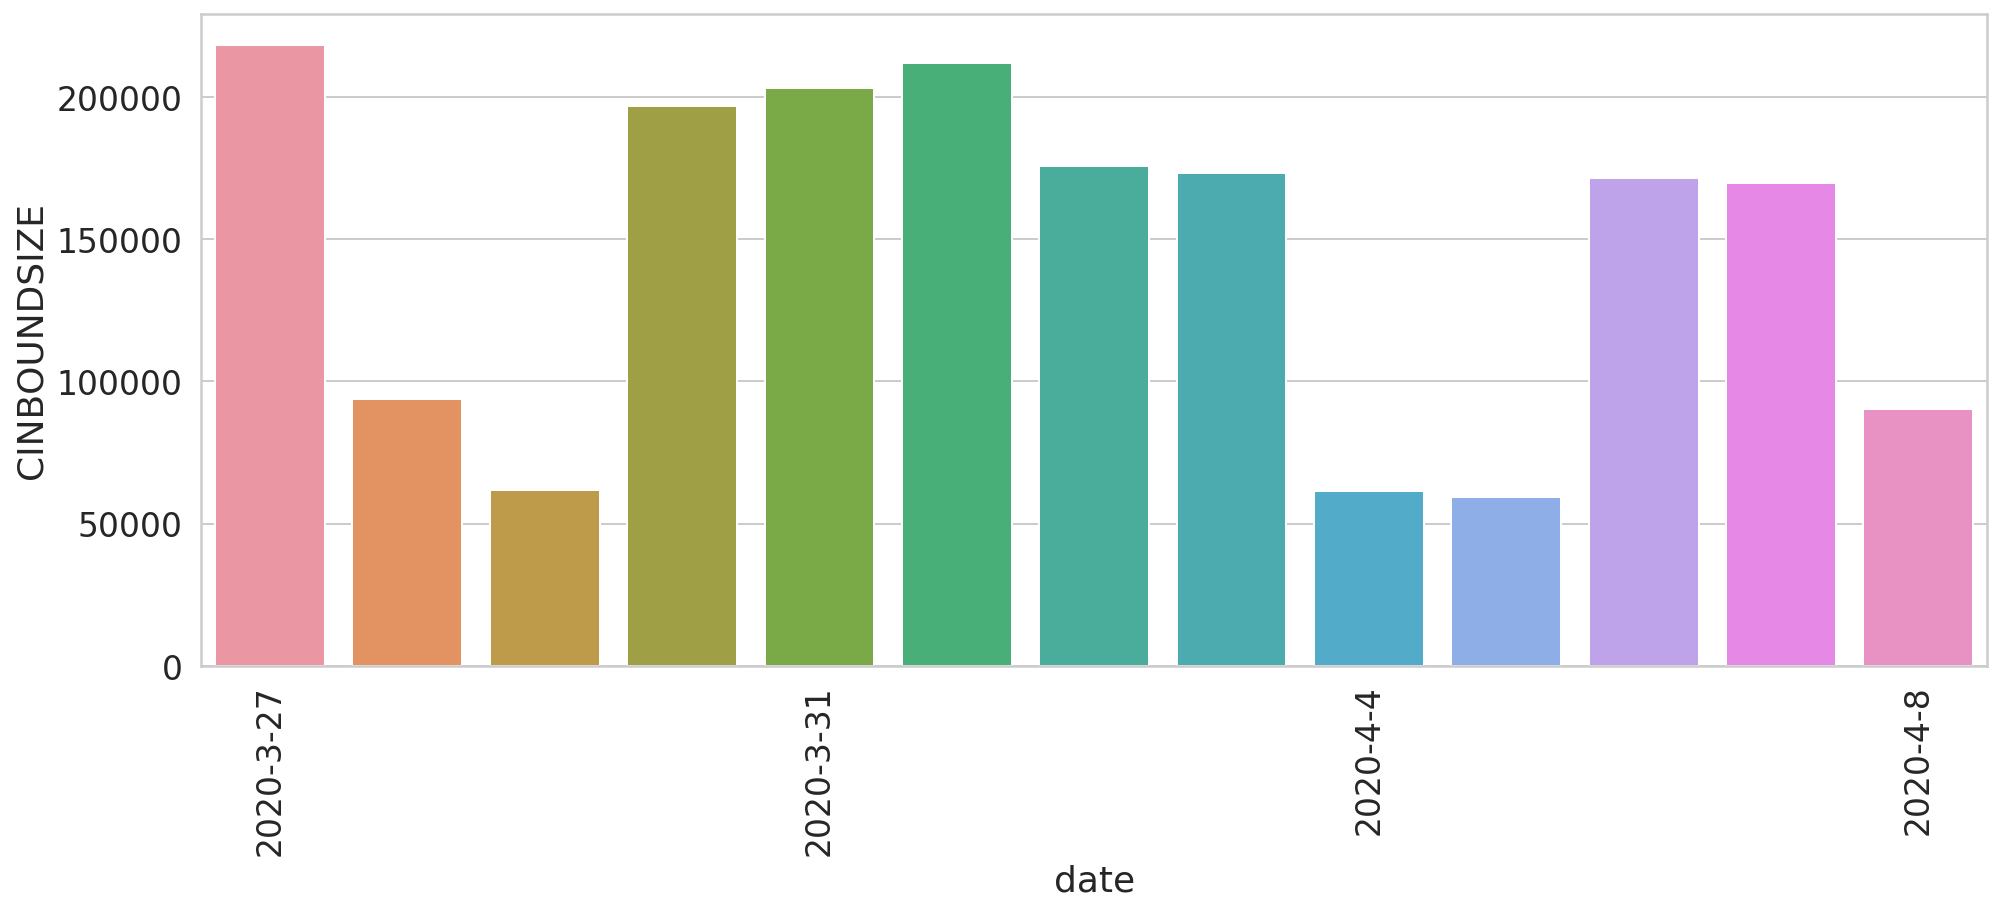

In [93]:
#test[feature_cols]

mdcountsall=test[feature_cols].groupby(['year','month','day'])['CINBOUNDSIZE'].count()

data2 = pd.DataFrame()
data2['date'] =   abc(mdcountsall)
data2['CINBOUNDSIZE'] =  mdcountsall.reset_index()['CINBOUNDSIZE'].astype(int) 

plt.figure(figsize=(16,6))

#sns.heatmap(x=data2['date'], y=data2['outcome'], data=data2)
ax = sns.barplot(x=data2['date'], y=data2['CINBOUNDSIZE'], data=data2)
#ax = sns.scatterplot(x=data2['date'], y=data2['CINBOUNDSIZE'], data=data2)
label(ax,4,90)

In [ ]:
#test.iloc[0], 
#ypred[1] < 0.5
#len(ypred[ypred > 0.5]),len(test[test['outcome'] == 1])
#ypred[ypred > 0.5]
#test
#feature_cols
#res = test[feature_cols]
#res
#len(res.index), len(ypred)
#res['ypred'] = ypred
#res = res.assign(ypred=((res['ypred'] >0.5) ).astype(int))
#res['outcome'] = test['outcome']
#res[res['outcome']==1]

#res.outcome.mean(), res.ypred.mean()
#len((res[~(res['outcome'] == res['ypred'] )])) , len((res[res['outcome'] == res['ypred'] ]))
#(res[~(res['outcome'] == res['ypred'] )])
#s = (res[~(res['outcome'] == res['ypred'] )])['outcome'] 
#s[s == 1]
#t = res['outcome'] 
#len(t[t == 1]), len(s[s == 1])
train.columns
mdcountsall

In [ ]:
import autogluon as ag
from autogluon import TabularPrediction as task

In [ ]:
#train.head()
label_column = 'outcome'
print("Summary of class variable: \n", train[label_column].describe())
dir = 'agModels-predictClass' # specifies folder where to store trained models
predictor = task.fit(train_data=train, label=label_column, output_directory=dir)

# 2

In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col


#SparkConf().set("spark.sql.execution.arrow.enabled", "true")

#df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/1580137124017/part-00000-b2678865-5b2e-43a7-8428-117b6f435dc5-c000.snappy.parquet')

#df.show()
#pf = df.toPandas()

#df = sqlContext.read.parquet("/home/jovyan/work/notebook/flat/000000_1")

#df2 = df.select('CSENDERENDPOINTID','CGLOBALMESSAGEID','CSTARTTIME','CSTATUS').limit(30000000).dropDuplicates().orderBy('CSTARTTIME')

#df2 = df.select('CSENDERENDPOINTID','CGLOBALMESSAGEID','CSTARTTIME','CSTATUS').filter(df["CSTARTTIME"]>='1577071831179').limit(30000000).dropDuplicates().orderBy('CSTARTTIME')

#1580427009923
#df2 = df.select('CSENDERENDPOINTID','CGLOBALMESSAGEID','CSTARTTIME','CSTATUS').filter(df["CSTARTTIME"]>='1580427009923').limit(30000000).dropDuplicates().orderBy('CSTARTTIME')

df2 = df.withColumn('CSTARTTIME', col('CSTARTTIME').cast('long')).select('CSENDERENDPOINTID','CGLOBALMESSAGEID','CSTARTTIME','CSTATUS').filter(col("CSTARTTIME")>=1580427009923)
#.dropDuplicates().orderBy('CSTARTTIME')





In [ ]:
pfall.head()
#pfall.loc[pfall['CSTARTTIME'].astype(str).astype(long).idxmax()]
#pfall.loc[pfall['CSTARTTIME'].idxmax()]
pfall

In [ ]:
#pfall
#pd.unique(pfall.CSTATUS)
#pf.groupby('CSTATUS')['CGLOBALMESSAGEID'].count()
#pfall = pfall.assign(outcome=(pfall['CSTATUS'] == 'SUCCESS').astype(int))



In [ ]:
#pf = df.limit(1000000).toPandas()
#pf=df.filter(df["CSERVICE"]=='PEPPOL').select('*').limit(1000000).dropDuplicates().toPandas()
#pf=df.filter(df["CSERVICE"]=='PEPPOL').select('*').limit(1000000).toPandas()
#df.head()

df1 = df.filter(df["CSTATUS"]!='SUCCESS').filter(df["CSTATUS"]!='SUCCESS_DOWNLOADED').select('CGLOBALMESSAGEID','CSTARTTIME','CENDTIME','CSTATUS','CSENDERPROTOCOL','CSENDERENDPOINTID','CINBOUNDSIZE','CRECEIVERPROTOCOL','CRECEIVERENDPOINTID','CSLATAT','CMESSAGETAT2','CSLADELIVERYTIME','CSERVICE').limit(30000000).dropDuplicates().orderBy('CSTARTTIME')


In [ ]:
pfall = df2.limit(5000000).toPandas()

In [ ]:
#df1.show(1)
pf = df1.limit(1000000).toPandas()

In [ ]:
pf1 = df.filter(df["CSERVICE"]=='PEPPOL').select('CGLOBALMESSAGEID','CSTARTTIME','CENDTIME','CSTATUS','CSENDERPROTOCOL','CSENDERENDPOINTID','CINBOUNDSIZE','CRECEIVERPROTOCOL','CRECEIVERENDPOINTID','CSLATAT','CMESSAGETAT2','CSLADELIVERYTIME').limit(1000000).dropDuplicates()
pf = pf1.toPandas()

In [ ]:
pf = pf.sort_values('CGLOBALMESSAGEID', ascending=True)

In [ ]:
#pd.to_datetime(df['CENDTIME']).apply(lambda x: x.date())
import datetime
readable = datetime.datetime.fromtimestamp(1580983470).isoformat()
print(readable)

ab = pf.iloc[121]['CENDTIME']

import datetime
date = datetime.datetime.fromtimestamp(float(ab) / 1e3)

date

In [ ]:
# convert columns to datetime
import datetime
pf['CENDTIME'] = pf['CENDTIME'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1e3))
pf['CSTARTTIME'] = pf['CSTARTTIME'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1e3))
pf['CSLADELIVERYTIME'] = pf['CSLADELIVERYTIME'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1e3))

pf['CINBOUNDSIZE'] = pf['CINBOUNDSIZE'].astype(str).astype(int)
pf['CMESSAGETAT2'] = pf['CMESSAGETAT2'].astype(str).astype(int)
pf['CSLATAT'] = pf['CSLATAT'].astype(str).astype(int)

pf['CSENDERPROTOCOL'] = pf['CSENDERPROTOCOL'].astype(str)
pf['CSERVICE'] = pf['CSERVICE'].astype(str)
pf['CRECEIVERPROTOCOL'] = pf['CRECEIVERPROTOCOL'].astype(str)

pf['CSENDERENDPOINTID'] = pf['CSENDERENDPOINTID'].astype(str)
pf['CRECEIVERENDPOINTID'] = pf['CRECEIVERENDPOINTID'].astype(str)

In [ ]:

#pf["CSTARTTIME"] = pd.to_numeric(pf["CSTARTTIME"])
#set(pf['CSTARTTIME'].dt.date)
pf
#pf.dtypes

In [ ]:
expired = pf[pf['CSTATUS']=='EXPIRED']
expired = expired.sort_values('diff', ascending=True)

In [ ]:
success = pf[pf['CSTATUS']=='SUCCESS']
success['diff'] = (success.CENDTIME - success.CSTARTTIME).dt.total_seconds()
success = success.sort_values('diff', ascending=True)

In [ ]:
success.iloc[1]
#expired.iloc[0]

In [ ]:
#(pf.CENDTIME-pf.CSTARTTIME).astype('timedelta64[s]')

def diffdt(el):
    return (el.CENDTIME-el.CSTARTTIME).total_seconds(),el.CSTARTTIME,el.CENDTIME,el

(pf.CENDTIME-pf.CSTARTTIME).dt.total_seconds()
el = expired.iloc[0]
el.CENDTIME, el.CSTARTTIME,(el.CENDTIME - el.CSTARTTIME).total_seconds() 

#diffdt(el)
#expired['diff'] = (expired.CENDTIME - expired.CSTARTTIME).dt.total_seconds()
expired

In [ ]:
import pandas_profiling
import numpy as np
pandas_profiling.ProfileReport(dataall)

In [ ]:
import numpy as np   

def get_categories(column):
    return np.array(df.select(column).dropDuplicates().dropna().collect())

services = get_categories('CSERVICE')
receivers = get_categories('CRECEIVERENDPOINTID')
senders = get_categories('CSENDERENDPOINTID')
receiverprotocols = get_categories('CRECEIVERPROTOCOL')
senderprotocols = get_categories('CSENDERPROTOCOL')
status = get_categories('CSTATUS')

In [ ]:
#services
#status
pd.unique(pf.CSTATUS)
pf.groupby('CSTATUS')['CGLOBALMESSAGEID'].count()

In [ ]:
senders = pd.unique(pf.CSENDERENDPOINTID)

In [ ]:
#Prepping categorical variables
from sklearn.preprocessing import LabelEncoder

cat_features = ['CSTATUS']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded2 = pf[cat_features].apply(encoder.fit_transform)
#encoded2.head(10)

data['CSTATUS'] = encoded2

In [ ]:
#Prepping categorical variables
from sklearn.preprocessing import LabelEncoder

cat_features = ['CSENDERPROTOCOL', 'CSERVICE', 'CRECEIVERPROTOCOL', 'CSENDERENDPOINTID', 'CRECEIVERENDPOINTID']
encoder = LabelEncoder()

# Apply the label encoder to each column
encoded = pf[cat_features].apply(encoder.fit_transform)
encoded.head(10)

In [ ]:
from datetime import time
import datetime as dt

pf.dtypes

#datetime.datetime.fromtimestamp(pf['CSTARTTIME'][0])

ti = pf['CSTARTTIME'][0].time()


ti.hour ,ti.minute,ti.second, ti.microsecond, pf['CSTARTTIME'][0]


pf['CSTARTTIME'].apply(lambda x: x.date().month)

In [ ]:
#CMESSAGETAT2 : Laufzeit Msg (ms) : end - start

data = pf[['CMESSAGETAT2', 'CSLATAT', 'CINBOUNDSIZE']].join(encoded)
data.head()

In [ ]:
data['year'] = pf['CSTARTTIME'].apply(lambda x: x.date().year)
data['month'] = pf['CSTARTTIME'].apply(lambda x: x.date().month)
data['day'] = pf['CSTARTTIME'].apply(lambda x: x.date().day)

data['hour'] = pf['CSTARTTIME'].apply(lambda x: x.time().hour)
data['minute'] = pf['CSTARTTIME'].apply(lambda x: x.time().minute)
data['second'] = pf['CSTARTTIME'].apply(lambda x: x.time().second)
data['microsecond'] = pf['CSTARTTIME'].apply(lambda x: x.time().microsecond)

data.head()

In [ ]:
#data.iloc[0],pf.iloc[0]
pd.unique(data.month)
#data.groupby('month')['month'].count()
#data.groupby(['month','day'],as_index=False).count()['day']
mdcounts = data.groupby(['year','month','day'])['CMESSAGETAT2'].count()

In [ ]:
mdcounts[2020,1]
mdcounts.index
type(mdcounts)
mdcounts.index

In [ ]:
# Set the width and height of the figure
plt.figure(figsize=(24,6))

# Add title
plt.title("Number of messages with errors (year, month, day)")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
g = sns.barplot(x=mdcounts.index, y=mdcounts)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Add label for vertical axis
plt.ylabel("Errors")

In [ ]:
# Line chart showing daily global streams of each song 
#sns.lineplot(data=mdcounts)

plt.figure(figsize=(34,6))

df = pd.DataFrame({"Datum": ['1/1/2018 0:00',
                             '1/1/2018 0:15',
                             '1/1/2018 0:30',
                             '1/1/2018 0:45',
                             '1/1/2018 1:00',
                             '1/1/2018 1:15',
                             '1/1/2018 1:30',
                             '1/1/2018 1:45 '],
                   "Menge": [19.5, 19.,19.5,19.5,21,19.5,20,23]})

#sns.lineplot(x="Datum", y="Menge", data=df)

ar=[2,3,3,3,3]

#mdcounts.head()
#sns.lineplot(x=pf.head().CSTARTTIME,y=data.CINBOUNDSIZE)
#sns.lineplot(x=ar,y=data.head().CINBOUNDSIZE)
data

# Train

In [ ]:
!conda install -y -c conda-forge lightgbm

# Hive

In [ ]:
from sqlalchemy import create_engine
from pyhive import hive

from sqlalchemy import *
from sqlalchemy.engine import create_engine
from sqlalchemy.schema import *

#engine = create_engine('hive://clspromon-aio01:10000/default')
engine = create_engine('hive://172.30.17.145:10000/default')

In [ ]:
row = engine.execute("select * from tables_3_stage1 limit 1")

In [ ]:
col = [] 
for _row in row:
    #print(_row['name'])
    col.append(_row['name'])
col    

In [ ]:
inspector = inspect(engine)

# Get table information
#print(inspector.get_table_names())

# Get column information
row=inspector.get_columns('tables_stage1_p_meta_complete')

col = [] 
for _row in row:
    #print(_row['name'])
    col.append(_row['name'])

#col

import pandas as pd

row =  engine.execute("select * from  tables_stage1_p_meta_complete")
meta_p = pd.DataFrame(row)

meta_p.columns = col
#pyspark.createDataFrame(meta_p).collect()  

meta_p.set_index('metricid', inplace=True)
#meta_p.set_index('metricid')

meta_p['metricid'] = meta_p.index

#meta_p.instance.fillna(value=pd.np.nan, inplace=True)
meta_p['instance'].replace(pd.np.nan, "", inplace=True)


In [ ]:
#meta_p.loc[-415304450].__name__
#meta_p.iloc[1].service
#meta_p
#meta_p.loc[meta_p.index[0]].__name__
#meta_p.index[1]
#meta_p.iloc[1]
col

In [ ]:
#meta_p.info()
dfm = sqlContext.createDataFrame(meta_p)

In [ ]:
import numpy as np   

#objects = dfm.select('__name__','instance','product', 'metricid', 'schemaid').dropDuplicates()
services = np.array(dfm.select('service').dropDuplicates().dropna().collect())
names = np.array(dfm.select('__name__').dropDuplicates().dropna().collect())
instances = np.array(dfm.select('instance').dropDuplicates().dropna().collect())
products = np.array(dfm.select('product').dropDuplicates().dropna().collect())
schemaids = np.array(dfm.select('schemaid').dropDuplicates().dropna().collect())
metricid = np.array(dfm.select('metricid').dropDuplicates().dropna().collect())

In [ ]:
#roles = np.array(dfm.select('role').dropDuplicates().dropna().collect())
#roles
schemaids.size

In [ ]:
#print(str(metricid[1][0]))
#names.size
#dfm.select('__name__').dropDuplicates().dropna().filter("__name__ like '%task%'").collect()

#.filter(dfm.__name__.contains('%b%')).show()
#dfm.filter(dfm["__name__"]=='bis_inbox_tasks_running').select("*").collect()
#dfm.filter(dfm["instance"]=='clspromsg-ts01:13000').select("__name__").collect()
#dfm.filter(dfm["instance"]=='clspromsg-ids01:13000').select("__name__").collect()
#dfm.filter(dfm["__name__"]=='bis_jms_message_count').select("instance",'metricid').collect()

#la = ['__name__','instance','metricid','schemaid','job','alertname','alertstate','severity' ]
#dfm.filter(dfm["__name__"]=='bis_jms_message_count').filter(dfm["queue"]=='DtFTPComponent').filter(dfm["instance"]=='clspromsg-ts01:13000').select(la).collect()

#alertes = dfm.filter(dfm["__name__"]=='ALERTS').select(la).limit(200000).toPandas()
#alertes.schemaid.size
#instances

In [ ]:
la = ['__name__','instance','metricid','schemaid','job','alertname','alertstate','severity' ]

alerts = dfm.filter(dfm["__name__"]=='ALERTS').select(la).limit(200000).toPandas()
alerts.schemaid.size

In [ ]:
df.filter(df["hashvalue"]==id).select('value').distinct().count()

#pf.describe()

In [ ]:
for _row in metricid:
    id = str(_row[0])
    print(id,df.filter(df["hashvalue"]==id).select('value').distinct().count())

id = '-1483665529'
#id = str(meta_p.index[0])

In [ ]:
#metricid[0]

id = 1797174388 
#id = '-415304450'

#id = -1756241224 #1
#id = 1843265645 #24497
#id = 852430459 #1
#id = -426467024 #22515
#id = 6557551 #25097
#id = -1466543823 #26614
#id = 612749002 #2
#id = -547512297 #24905
#id = -415304450 #4920
#id = 857353913 #1
#id = 500298778 #1
#id = -349732210 #2
#id = 1786297729 #26414

#pf=df.filter(df["value"]>'0').filter(df["hashvalue"]=='2012513398').select('date','value').limit(200000).toPandas()
#pf=df.filter(df["value"]>'0').filter(df["hashvalue"]==str(metricid[0])).select('date','value').limit(200000).toPandas()
#pf=df.filter(df["hashvalue"]==str(metricid[1000][0])).select('date','value').limit(200000).toPandas()


In [ ]:
def get_pf(id):
    pf=df.filter(df["hashvalue"]==str(id)).select('date','value').limit(200000).toPandas()
    pf = pf.sort_values('date', ascending=True)
    pf["value"] = pd.to_numeric(pf["value"])
    return pf

def get_plot_title(id) :
    title = str(id) + " = " + meta_p.loc[id].__name__ + " -> " + meta_p.loc[id].instance
    return title

id = alerts.metricid[3]
id=612749002

pf = get_pf(id)
#alertes.metricid.size

In [ ]:
id=612749002
#val = df.filter(df["hashvalue"]==str(id)).select('value')

#val.distinct().collect()
#val.distinct().count()

#val.groupBy('value').count().show()

df.filter(df["hashvalue"]==str(id)).filter(df["value"]=='8').select("*").show()



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plot_title = get_plot_title(id)

pf.plot(x='date', y='value', title=plot_title)

In [ ]:
#df.head()
pf = pf.sort_values('date', ascending=True)
pf.count()
#pf = pf.astype('float')
pf["value"] = pd.to_numeric(pf["value"])
print(type(pf['value'][0]))

In [ ]:
from pyspark.sql import functions as F
#df.select("hashvalue", F.when(df.hashvalue == 266655713, 1).otherwise(0)).show()
#df.select("hashvalue", F.when(df.hashvalue == 266655713, 1).otherwise(0)).show()
#df.select(df.hashvalue.between(266655713,266655713)).show()
#df.filter(df["hashvalue"]==str(metricid[1][0])).select('date','hashvalue').rdd.flatMap(list).collect()
df.filter(df["hashvalue"]==str(metricid[1][0])).select("*").limit(2).toPandas()

In [ ]:
print(metricid[0][0])
len(metricid)

for row in products:
    print(row[0])

for id in metricid:
    pf=df.filter(df["value"]>'0').filter(df["hashvalue"]==id[0]).select('date','value').limit(200000).toPandas()
    pf.describe()
    

In [ ]:
services.count()
products.show()

for row in services.rdd.collect():
    print(row.service)
    
 
#np.array(services.select("service").collect())
services

In [ ]:
hashes = [] 
for _row in row:
    print(_row['hashvalue'])
    hashes.append(_row['hashvalue'])

#col

In [ ]:
#names.select("*").collect()
#hashes
meta_p

# Install

In [ ]:
import os
os.environ['http_proxy'] = "http://172.30.12.56:3128" 
os.environ['https_proxy'] = "https://172.30.12.56:3128"    

In [ ]:
!pip install --upgrade mxnet
!pip install autogluon

In [ ]:
conda install -c conda-forge pillow=6.2.1

In [ ]:
conda install -c conda-forge pyhive

In [ ]:
conda install -c conda-forge pandas-profiling

In [ ]:
!pip install facets-overview

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [ ]:
import os
import sys 

facets_path = os.path.dirname('.')
facets_path = os.path.abspath(os.path.join(facets_path, 'facets', 'facets_overview', 'python'))
                              
if not facets_path in sys.path:
    sys.path.append(facets_path)

In [ ]:
import PIL.Image
import pandas as pd
import numpy as np
import itertools
import math
import zipfile
from matplotlib import pylab as plt
%matplotlib inline

In [ ]:
## Helpers for loading/viewing image data

# Background color for figures/subplots when showing favicons. Use a faint grey
# instead of the default white to make it clear which sections are transparent.
BG = '.95'
def show(df, scale=1, titles=None):
    """Show the favicons in the given dataframe, arranged in a grid.
    scale is a multiplier on the size of the drawn icons.
    """
    n = len(df)
    cols = int(min(n, max(4, 8//scale)))
    rows = math.ceil(n / cols)
    row_height = 1 * scale
    col_width = 1 * scale
    fs = (cols*col_width, rows*row_height)
    fig, axes = plt.subplots(rows, cols, figsize=fs, facecolor=BG)
    if rows == cols == 1:
        axes = np.array([axes])
    for i, (row, ax) in enumerate(
        itertools.zip_longest(df.itertuples(index=False), axes.flatten())
    ):
        if row is None:
            ax.axis('off')
        else:
            try:
                img = load_favicon(row.fname, row.split_index)
                _show_img(img, ax)
                if titles is not None:
                    ax.set_title(titles[i])
            except CorruptFaviconException:
                ax.axis('off')
                
def _show_img(img, ax=None):
    if ax is None:
        _fig, ax = plt.subplots(facecolor=BG)
    ax.tick_params(which='both', 
                   bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                  )
    ax.grid(False, which='both')
    plt.setp(list(ax.spines.values()), color='0.8', linewidth=1, linestyle='-')
    ax.set_facecolor(BG)
    cmap = None
    if img.mode in ('L', 'LA'):
        cmap = 'gray'
    ax.imshow(img, cmap=cmap, aspect='equal', interpolation='none')
                
class CorruptFaviconException(Exception): pass

_ZIP_LOOKUP = {}
def load_favicon(fname, split_ix):
    if split_ix not in _ZIP_LOOKUP:
        zip_fname = '../input/full-{}.z'.format(split_ix)
        _ZIP_LOOKUP[split_ix] = zipfile.ZipFile(zip_fname)
    archive = _ZIP_LOOKUP[split_ix]
    fp = archive.open(fname)
    try:
        fav = PIL.Image.open(fp)
    except (ValueError, OSError):
        raise CorruptFaviconException
    if fav.format == 'ICO' and len(fav.ico.entry) > 1:
        pil_ico_hack(fav)
    return fav

def pil_ico_hack(img):
    """When loading an ICO file containing multiple images, PIL chooses the
    largest. We want whichever one is listed first."""
    ico = img.ico
    ico.entry.sort(key = lambda d: d['offset'])
    first = ico.frame(0)
    first.load()
    img.im = first.im
    img.mode = first.mode
    img.size = first.size

In [ ]:
def load_metadata_df():
    """Return a dataframe with a row of metadata for each favicon in the dataset."""
    csvpath = '../input/favicon_metadata.csv'
    return pd.read_csv(csvpath)

METADATA_CSV = pf
METADATA_CSV.head()

In [ ]:
import numpy as np
np.random.seed(2017)

indices = METADATA_CSV.index
indices = np.random.choice(indices, size=100000)
_metadata_csv = METADATA_CSV.loc[indices, :]

In [ ]:
sys.path.append('/opt/facets/facets_overview/python')

from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
proto = GenericFeatureStatisticsGenerator().ProtoFromDataFrames([{'name': 'Metadata', 'table': _metadata_csv}])

In [ ]:
from IPython.core.display import display, HTML
import base64
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
HTML_TEMPLATE = """<link rel="import" href="/nbextensions/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

In [ ]:

# Display the Dive visualization for the training data.
from IPython.core.display import display, HTML

jsonstr = pf.to_json(orient='records')
HTML_TEMPLATE = """<link rel="import" href="/nbextensions/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [ ]:
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn.apionly as sns
import matplotlib.pyplot as plt

# create dataframe with datetime as index and aggregated (frequency) values
date = pd.date_range('2017-02-23', periods=10*12, freq='2h')
freq = np.random.poisson(lam=2, size=(len(date)))
df = pd.DataFrame({"freq":freq}, index=date)

# add a column hours and days
df["hours"] = df.index.hour
df["days"] = df.index.map(lambda x: x.strftime('%b-%d'))     
# create pivot table, days will be columns, hours will be rows
piv = pd.pivot_table(df, values="freq",index=["hours"], columns=["days"], fill_value=0)
#plot pivot table as heatmap using seaborn
ax = sns.heatmap(piv, square=True)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90 )
plt.tight_layout()
plt.show()